In [24]:
import pandas as pd
import seaborn as sb
# import sktime
import matplotlib.pyplot as plt
import sweetviz as sv
from sktime.utils.plotting import plot_series
import numpy as np
import pickle
import tensorflow as tf
import dill
from scipy import signal
from catboost import CatBoostClassifier


In [2]:
npo_clnts = pd.read_csv('DATA/НПО Будущее датасет/npo_clnts.csv')
npo_cntrbtrs = pd.read_csv('DATA/НПО Будущее датасет/npo_cntrbtrs.csv')
npo_trnsctns = pd.read_csv('DATA/НПО Будущее датасет/npo_trnsctns.csv')


В разделах с no pensia удалены сегменты с выплатами пользователям (npo_sum > 0), на них и проходило обучение моделей

# npo_clnts

Загрузка датасета ```npo_clnts.csv``` и его нормализация

In [3]:
npo_clnts


clnt_id  gndr  slctn_nmbr   age  brth_yr  \
0       0xD1930AC934CD0D4AB6141DF45637EFE4   1.0           2  74.0   1949.0   
1       0x25DCE99C94913C42A49F739DDA3AE81A   0.0           2  62.0   1961.0   
2       0xCF29021EFE24454693866565B7CAB0D8   1.0           0  69.0   1954.0   
3       0xA6D80BE13B6FEB4591C5E93F715C0B98   0.0           0  38.0   1984.0   
4       0x88C8CB57D2D6B14393894C0CBB8A9A4A   0.0           2  38.0   1984.0   
...                                    ...   ...         ...   ...      ...   
230441  0x001696C75F4BE1439203E5433FB5AC97   0.0           1  43.0   1980.0   
230442  0x1DB0353AE19D4F47B87C72BAFEED5671   1.0           1  52.0   1970.0   
230443  0xDB06023E99D7A44693A0669AB7FAB8E7   0.0           2  72.0   1951.0   
230444  0xE07E152B0243284A92FE34A0EC42AB5F   1.0           0  64.0   1958.0   
230445  0xDC1693AF225ACC4A876C924FDC9B1C8F   1.0           1  76.0   1947.0   

       pstl_code  city  
0         188544     0  
1         398046     0  
2       162609.0     0  
3         162623     0  
4         173025     0  
...          ...   ...  
230441  192289.0     1  
230442  664047.0     0  
230443    356884     0  
230444    302038     0  
230445  193230.0     1  

[230446 rows x 7 columns]

## Delet extensions

In [6]:
not_importe_col_for_npo_clnts = ['age']
npo_clnts_normed = npo_clnts.drop(not_importe_col_for_npo_clnts, axis=1)



In [75]:
def trans_a(a):
    try:
        if type(a) is str:
            return float(a.replace('\xa0', ''))
        else:
            return float(a)
    except:
        return -1


In [77]:
npo_clnts_normed['pstl_code'] = npo_clnts_normed['pstl_code'].apply(trans_a)


# npo_cntrbtrs


Загрузка датасета ```npo_cntrbtrs.csv``` и его нормализация

In [4]:
npo_cntrbtrs


npo_accnt_id  \
0       0x90B7458B8CBFF24980DEC312BA4A1AF5   
1       0xC64D3161D31A8441A65224792D370CB3   
2       0xC92F1AA5587E2348BEF17432FBD6C2E6   
3       0x8DDD2D186B990F43AD5FC9F5C7124E16   
4       0xA7F12C768A4FB38311E835E81716D8CD   
...                                    ...   
248942  0xBCC44D37FC13140845A0699ED3176332   
248943  0x8120005056AB57EC11EE46637F6FF1F2   
248944  0x8F61B56D1DD804804FDE77B593B577C5   
248945  0xA4EF00505692D0BC11EE2608583314E2   
248946  0xA4F400505692D0BC11EE400B261BE776   

                                   clnt_id  accnt_pnsn_schm  slctn_nmbr  \
0       0x85390230E8955E4FA736E62B0F0E3844              1.0           0   
1       0xC2B51FD4FE57F7479210FD7258DF5B0B              3.0           2   
2       0x8EC850934FF06A4AA0A856CF43B8D666              4.0           1   
3       0xAF0A0745F8241548B01C4CDA068C51E8              5.0           0   
4       0x943D2C768A4FB38311E65C7B0420641F              7.0           3   
...                                    ...              ...         ...   
248942  0x943D2C768A4FB38311E6620FA24FEA7C             89.0           3   
248943  0x8120005056AB57EC11EE457B92B38BD8             33.0           0   
248944  0x8AC1000C2962068211EE0B7C30706716             89.0           3   
248945  0x943D2C768A4FB38311E65F808C6C5D73            102.0           3   
248946  0x943D2C768A4FB38311E65DD5103B1C16             89.0           3   

        npo_accnt_status npo_accnt_status_date  npo_blnc  npo_pmnts_sum  \
0                      1            2001-05-14  10158.96        2276.42   
1                      0            2018-10-30       NaN      230084.40   
2                      0            2014-01-20       NaN        7921.95   
3                      0            2019-05-30       NaN        8130.08   
4                      1            2007-04-16       NaN            NaN   
...                  ...                   ...       ...            ...   
248942                 1            2022-02-25    813.00         813.00   
248943                 1            2022-04-28    894.30         894.30   
248944                 1            2022-02-13    406.50         406.50   
248945                 1            2022-03-18   1626.01        1626.01   
248946                 1            2022-04-18   4065.04        4065.04   

        npo_pmnts_nmbr npo_frst_pmnt_date npo_lst_pmnt_date  npo_ttl_incm  
0                  1.0         2005-08-31        2005-08-31       5638.83  
1                 55.0         2013-03-07        2017-09-10      39875.30  
2                  8.0         2012-11-26        2013-06-30        207.50  
3                  1.0         2015-08-14        2015-08-14       6866.61  
4                  NaN                NaN               NaN           NaN  
...                ...                ...               ...           ...  
248942             1.0         2022-02-25        2022-02-25           NaN  
248943             2.0         2022-04-28        2022-04-29           NaN  
248944             1.0         2022-02-13        2022-02-13           NaN  
248945             2.0         2022-03-18        2022-03-20           NaN  
248946             3.0         2022-04-18        2022-04-22           NaN  

[248947 rows x 12 columns]

## Normalize 

In [85]:
npo_cntrbtrs_normed = npo_cntrbtrs


In [86]:
date_columns_for_npo_cntrbtrs = ['npo_accnt_status_date', 'npo_frst_pmnt_date', 'npo_lst_pmnt_date']
for i in date_columns_for_npo_cntrbtrs:
    npo_cntrbtrs_normed[f'{i}_year'] = pd.to_datetime(npo_cntrbtrs[i]).dt.year
    npo_cntrbtrs_normed[f'{i}_month'] = pd.to_datetime(npo_cntrbtrs[i]).dt.month
    npo_cntrbtrs_normed[f'{i}_day'] = pd.to_datetime(npo_cntrbtrs[i]).dt.day
    npo_cntrbtrs_normed = npo_cntrbtrs_normed.drop(i, axis=1)



In [87]:
npo_cntrbtrs_normed


npo_accnt_id  \
0       0x90B7458B8CBFF24980DEC312BA4A1AF5   
1       0xC64D3161D31A8441A65224792D370CB3   
2       0xC92F1AA5587E2348BEF17432FBD6C2E6   
3       0x8DDD2D186B990F43AD5FC9F5C7124E16   
4       0xA7F12C768A4FB38311E835E81716D8CD   
...                                    ...   
248942  0xBCC44D37FC13140845A0699ED3176332   
248943  0x8120005056AB57EC11EE46637F6FF1F2   
248944  0x8F61B56D1DD804804FDE77B593B577C5   
248945  0xA4EF00505692D0BC11EE2608583314E2   
248946  0xA4F400505692D0BC11EE400B261BE776   

                                   clnt_id  accnt_pnsn_schm  slctn_nmbr  \
0       0x85390230E8955E4FA736E62B0F0E3844              1.0           0   
1       0xC2B51FD4FE57F7479210FD7258DF5B0B              3.0           2   
2       0x8EC850934FF06A4AA0A856CF43B8D666              4.0           1   
3       0xAF0A0745F8241548B01C4CDA068C51E8              5.0           0   
4       0x943D2C768A4FB38311E65C7B0420641F              7.0           3   
...                                    ...              ...         ...   
248942  0x943D2C768A4FB38311E6620FA24FEA7C             89.0           3   
248943  0x8120005056AB57EC11EE457B92B38BD8             33.0           0   
248944  0x8AC1000C2962068211EE0B7C30706716             89.0           3   
248945  0x943D2C768A4FB38311E65F808C6C5D73            102.0           3   
248946  0x943D2C768A4FB38311E65DD5103B1C16             89.0           3   

        npo_accnt_status  npo_blnc  npo_pmnts_sum  npo_pmnts_nmbr  \
0                      1  10158.96        2276.42             1.0   
1                      0       NaN      230084.40            55.0   
2                      0       NaN        7921.95             8.0   
3                      0       NaN        8130.08             1.0   
4                      1       NaN            NaN             NaN   
...                  ...       ...            ...             ...   
248942                 1    813.00         813.00             1.0   
248943                 1    894.30         894.30             2.0   
248944                 1    406.50         406.50             1.0   
248945                 1   1626.01        1626.01             2.0   
248946                 1   4065.04        4065.04             3.0   

        npo_ttl_incm  npo_accnt_status_date_year  npo_accnt_status_date_month  \
0            5638.83                        2001                            5   
1           39875.30                        2018                           10   
2             207.50                        2014                            1   
3            6866.61                        2019                            5   
4                NaN                        2007                            4   
...              ...                         ...                          ...   
248942           NaN                        2022                            2   
248943           NaN                        2022                            4   
248944           NaN                        2022                            2   
248945           NaN                        2022                            3   
248946           NaN                        2022                            4   

        npo_accnt_status_date_day  npo_frst_pmnt_date_year  \
0                              14                   2005.0   
1                              30                   2013.0   
2                              20                   2012.0   
3                              30                   2015.0   
4                              16                      NaN   
...                           ...                      ...   
248942                         25                   2022.0   
248943                         28                   2022.0   
248944                         13                   2022.0   
248945                         18                   2022.0   
248946                         18                   2022.0   

        npo_frst_pmnt_date_mo

# npo_trnsctns


Загрузка датасета ```npo_trnsctns.csv``` и его нормализация

In [5]:
npo_trnsctns


npo_accnt_id  npo_sum  slctn_nmbr  \
0         0x05C7DF8BA2611640BE946E29CF20C6D2  1626.01           0   
1         0x05C7DF8BA2611640BE946E29CF20C6D2  8394.05           0   
2         0x05C7DF8BA2611640BE946E29CF20C6D2  1626.01           0   
3         0x05C7DF8BA2611640BE946E29CF20C6D2  3124.91           0   
4         0x05C7DF8BA2611640BE946E29CF20C6D2  1626.01           0   
...                                      ...      ...         ...   
12325091  0xA62F005056964A2C11EDF615B8E951D8  1945.85           2   
12325092  0x2206B6A6CCF6CB488D3E0EB08C5DDEE7     6.90           2   
12325093  0xD1E79F161573B44A848E6D74B3A5937A   135.82           2   
12325094  0xA62F005056964A2C11EDF0C687A20274  6189.23           2   
12325095  0xA62F005056964A2C11EDEFD03BBDD8A2  3375.78           2   

           npo_operation_date  npo_operation_group  
0         2011-11-11 00:00:00                    0  
1         2010-08-30 00:00:00                    1  
2         2007-03-12 00:00:00                    0  
3         2016-08-31 00:00:00                    1  
4         2016-11-05 00:00:00                    0  
...                       ...                  ...  
12325091  2022-01-09 00:00:00                    0  
12325092  2018-11-18 00:00:00                    1  
12325093  2020-08-31 00:00:00                    1  
12325094  2022-01-09 00:00:00                    0  
12325095  2022-01-03 00:00:00                    0  

[12325096 rows x 5 columns]

## Noermalize

In [61]:
npo_trnsctns_normed = npo_trnsctns



In [62]:
date_columns_for_npo_trnsctns = ['npo_operation_date']
for i in date_columns_for_npo_trnsctns:
    npo_trnsctns_normed[f'{i}_year'] = pd.to_datetime(npo_trnsctns[i]).dt.year
    npo_trnsctns_normed[f'{i}_month'] = pd.to_datetime(npo_trnsctns[i]).dt.month
    npo_trnsctns_normed[f'{i}_day'] = pd.to_datetime(npo_trnsctns[i]).dt.day
    npo_trnsctns_normed = npo_trnsctns_normed.drop(i, axis=1)



# Save norm

Сохранение нормализованных документов

In [90]:
npo_trnsctns_normed.to_csv('DATA/DataNormed/npo_trnsctns_normed.csv')
npo_clnts_normed.to_csv('DATA/DataNormed/npo_clnts_normed.csv')
npo_cntrbtrs_normed.to_csv('DATA/DataNormed/npo_cntrbtrs_normed.csv')


# Analize

## common stat

Подвод основной статистики по датасету

In [99]:
npo_trnsctns_normed.describe()


npo_sum    slctn_nmbr  npo_operation_group  \
count  1.232510e+07  1.232510e+07         1.232510e+07   
mean   3.915640e+03  1.447108e+00         2.120287e-01   
std    2.586028e+06  8.332349e-01         4.087451e-01   
min   -6.956180e+06  0.000000e+00         0.000000e+00   
25%    1.626000e+02  1.000000e+00         0.000000e+00   
50%    6.082900e+02  2.000000e+00         0.000000e+00   
75%    1.792300e+03  2.000000e+00         0.000000e+00   
max    8.584059e+09  3.000000e+00         1.000000e+00   

       npo_operation_date_year  npo_operation_date_month  \
count             1.232510e+07              1.232510e+07   
mean              2.012587e+03              6.868731e+00   
std               5.374909e+00              3.217628e+00   
min               1.993000e+03              1.000000e+00   
25%               2.009000e+03              4.000000e+00   
50%               2.013000e+03              8.000000e+00   
75%               2.017000e+03              9.000000e+00   
max               2.022000e+03              1.200000e+01   

       npo_operation_date_day  
count            1.232510e+07  
mean             1.371742e+01  
std              9.287728e+00  
min              1.000000e+00  
25%              8.000000e+00  
50%              1.100000e+01  
75%              1.600000e+01  
max              3.100000e+01

In [97]:
npo_clnts_normed.describe()


gndr     slctn_nmbr        brth_yr      pstl_code  \
count  230442.000000  230446.000000  230423.000000  220185.000000   
mean        0.439633       1.438181    1966.876332  390599.079301   
std         0.496344       0.847234      21.527329  190991.495062   
min         0.000000       0.000000       1.000000      -1.000000   
25%         0.000000       1.000000    1958.000000  169710.000000   
50%         0.000000       2.000000    1966.000000  398908.000000   
75%         1.000000       2.000000    1977.000000  606520.000000   
max         1.000000       3.000000    2999.000000  891251.000000   

                city  
count  230446.000000  
mean        0.243688  
std         0.429308  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         1.000000

In [98]:
npo_cntrbtrs_normed.describe()


accnt_pnsn_schm     slctn_nmbr  npo_accnt_status      npo_blnc  \
count    248866.000000  248947.000000     248947.000000  1.193050e+05   
mean         15.947916       1.452590          0.453731  3.046660e+05   
std          27.366794       0.837493          0.497856  6.379204e+07   
min           0.000000       0.000000          0.000000 -2.103260e+03   
25%           2.000000       1.000000          0.000000  1.426830e+03   
50%           3.000000       2.000000          0.000000  1.252099e+04   
75%          20.000000       2.000000          1.000000  9.573905e+04   
max         375.000000       3.000000          1.000000  2.199324e+10   

       npo_pmnts_sum  npo_pmnts_nmbr  npo_ttl_incm  \
count   2.331810e+05   233181.000000  2.351410e+05   
mean    1.715350e+05       39.976559  3.494325e+04   
std     4.055285e+07       45.285067  5.151080e+06   
min    -3.907100e+03        1.000000 -1.400554e+05   
25%     2.604100e+03        4.000000  6.495700e+02   
50%     1.881533e+04       24.000000  3.682770e+03   
75%     7.529977e+04       62.000000  1.545252e+04   
max     1.952195e+10      385.000000  2.481963e+09   

       npo_accnt_status_date_year  npo_accnt_status_date_month  \
count               248947.000000                248947.000000   
mean                  2011.655099                     6.840673   
std                      7.967710                     3.462680   
min                   1898.000000                     1.000000   
25%                   2007.000000                     4.000000   
50%                   2013.000000                     7.000000   
75%                   2017.000000                    10.000000   
max                   2022.000000                    12.000000   

       npo_accnt_status_date_day  npo_frst_pmnt_date_year  \
count              248947.000000            233181.000000   
mean                   17.361234              2008.791643   
std                     9.494164                 6.512520   
min                     1.000000              1993.000000   
25%                    10.000000              2005.000000   
50%                    18.000000              2007.000000   
75%                    26.000000              2014.000000   
max                    31.000000              2022.000000   

       npo_frst_pmnt_date_month  npo_frst_pmnt_date_day  \
count             233181.000000           233181.000000   
mean                   7.051912               17.632873   
std                    2.957361                9.794952   
min                    1.000000                1.000000   
25%                    5.000000               10.000000   
50%                    8.000000               14.000000   
75%                    9.000000               30.000000   
max                   12.000000               31.000000   

       npo_lst_pmnt_date_year  npo_lst_pmnt_date_month  npo_lst_pmnt_date_day  
count           233181.000000            233181.000000          233181.000000  
mean              2013.203606                 5.801738              14.367882  
std                  7.045252                 3.681549               8.914363  
min               1993.000000                 1.000000               1.000000  
25%               2007.000000                 2.000000               8.000000  
50%               2014.000000                 6.000000              11.000000  
75%               2020.000000                 8.000000              18.000000  
max               2022.000000                12.000000              31.000000

Feature: npo_accnt_id                        |█▎        | [ 12%]   00:06 -> (00:45 left)c:\Users\Mike\Desktop\Hackaton2023\HT\lib\site-packages\sweetviz\from_profiling_pandas.py:65: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(keys):
Feature: slctn_nmbr                          |███▊      | [ 38%]   00:13 -> (00:20 left)c:\Users\Mike\Desktop\Hackaton2023\HT\lib\site-packages\sweetviz\from_profiling_pandas.py:65: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(keys):
Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)



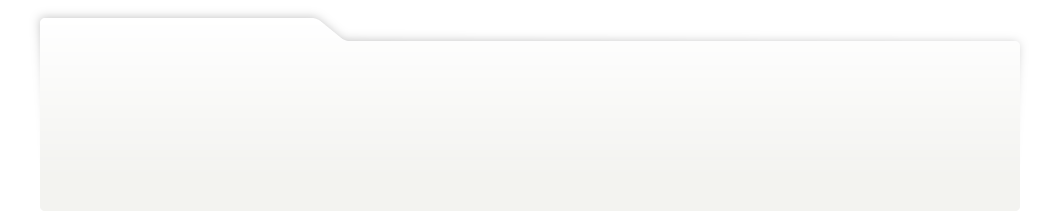
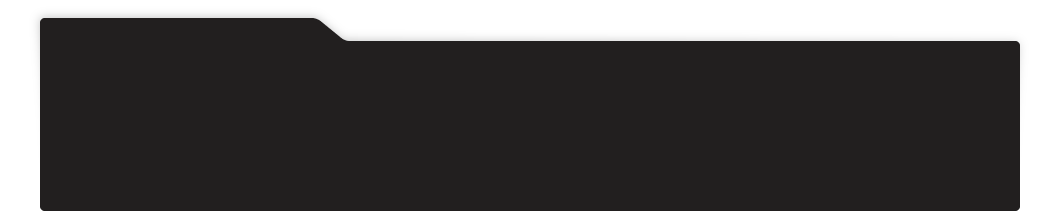
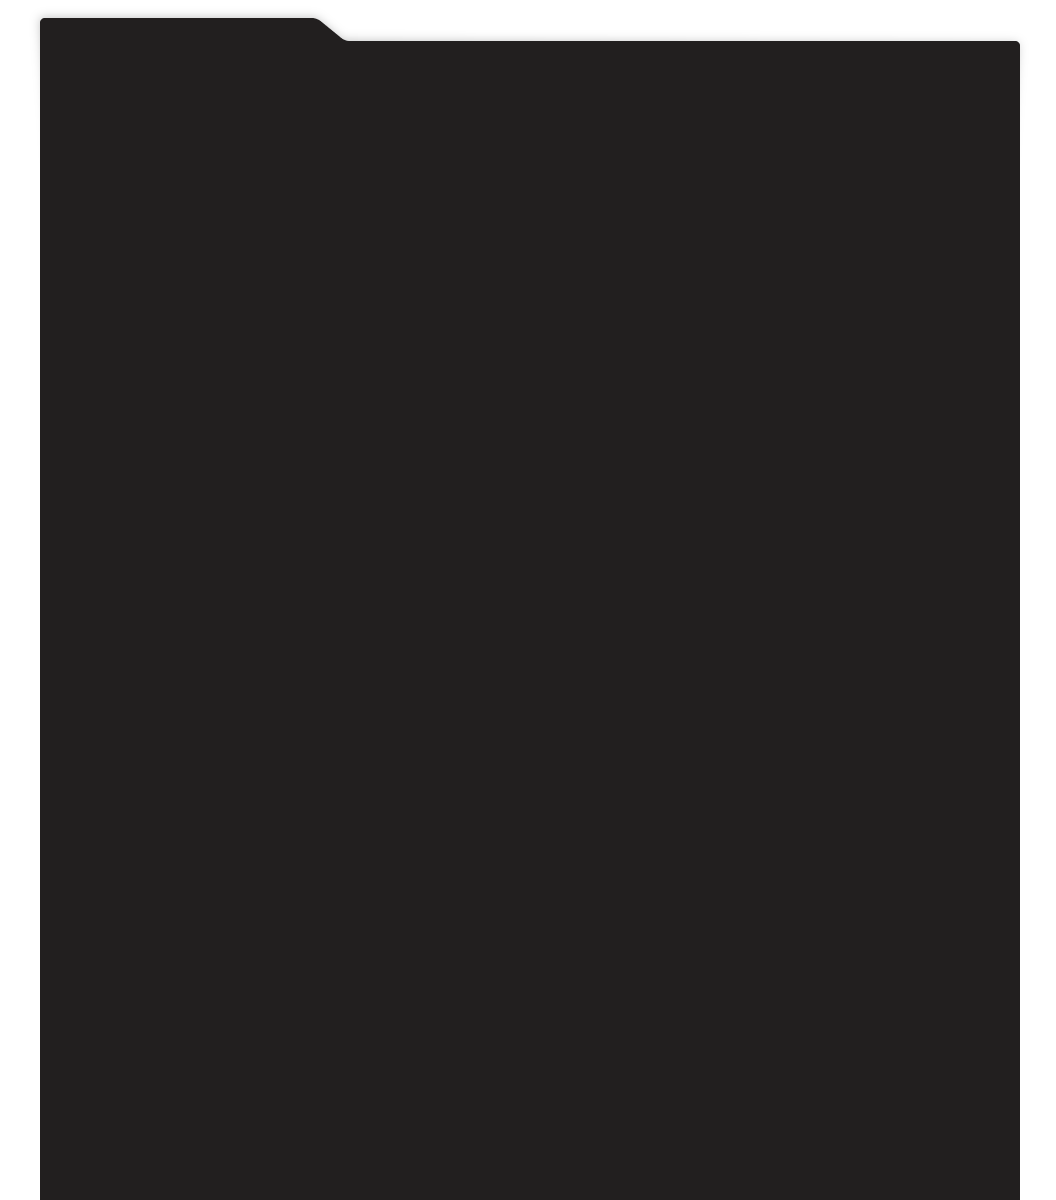
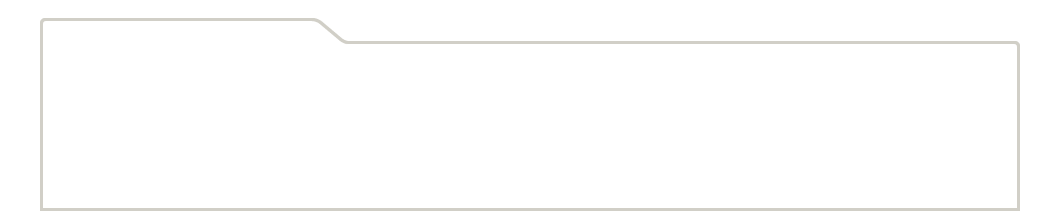
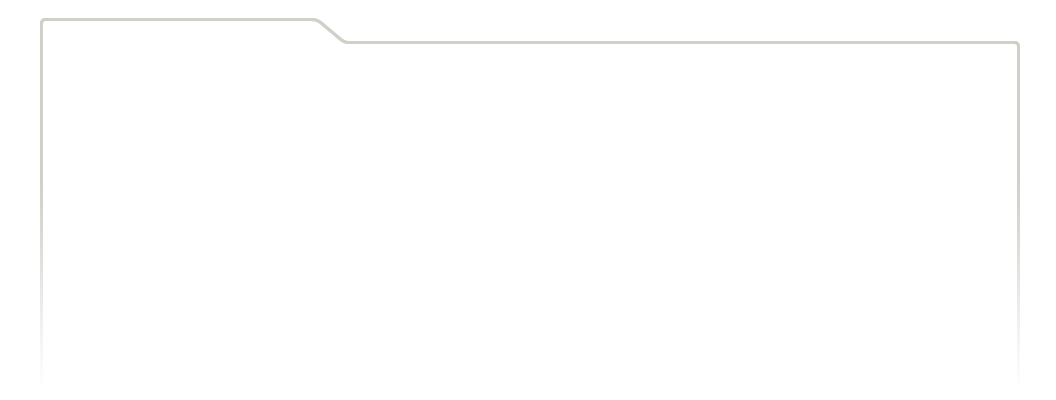
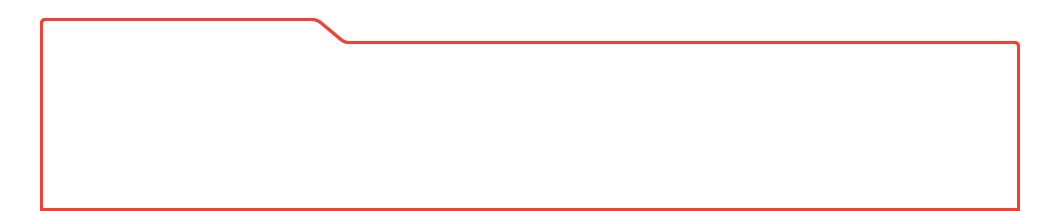
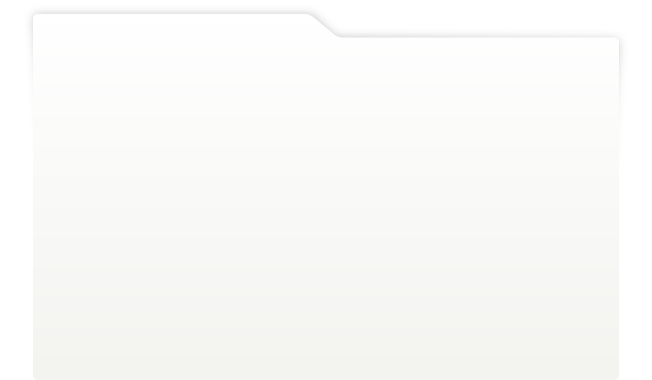
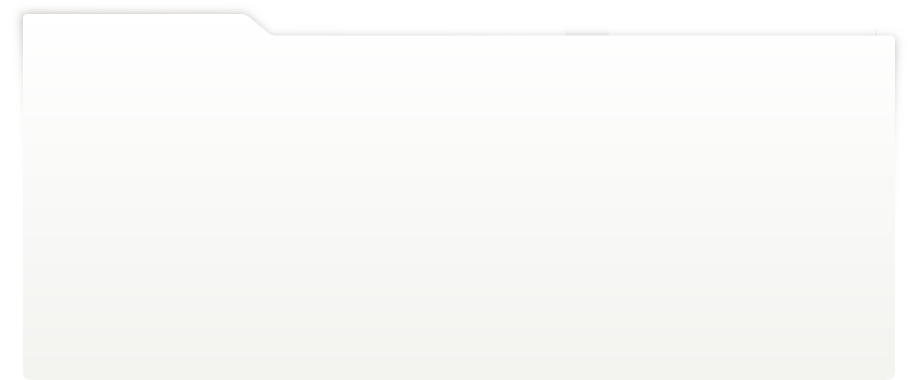
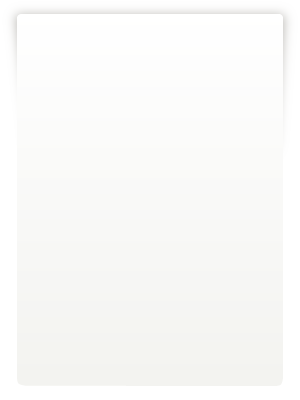
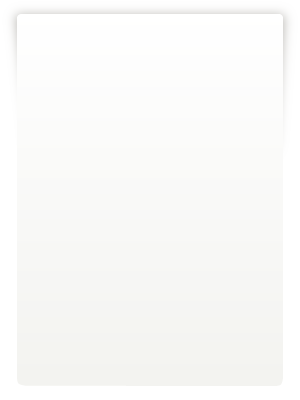
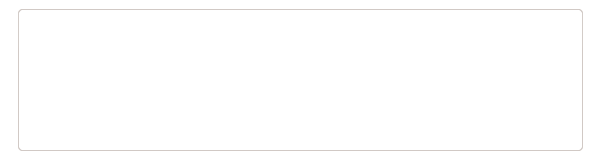
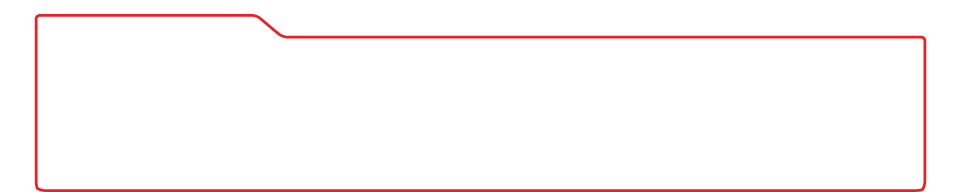
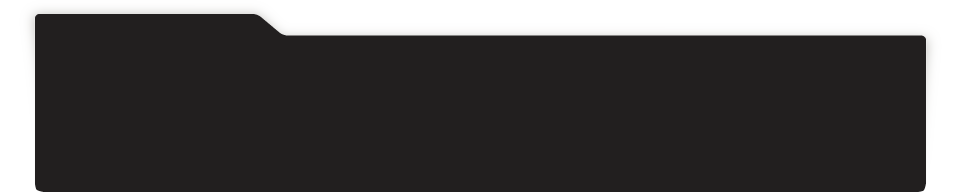
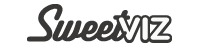
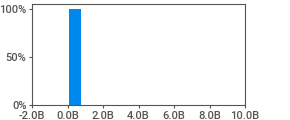
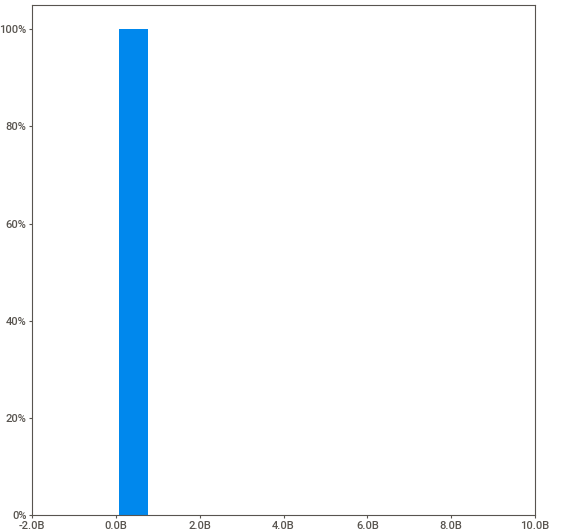
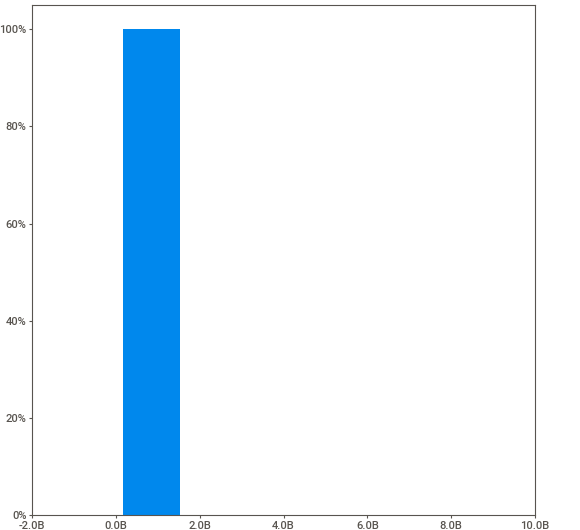
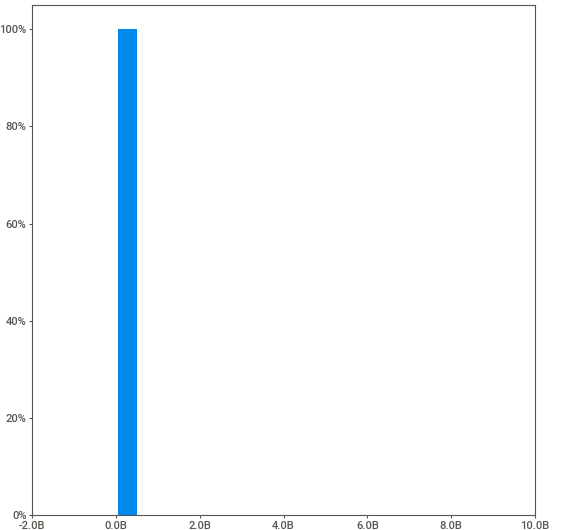
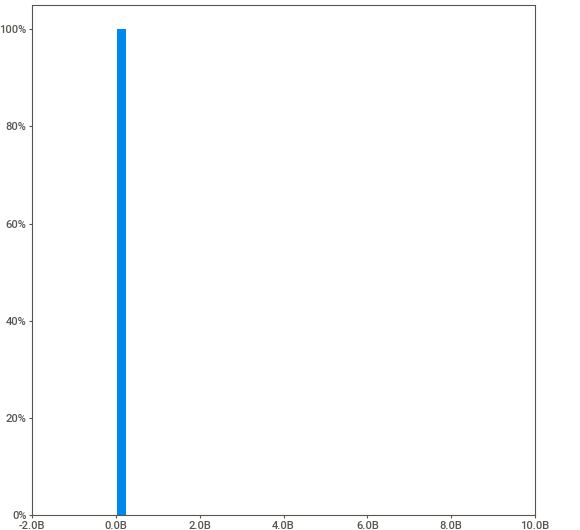
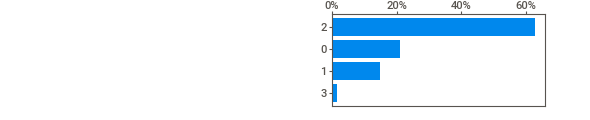
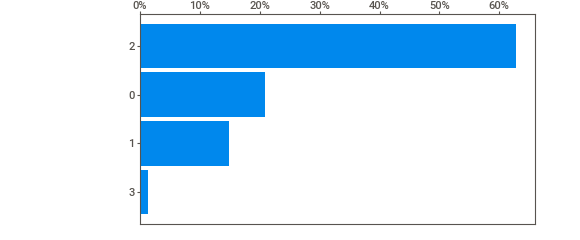
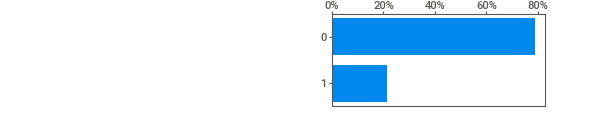
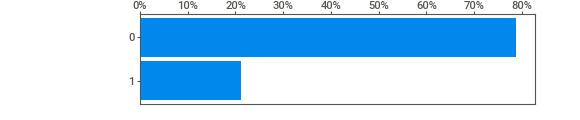
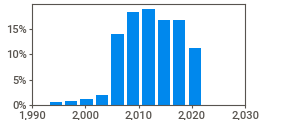
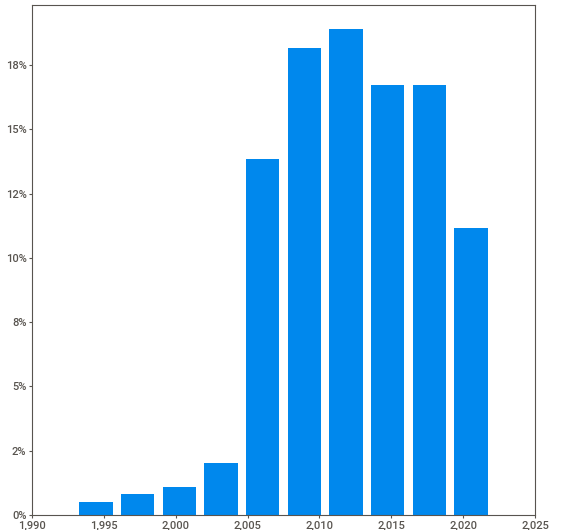
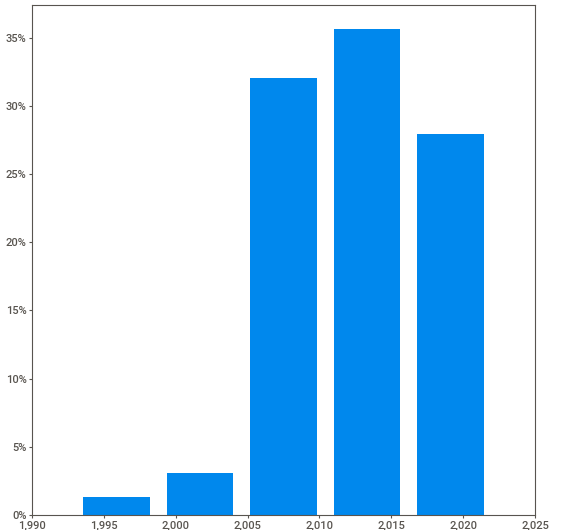
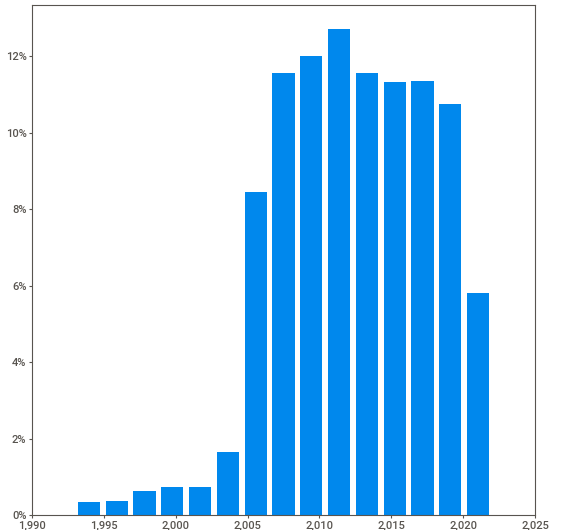
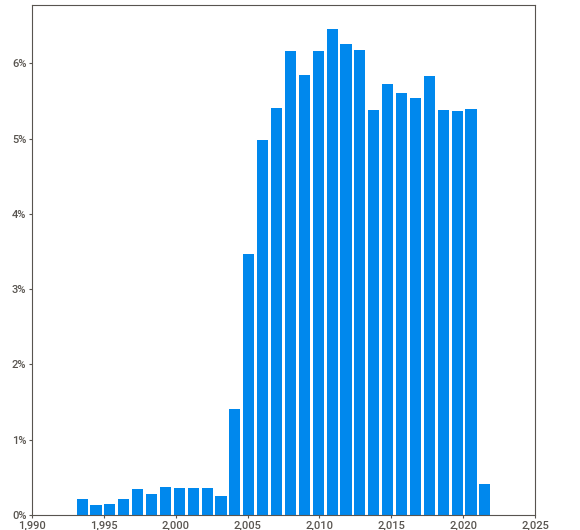
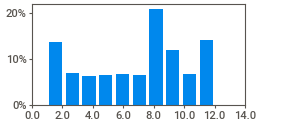
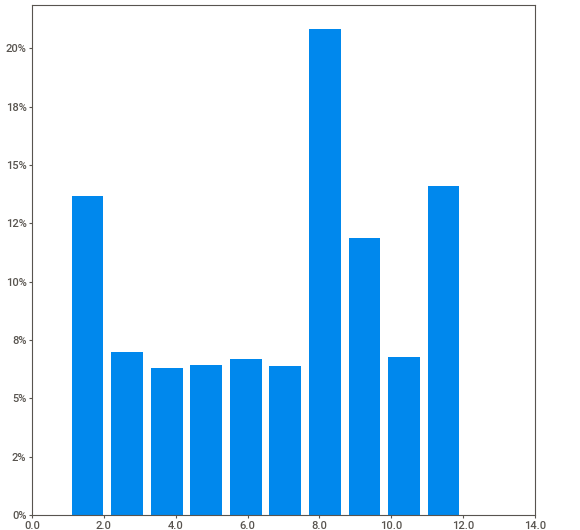
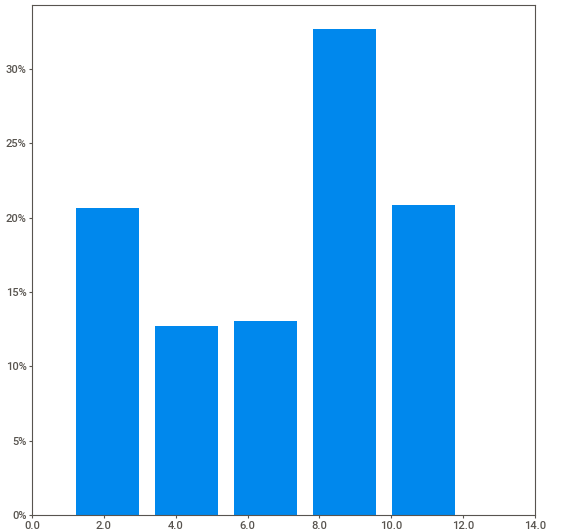
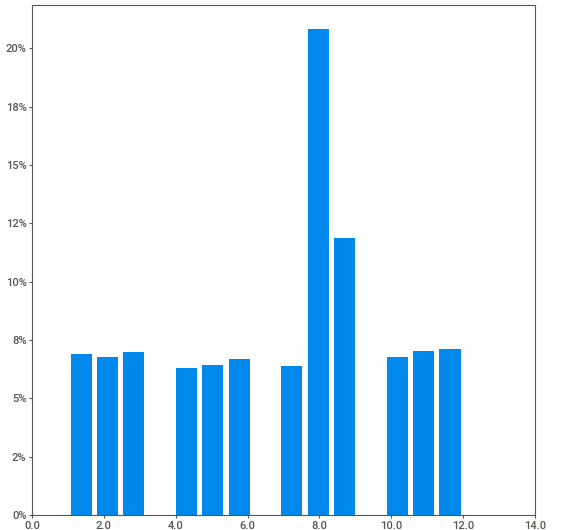
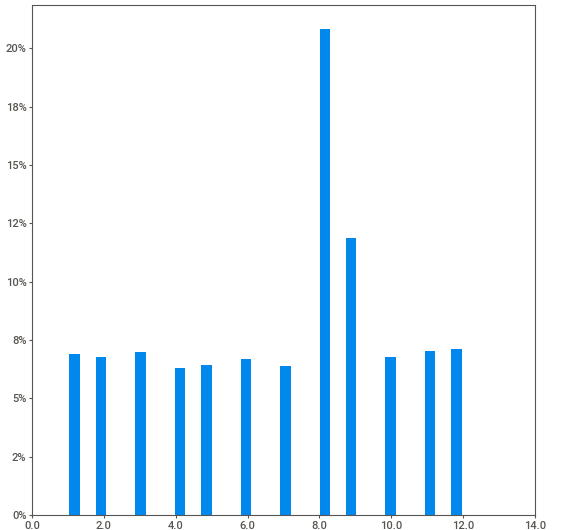
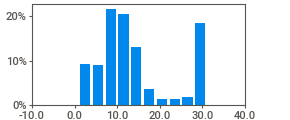
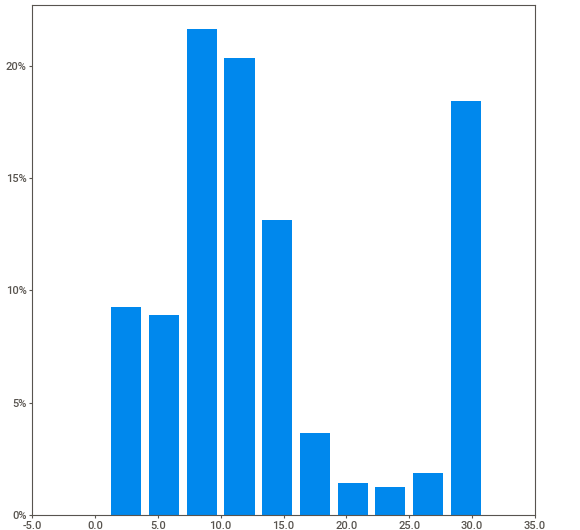
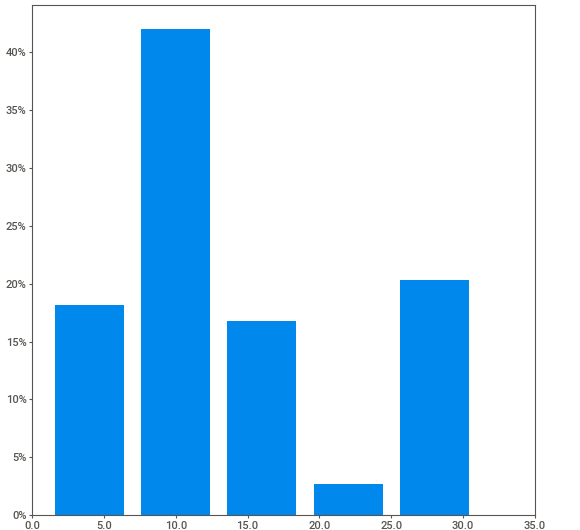
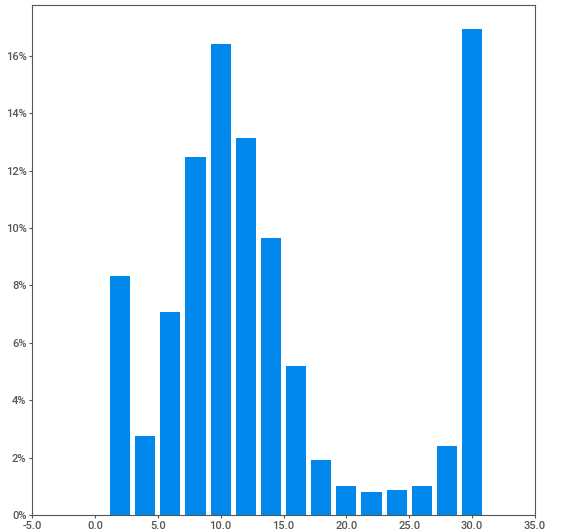
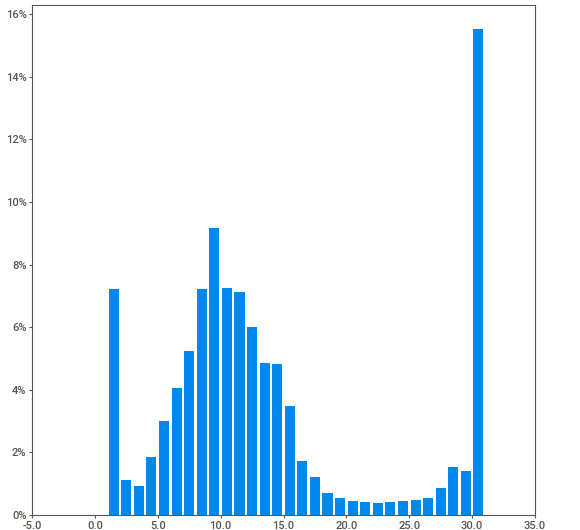
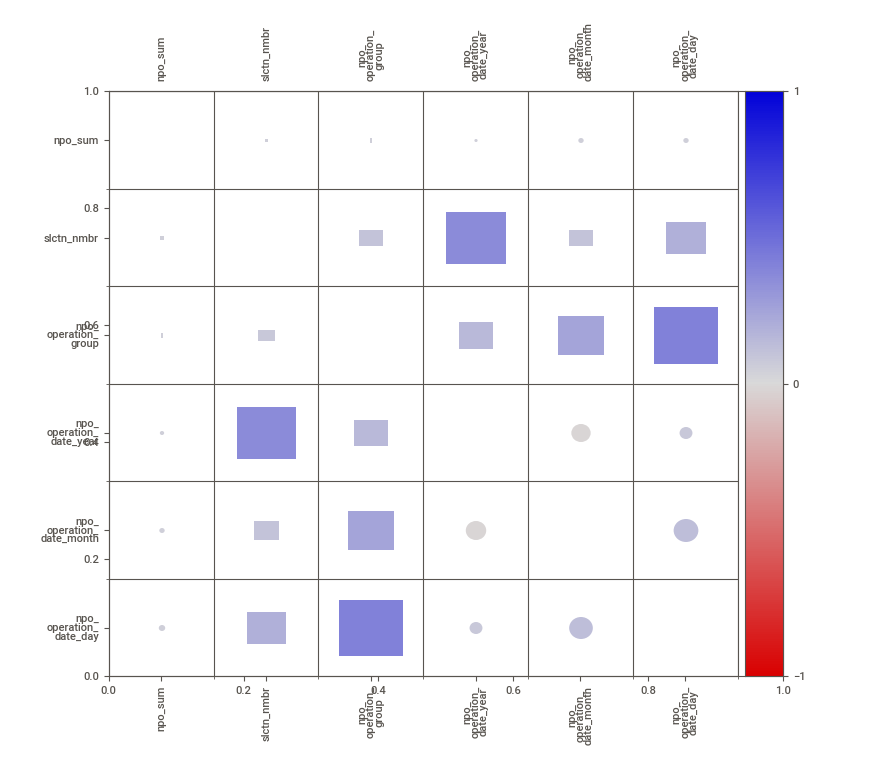
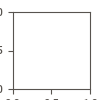

In [22]:
sv.analyze(npo_trnsctns_normed).show_notebook()


Feature: clnt_id                             |█▍        | [ 14%]   00:00 -> (00:01 left)c:\Users\Mike\Desktop\Hackaton2023\HT\lib\site-packages\sweetviz\from_profiling_pandas.py:65: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(keys):
Feature: slctn_nmbr                          |████▎     | [ 43%]   00:01 -> (00:03 left)c:\Users\Mike\Desktop\Hackaton2023\HT\lib\site-packages\sweetviz\from_profiling_pandas.py:65: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(keys):
Feature: pstl_code                           |███████▏  | [ 71%]   00:01 -> (00:00 left)c:\Users\Mike\Desktop\Hackaton2023\HT\lib\site-packages\sweetviz\from_profiling_pandas.py:65: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future ve


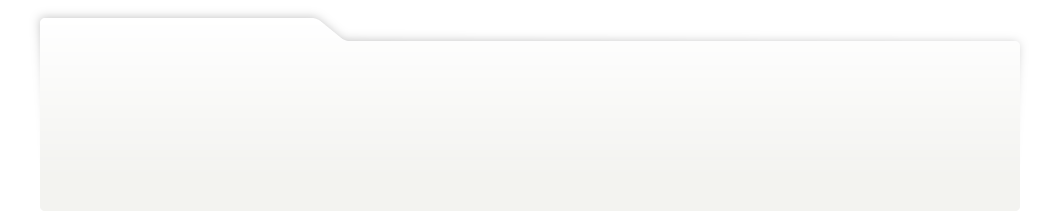
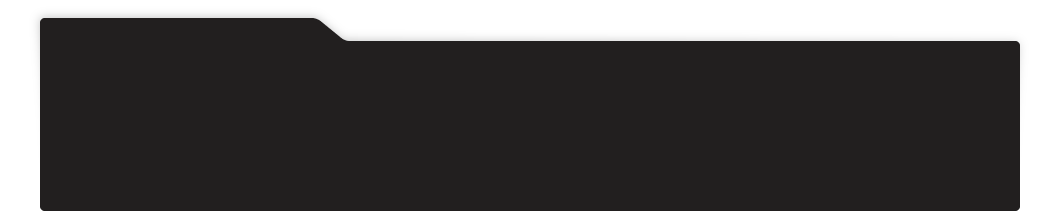
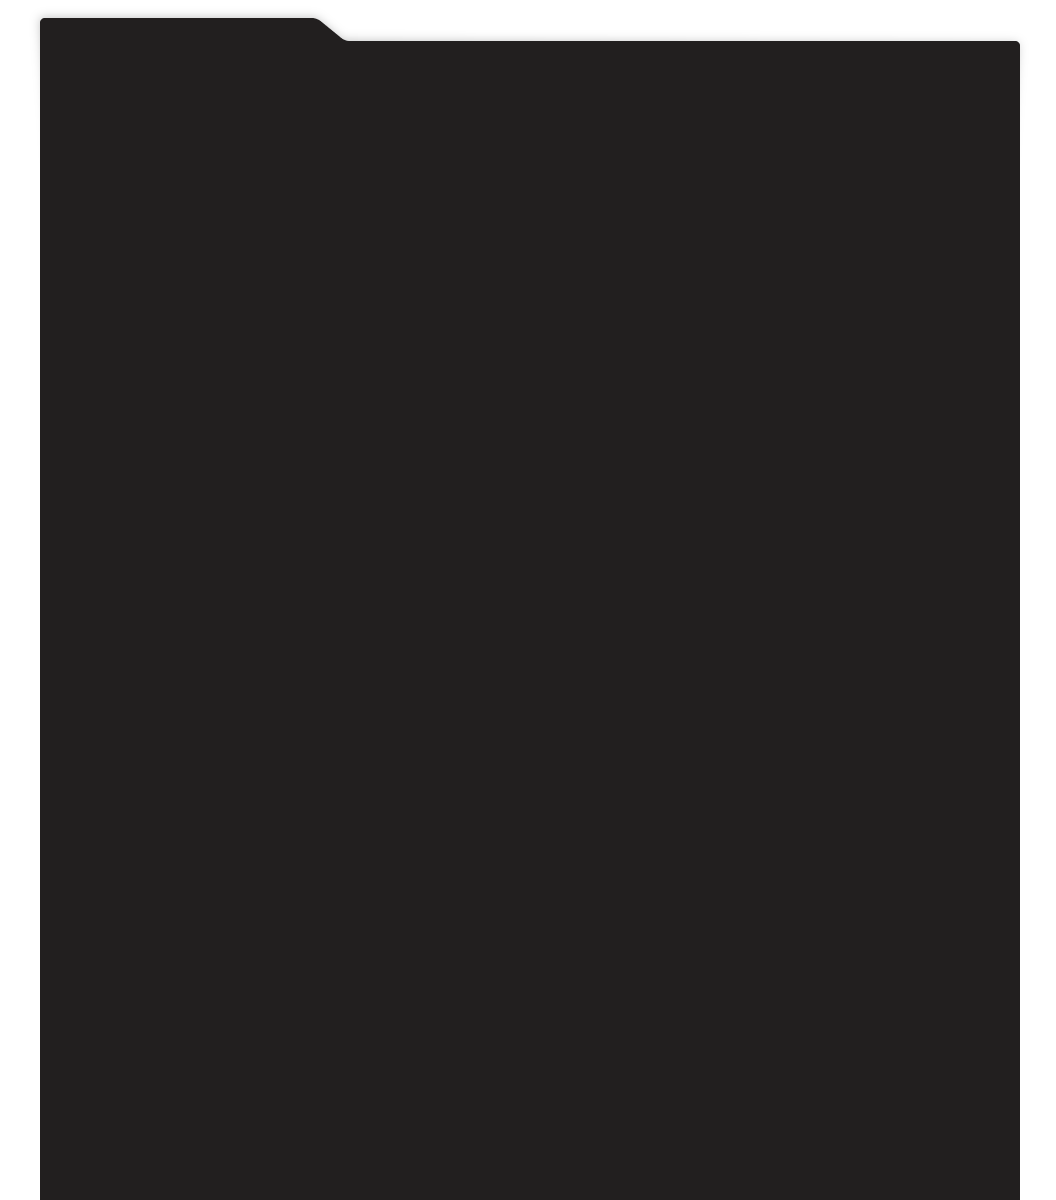
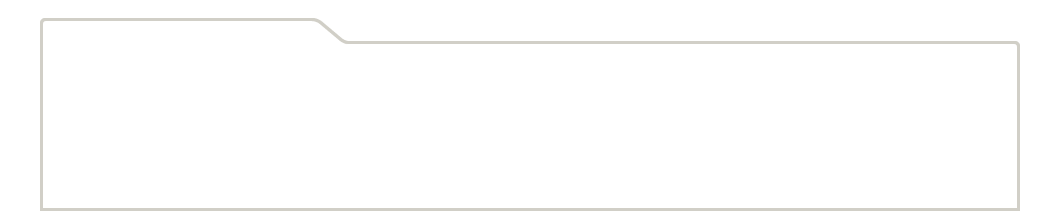
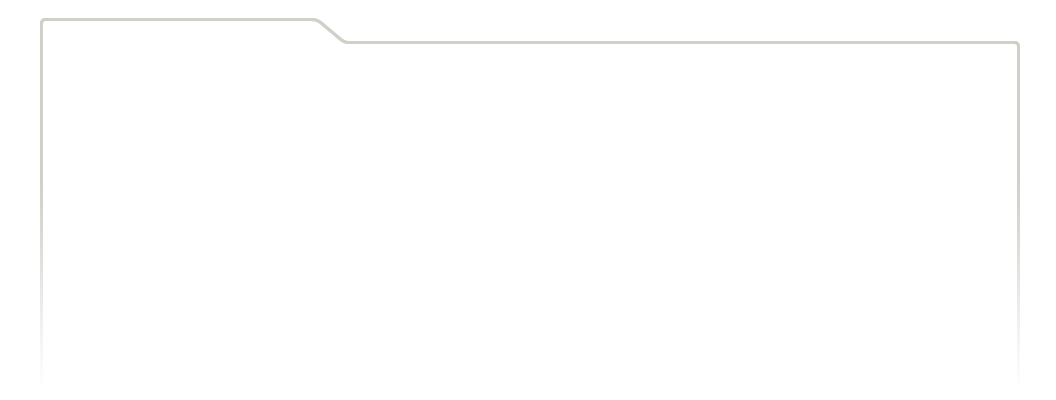
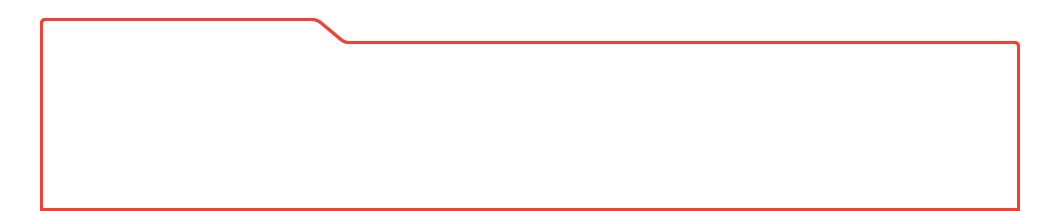
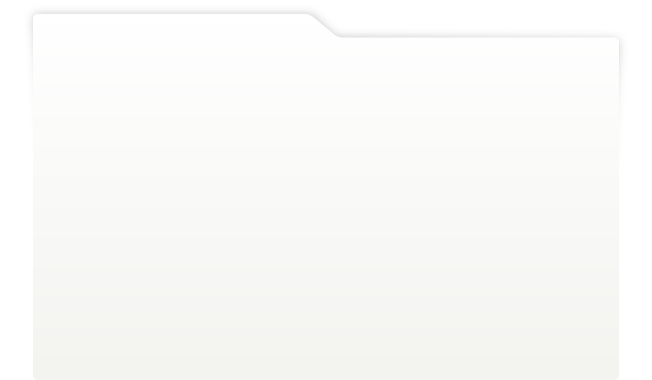
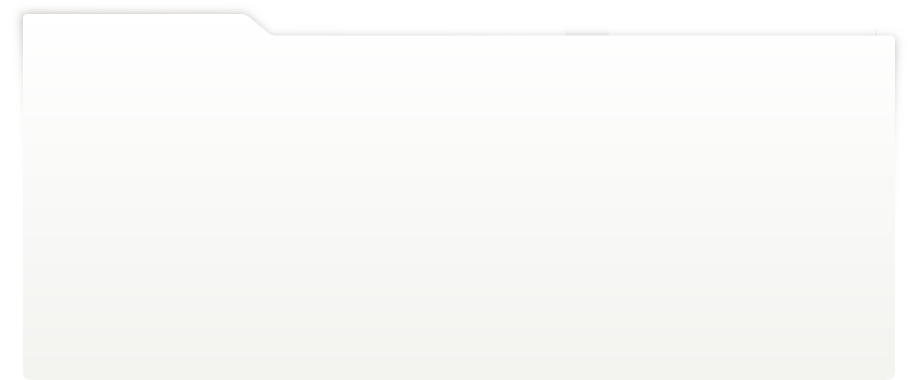
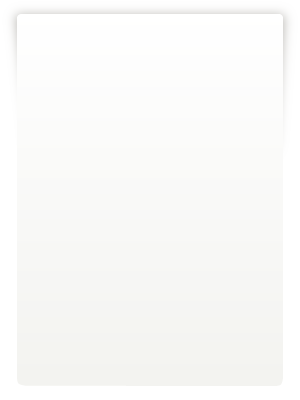
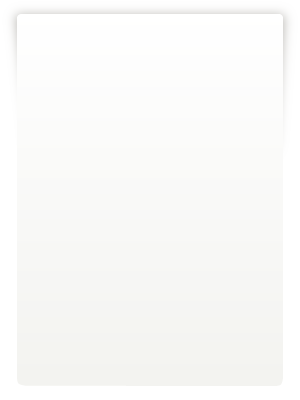
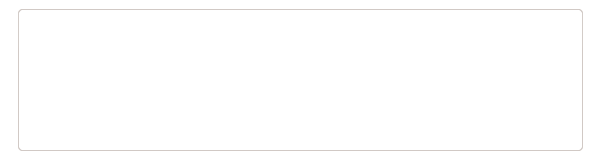
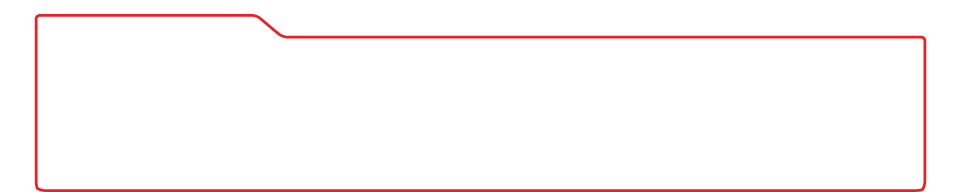
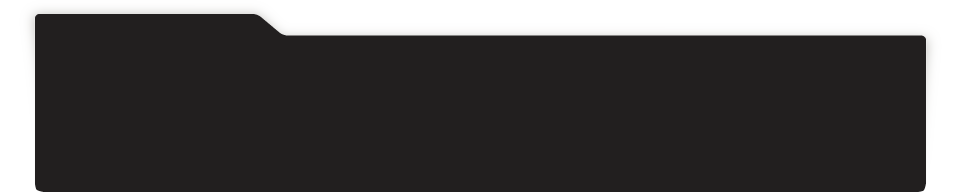
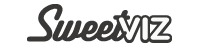
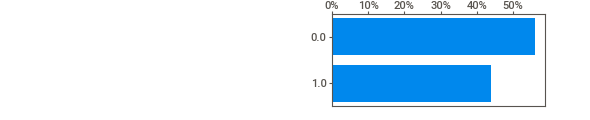
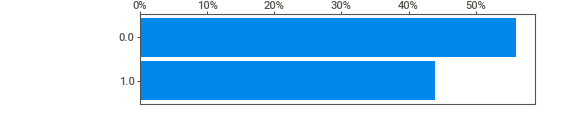
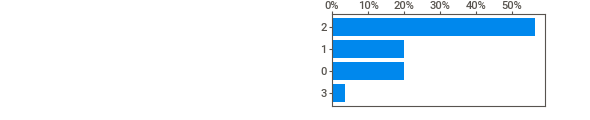
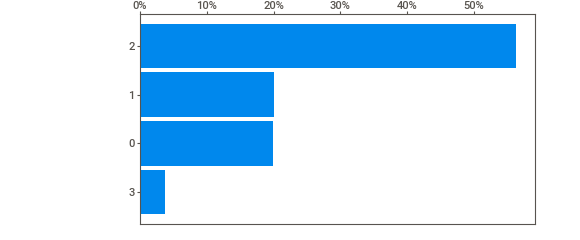
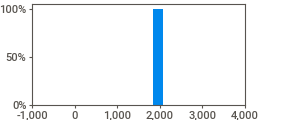
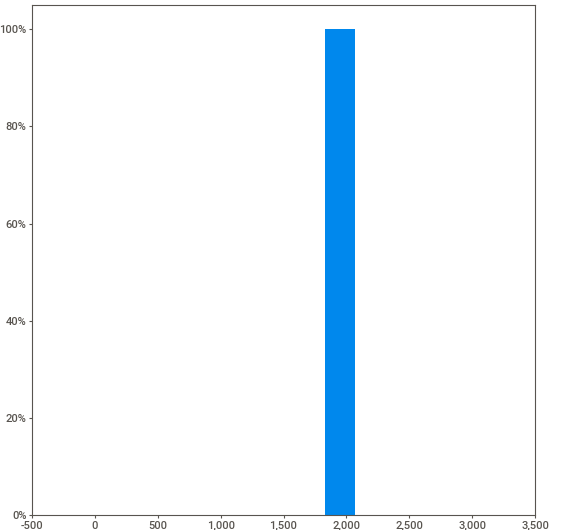
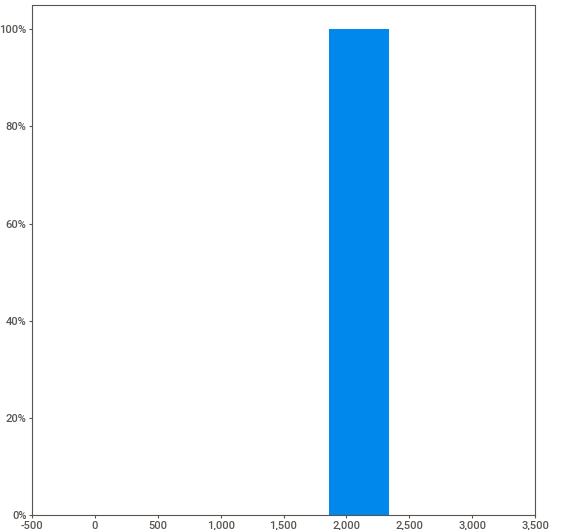
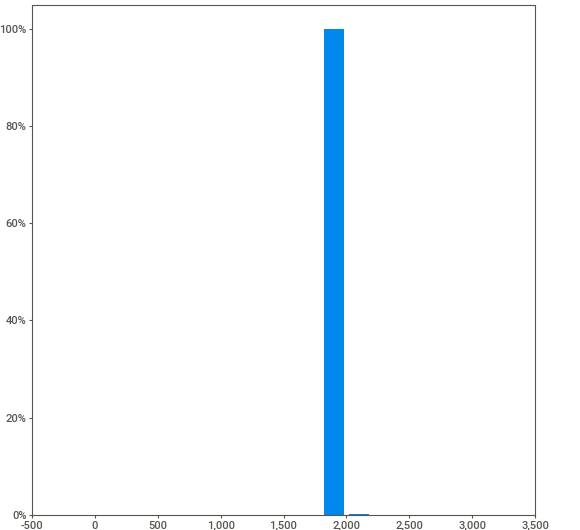
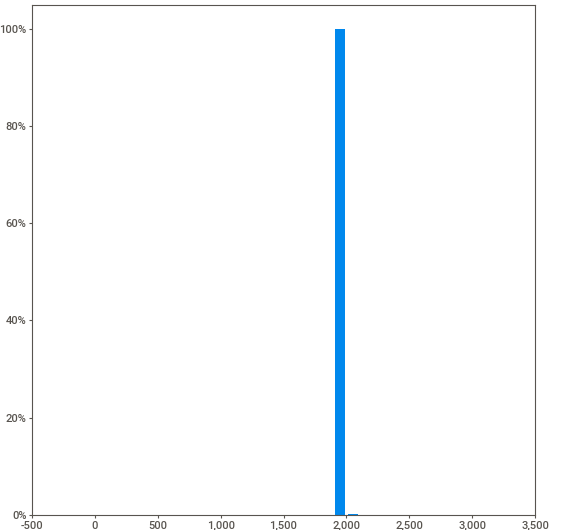
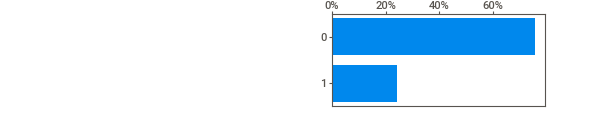
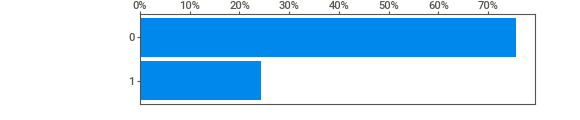
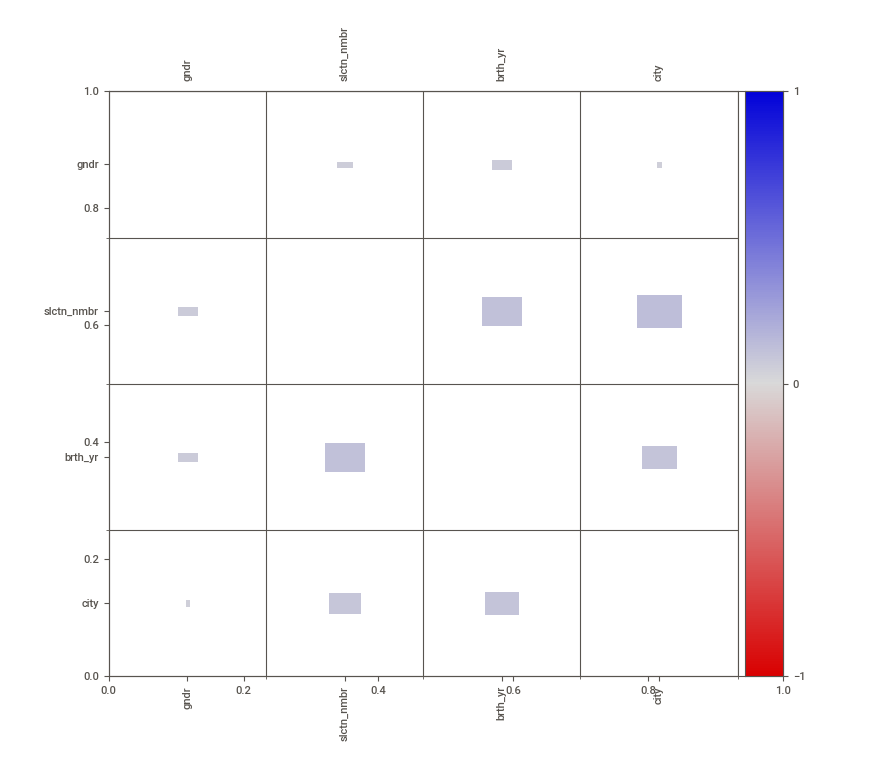
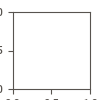

In [23]:
sv.analyze(npo_clnts_normed).show_notebook()


Feature: npo_accnt_id                        |▌         | [  6%]   00:00 -> (00:05 left)c:\Users\Mike\Desktop\Hackaton2023\HT\lib\site-packages\sweetviz\from_profiling_pandas.py:65: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(keys):
Feature: clnt_id                             |█▏        | [ 12%]   00:01 -> (00:16 left)c:\Users\Mike\Desktop\Hackaton2023\HT\lib\site-packages\sweetviz\from_profiling_pandas.py:65: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(keys):
Feature: slctn_nmbr                          |██▎       | [ 24%]   00:03 -> (00:12 left)c:\Users\Mike\Desktop\Hackaton2023\HT\lib\site-packages\sweetviz\from_profiling_pandas.py:65: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future ve


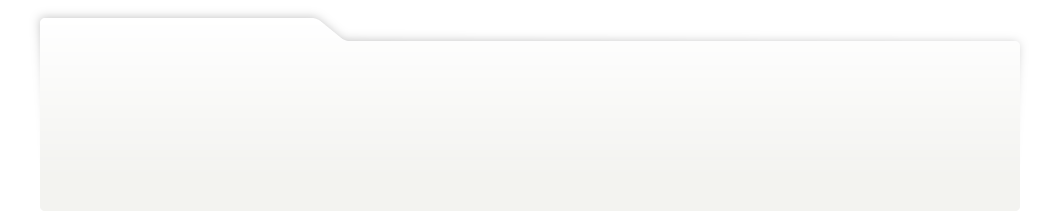
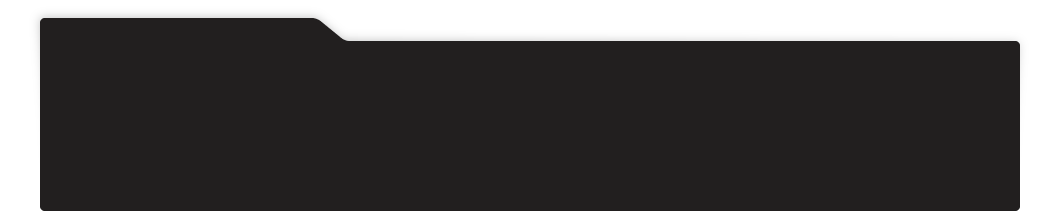
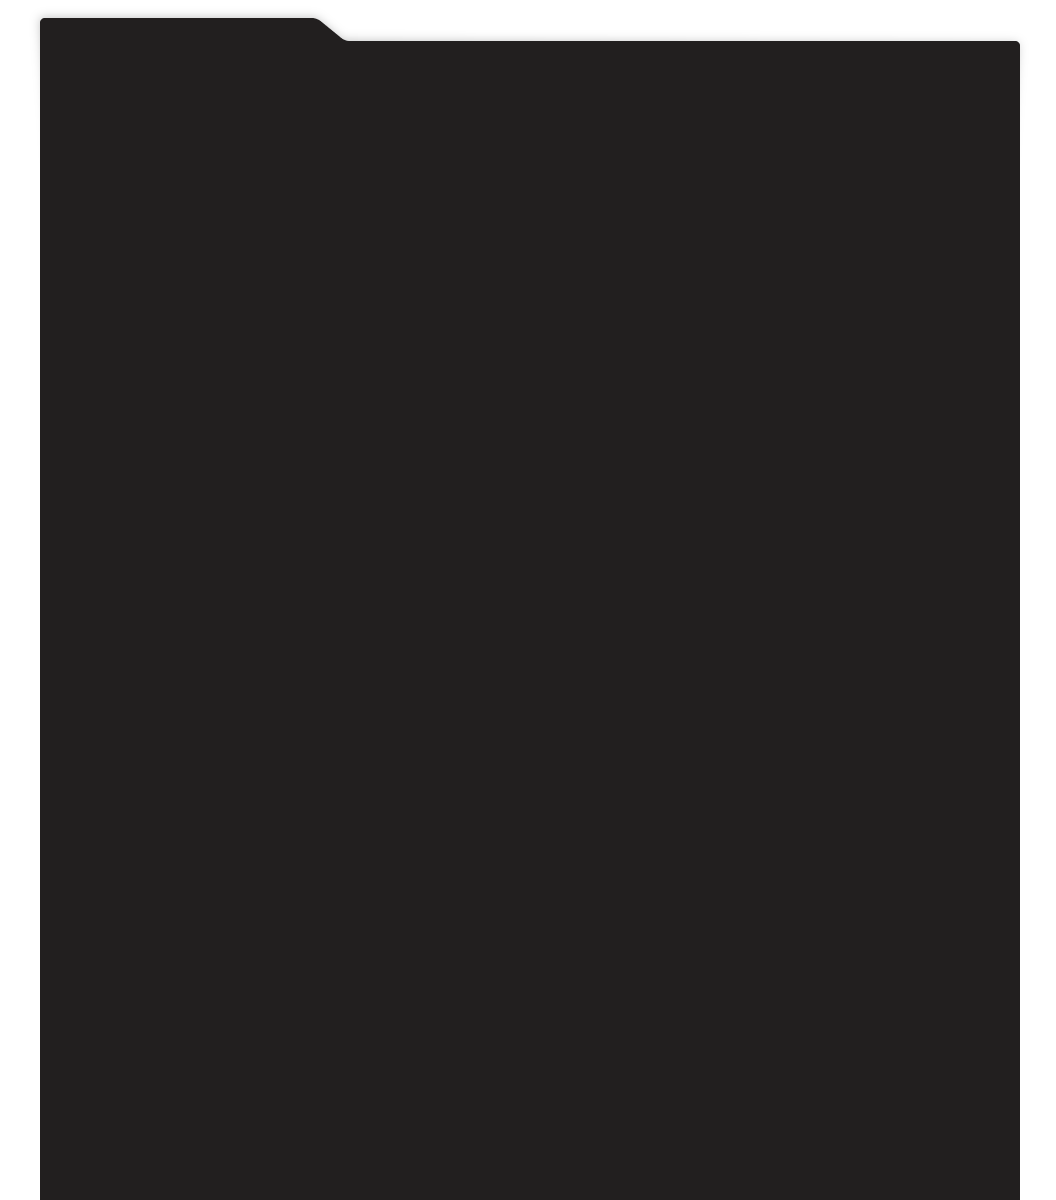
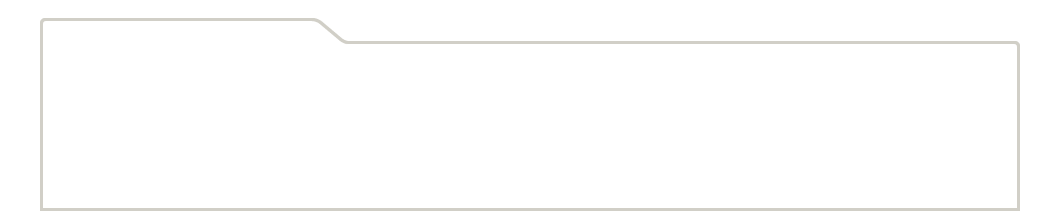
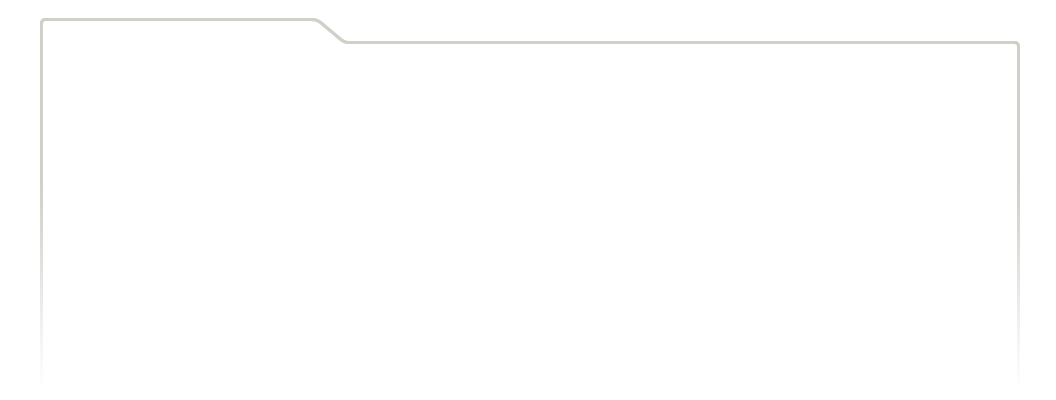
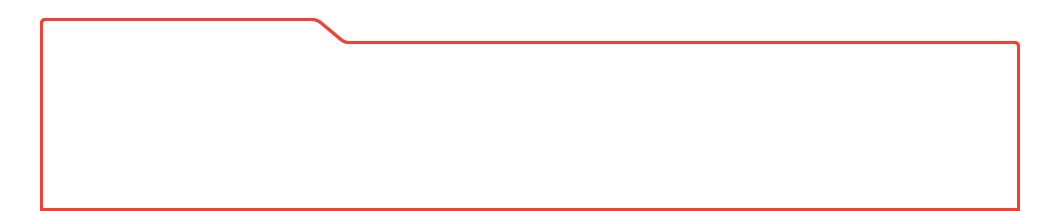
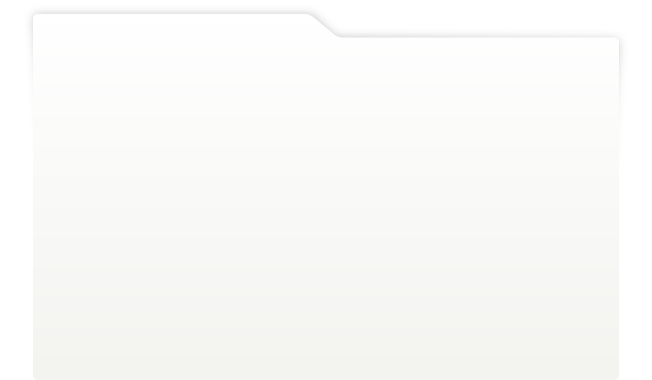
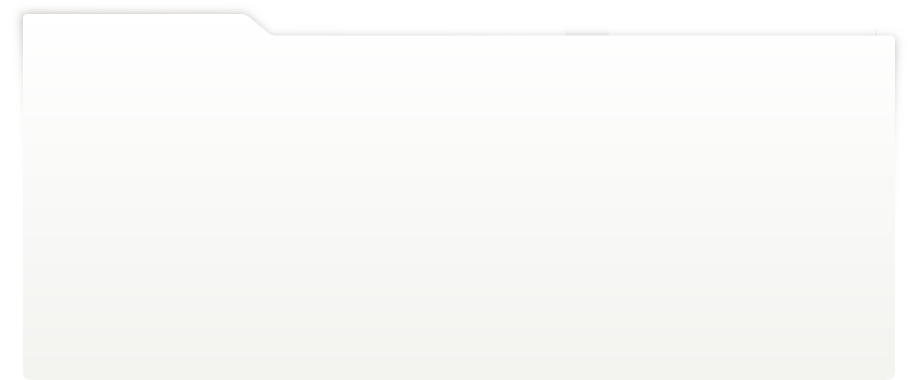
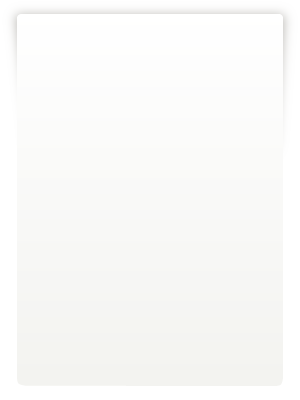
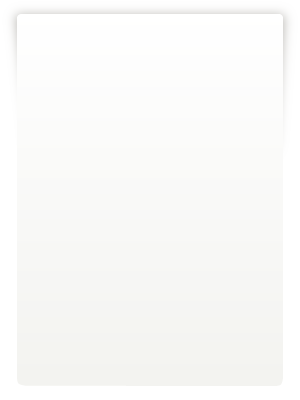
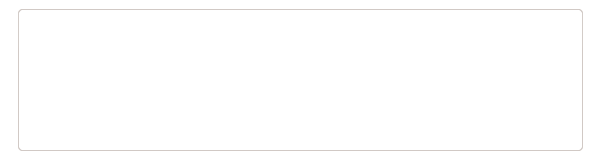
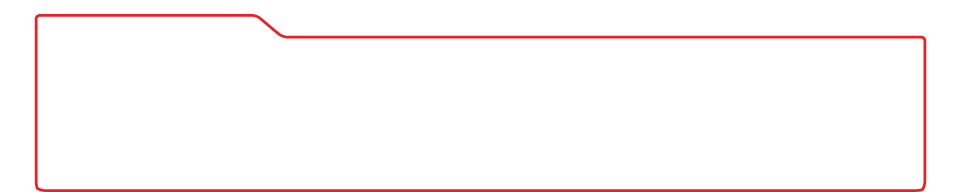
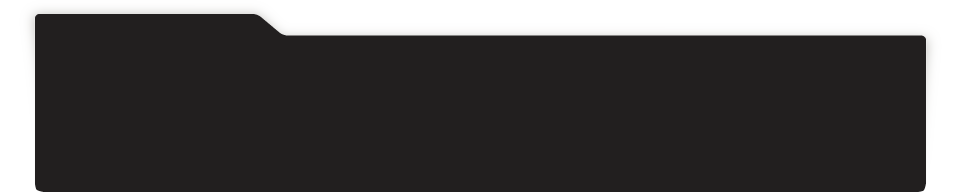
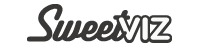
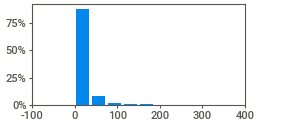
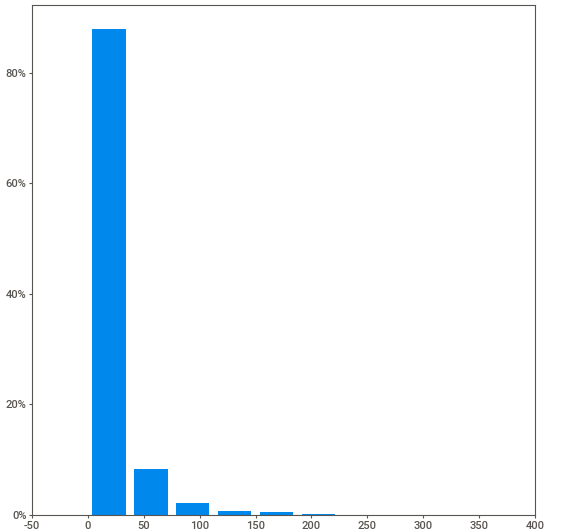
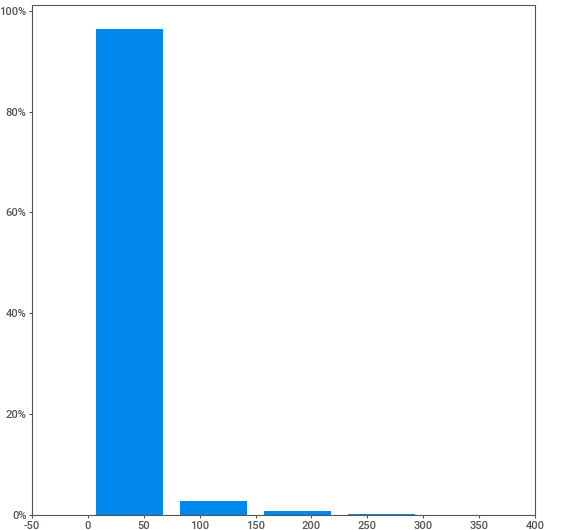
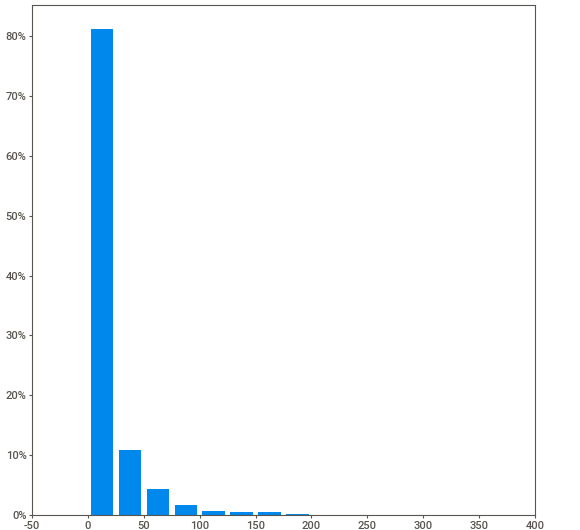
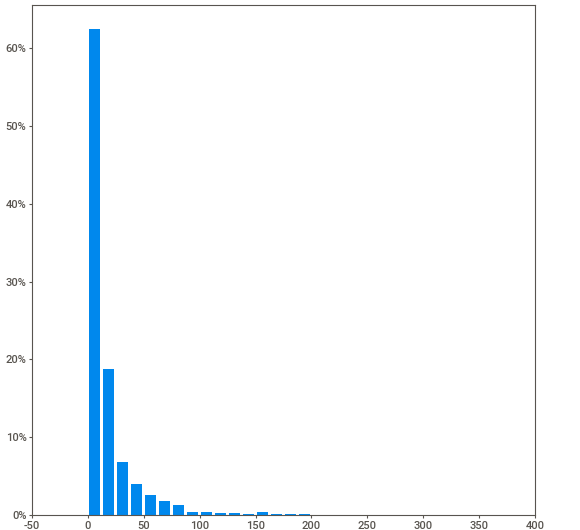
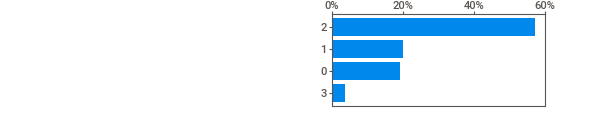
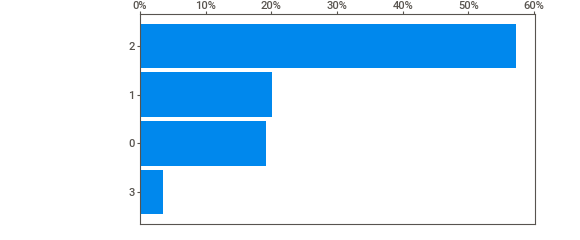
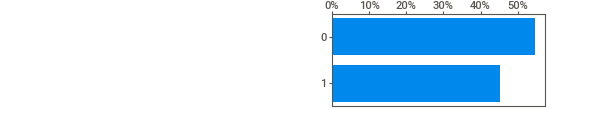
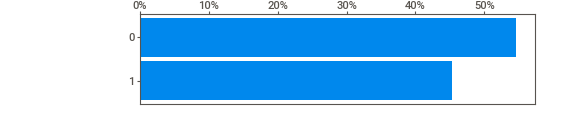
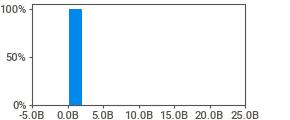
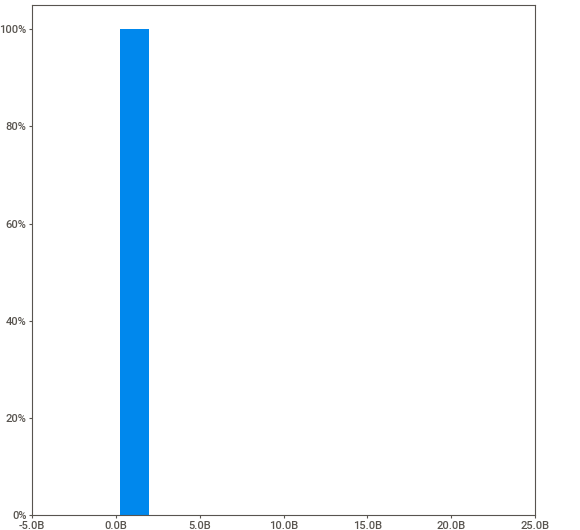
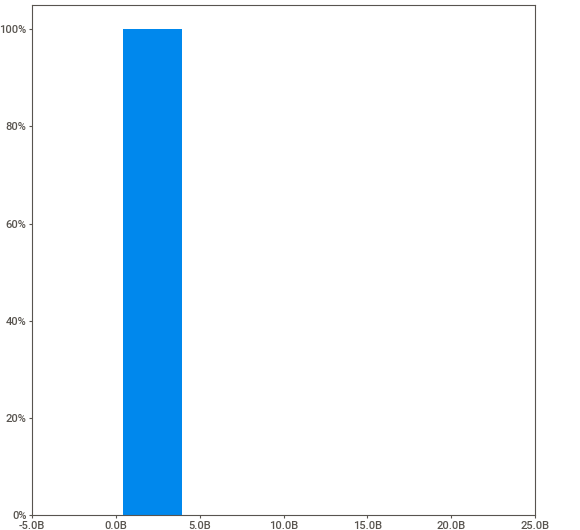
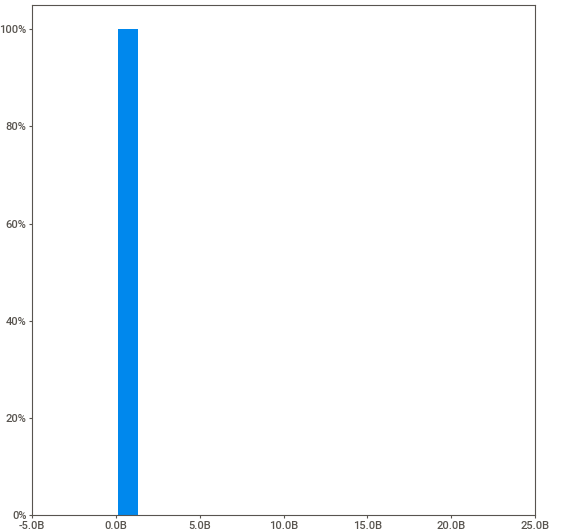
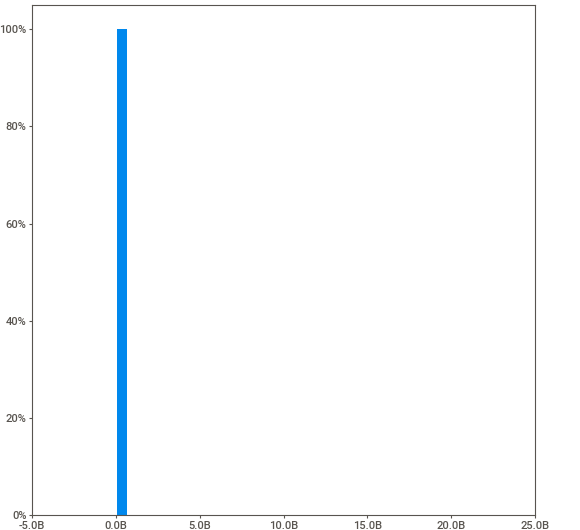
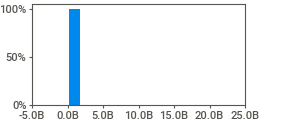
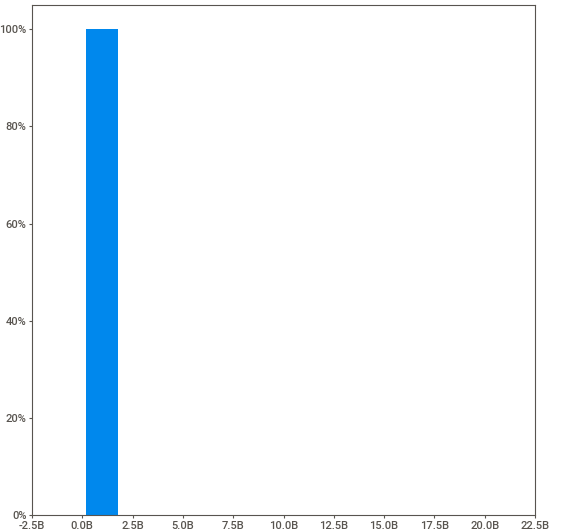
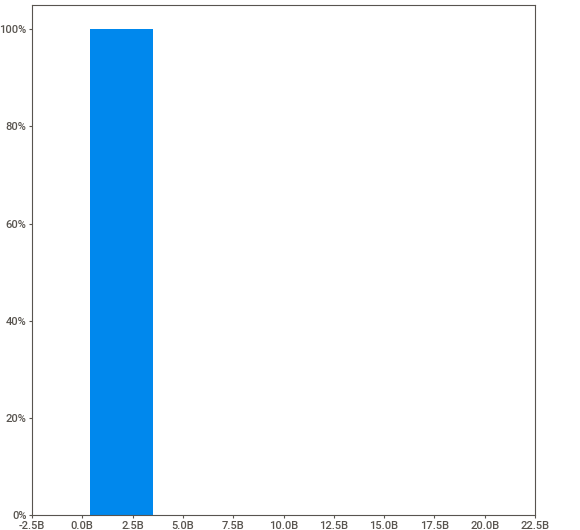
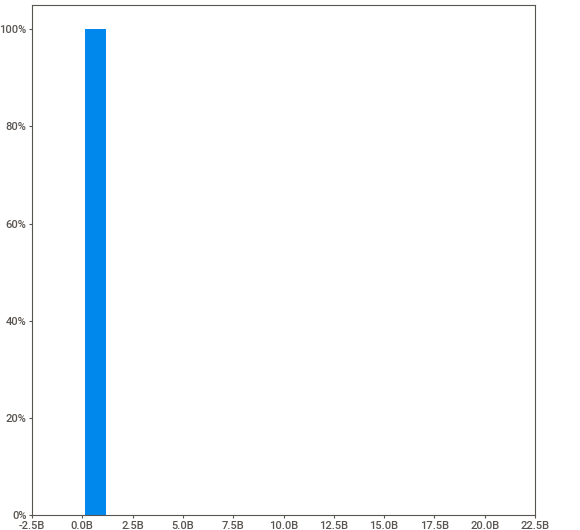
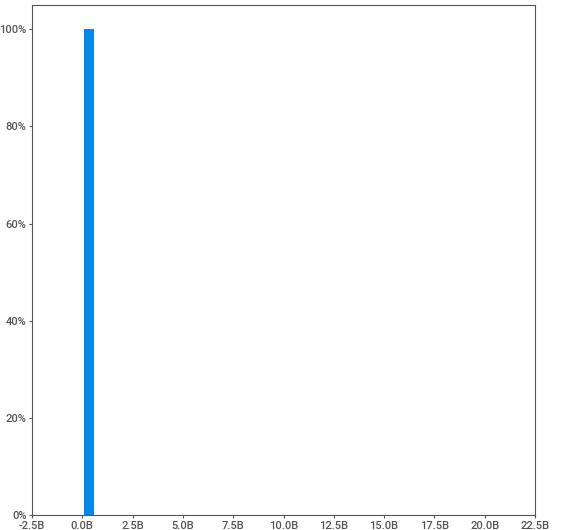
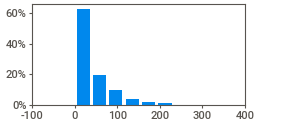
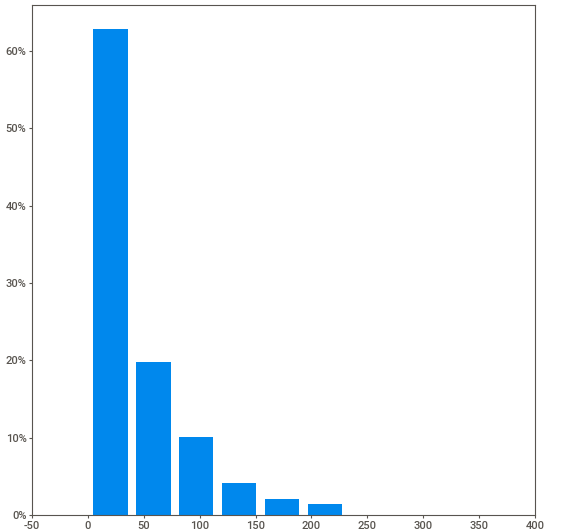
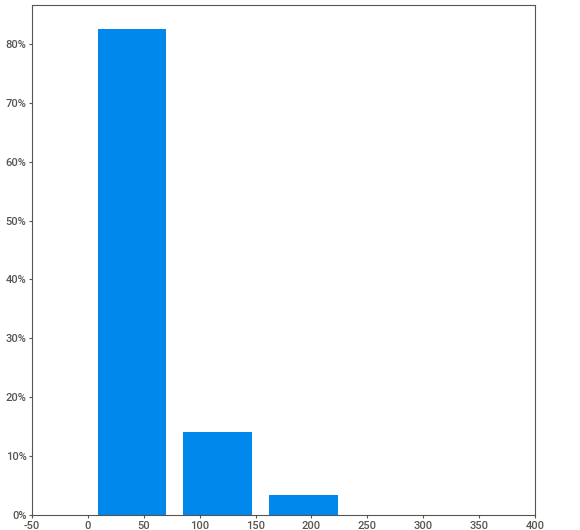
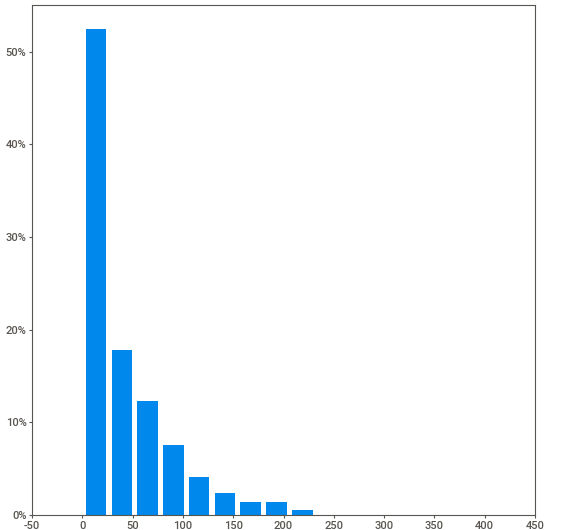
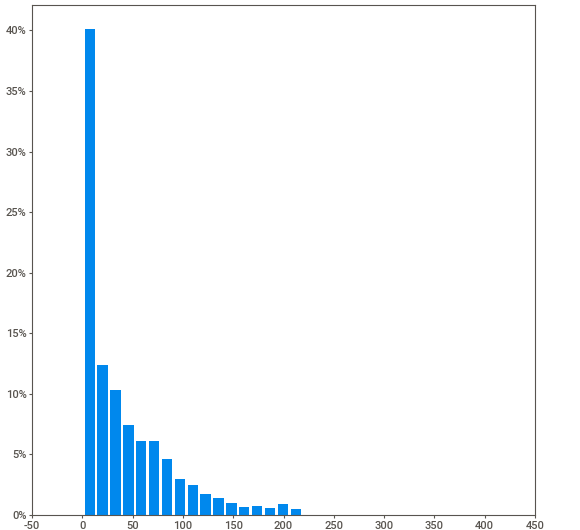
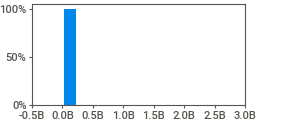
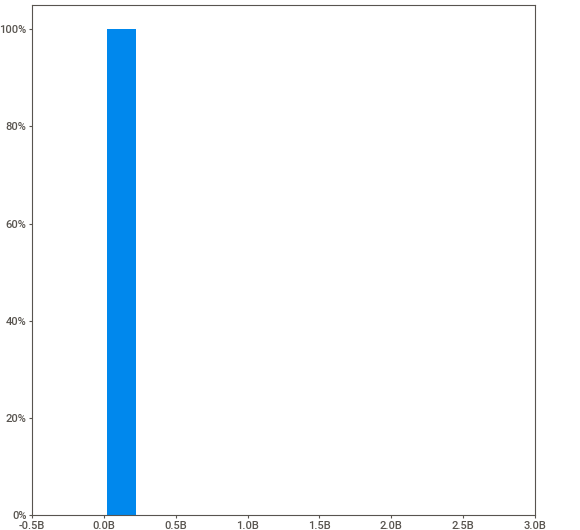
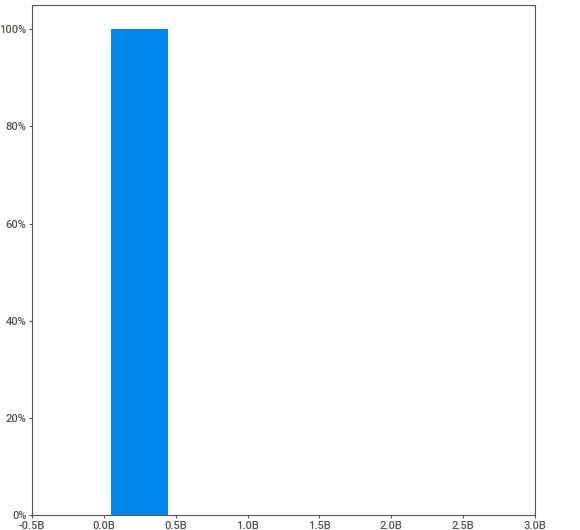
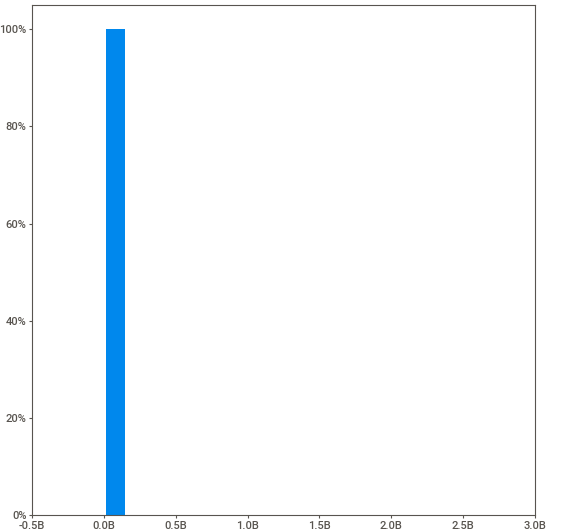
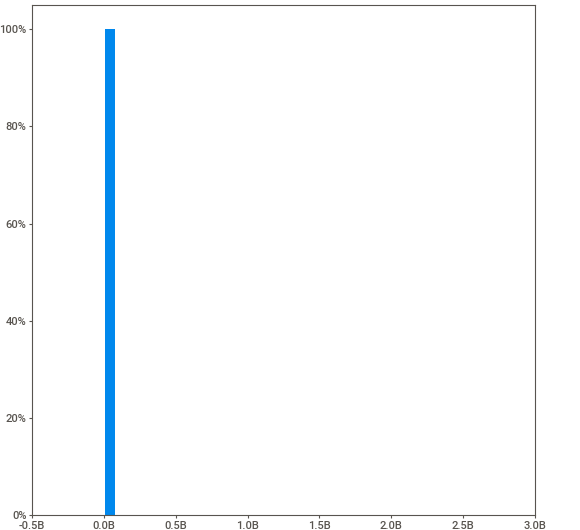
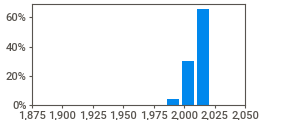
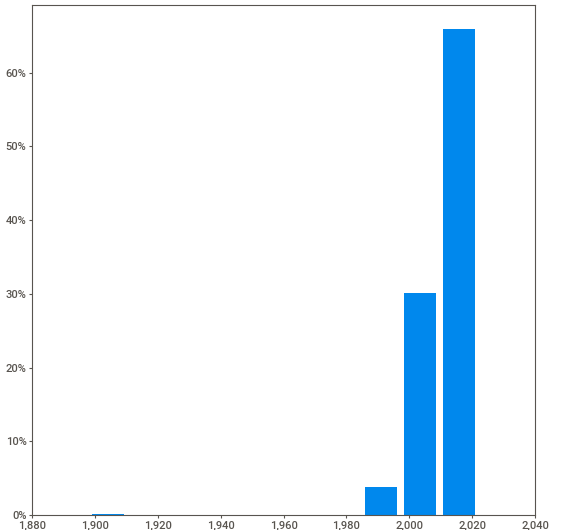
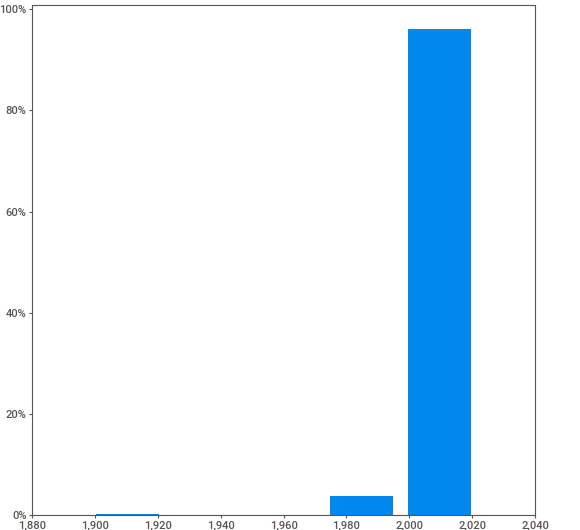
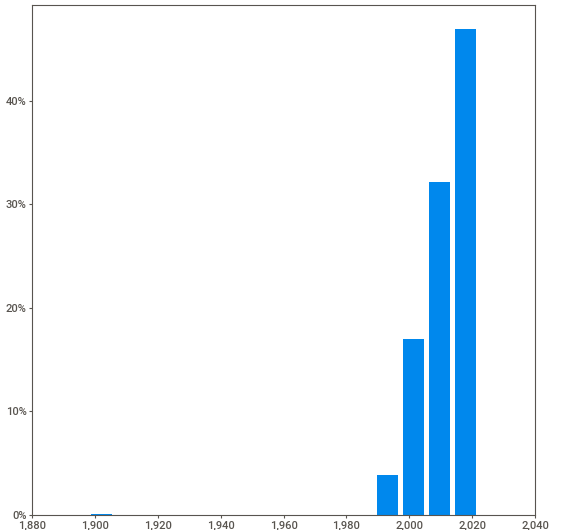
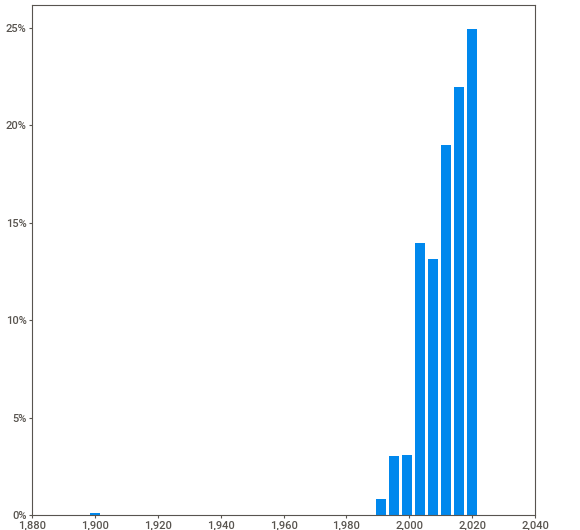
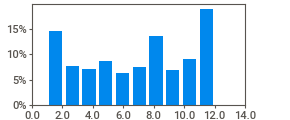
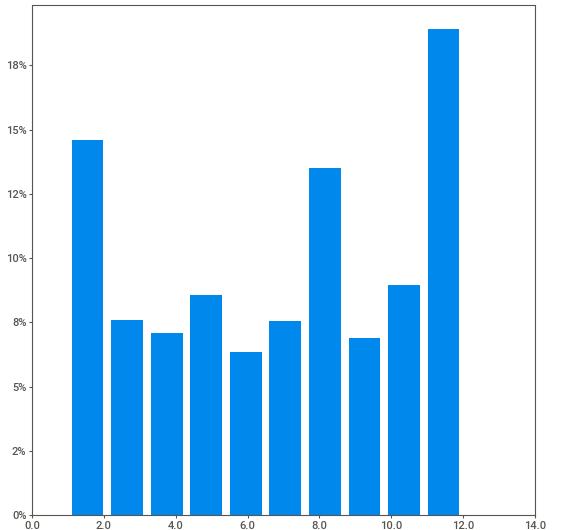
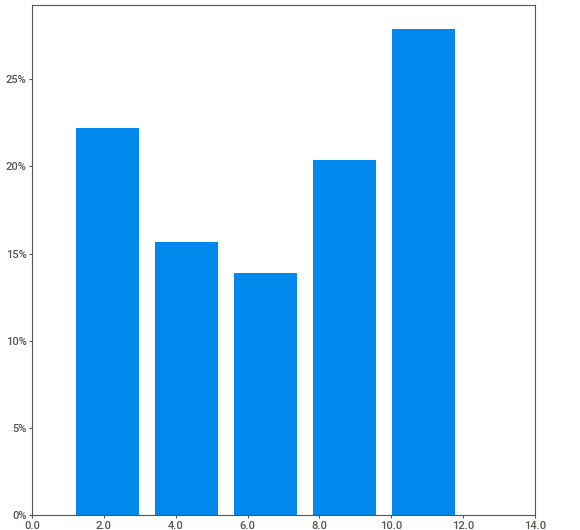
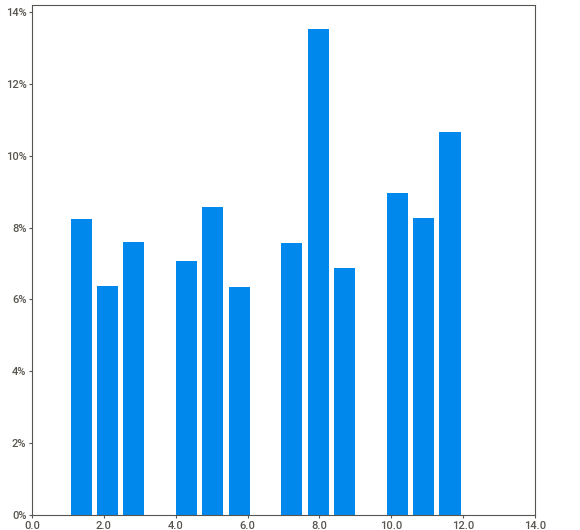
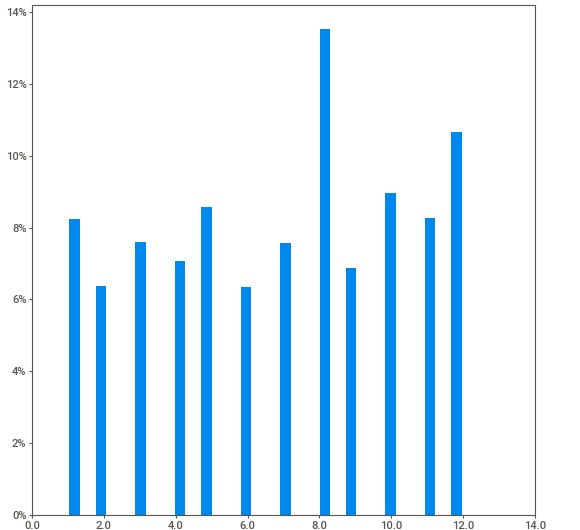
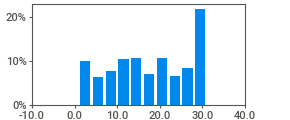
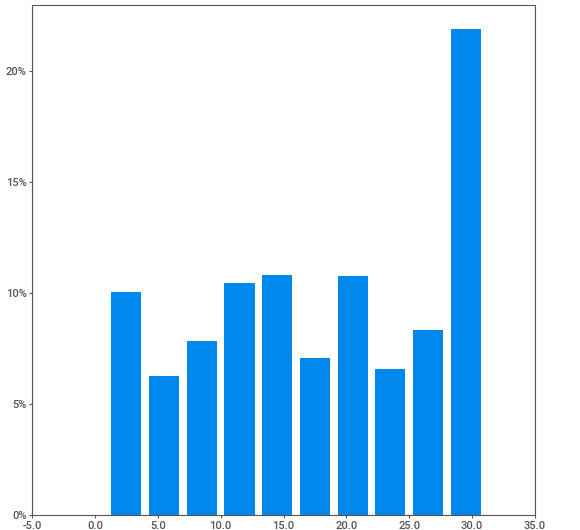
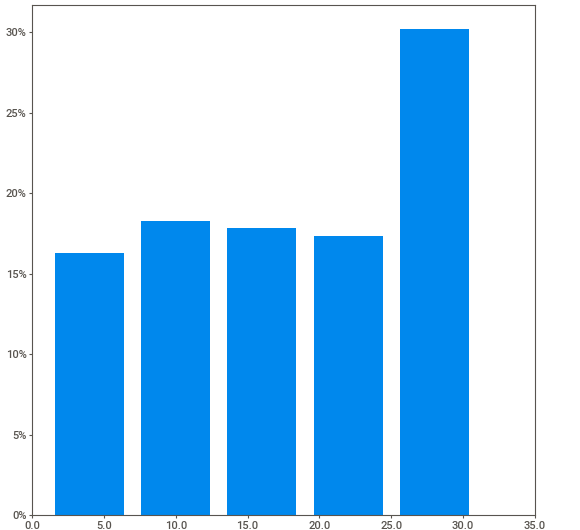
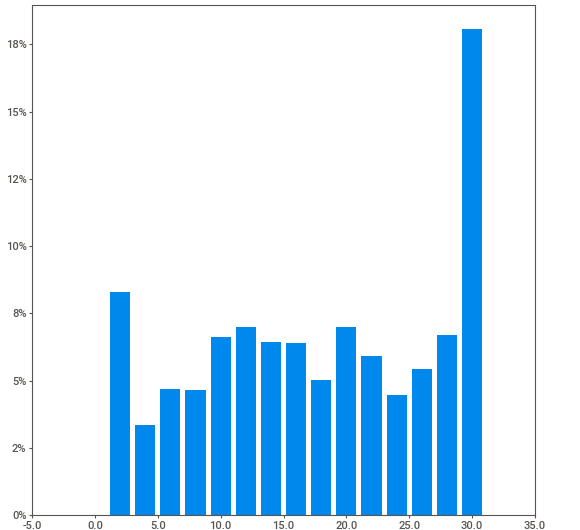
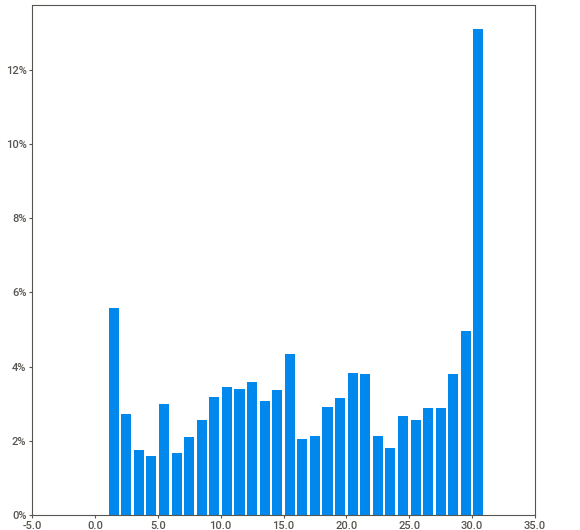
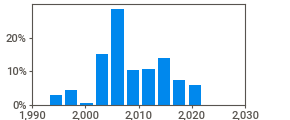
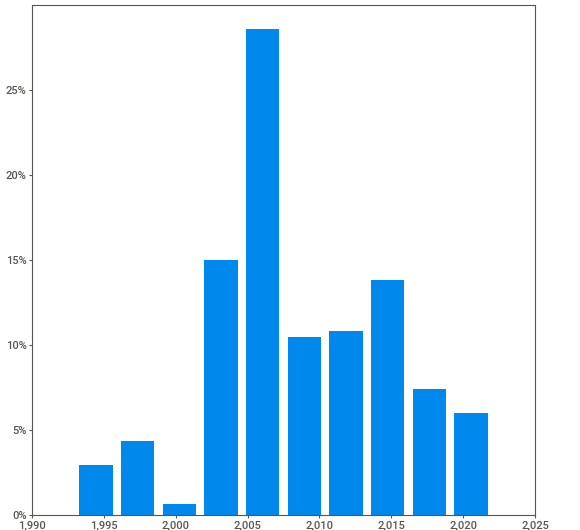
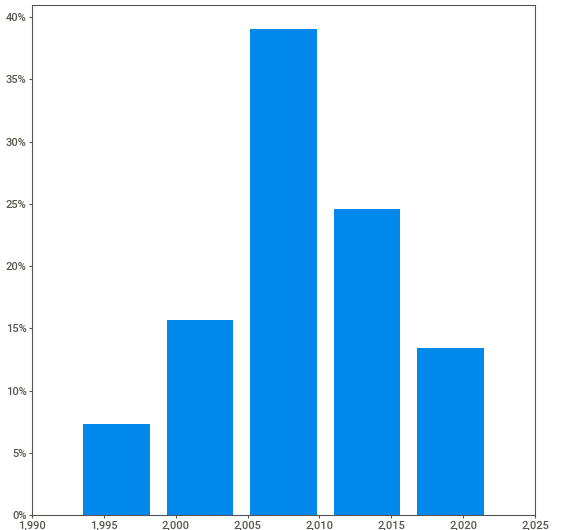
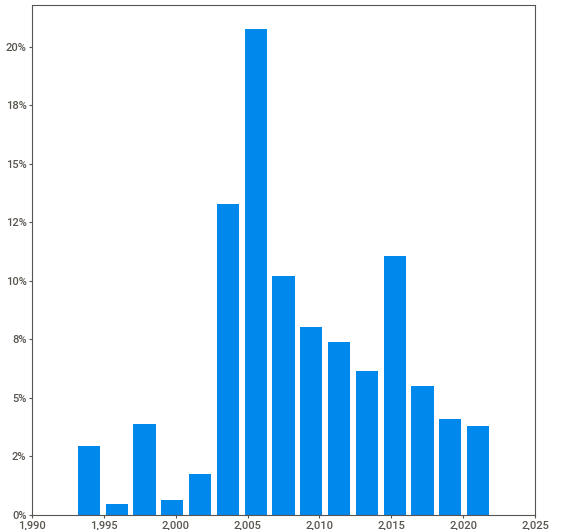
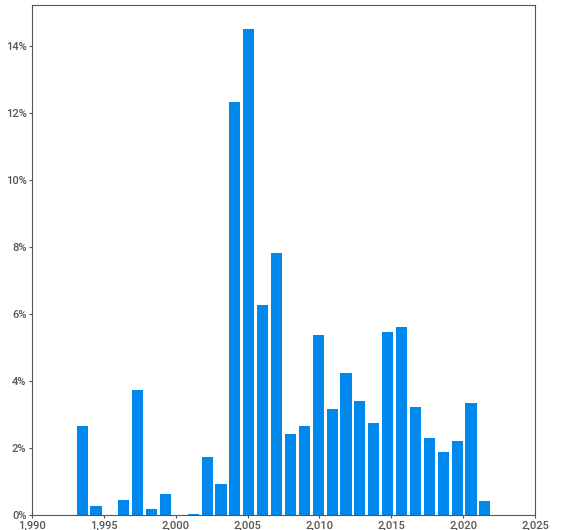
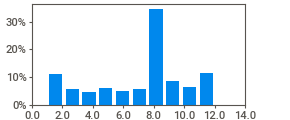
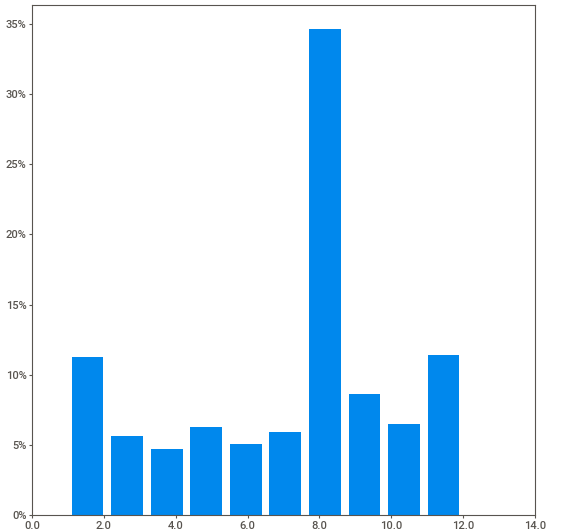
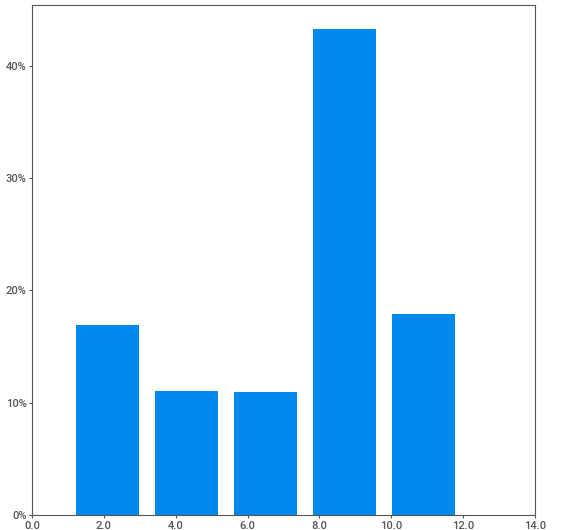
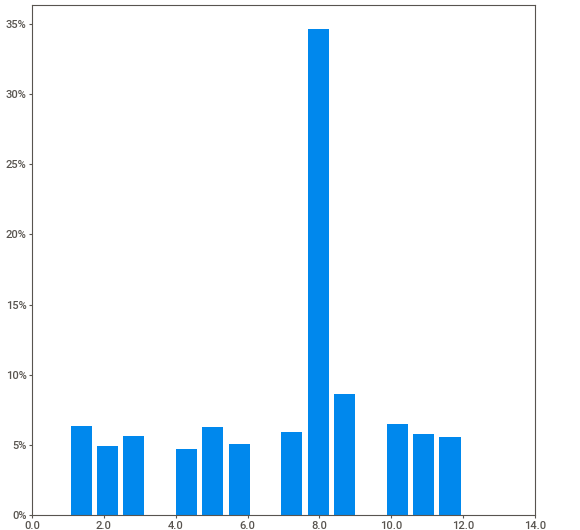
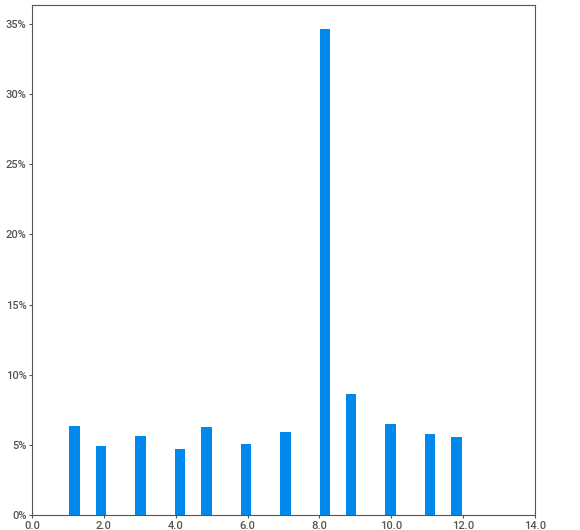
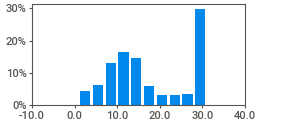
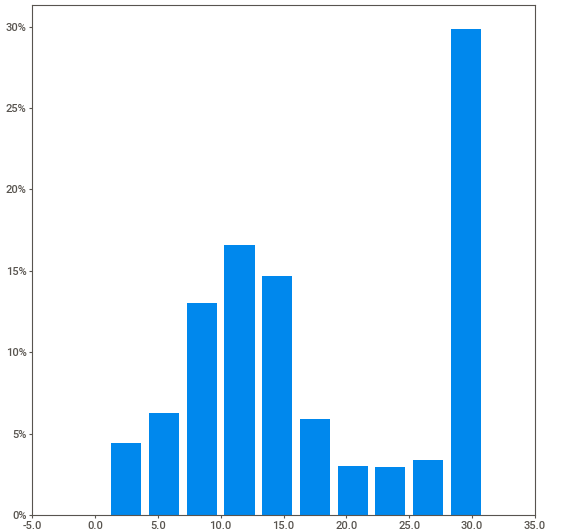
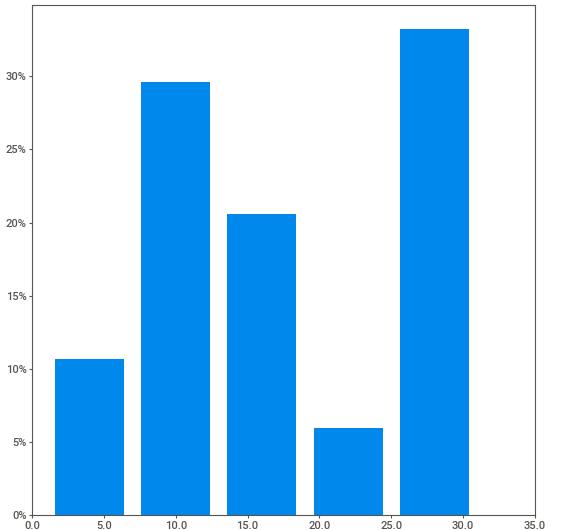
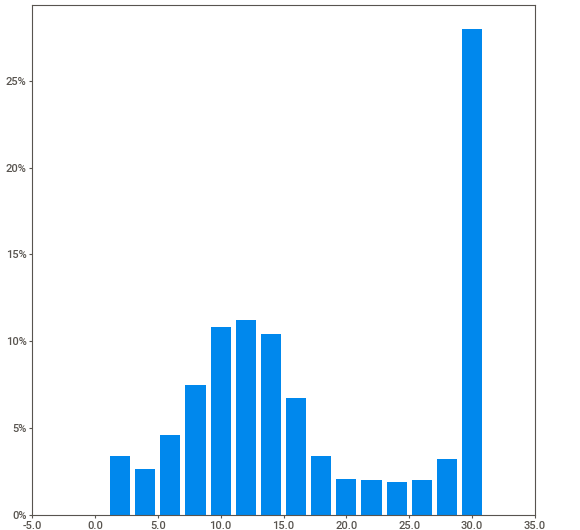
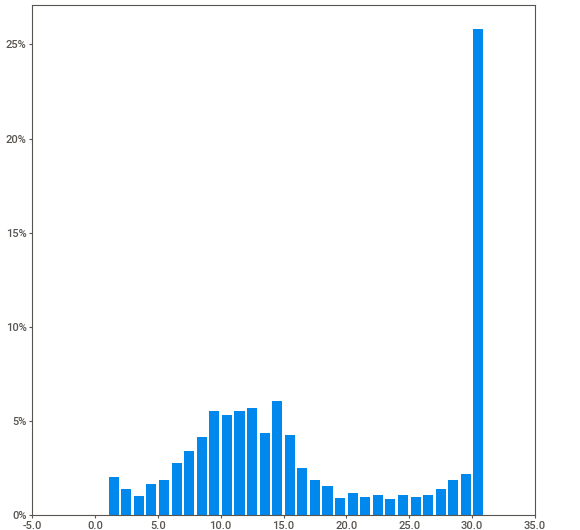
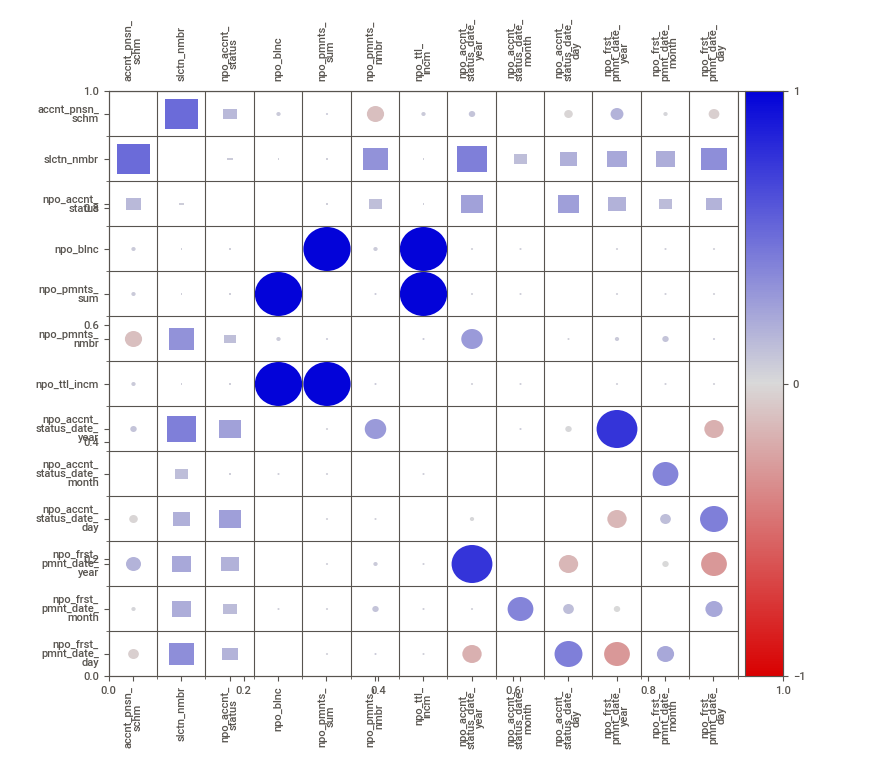
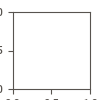

In [24]:
sv.analyze(npo_cntrbtrs_normed).show_notebook()


## Plots

<Axes: xlabel='npo_sum', ylabel='npo_operation_date_year'>

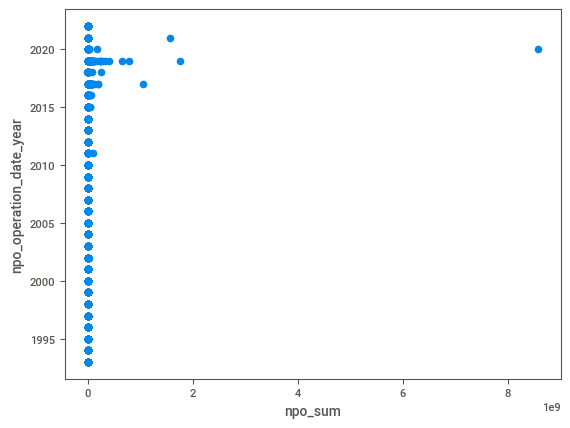

In [53]:
npo_trnsctns_normed.plot.scatter('npo_sum', 'npo_operation_date_year')


## Boxplot

<Axes: >

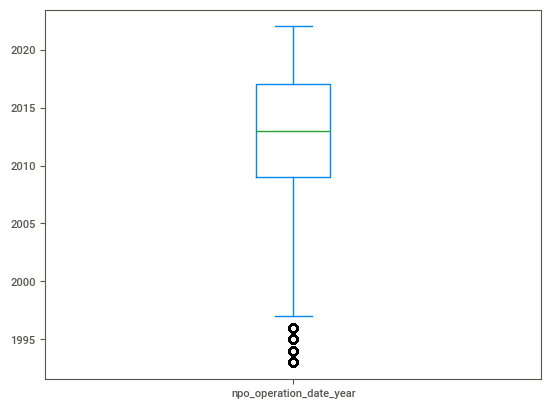

In [37]:
npo_trnsctns_normed['npo_operation_date_year'].plot.box()


## Cor

Кореляция по датафреймам

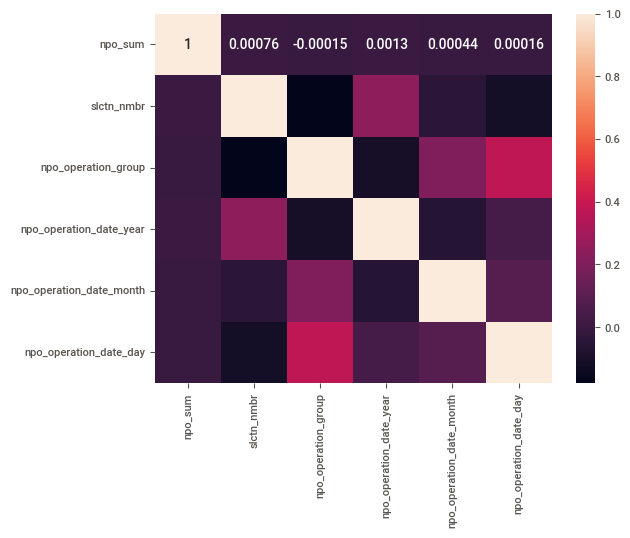

In [51]:
dataplot = sb.heatmap(
    npo_trnsctns_normed.drop('npo_accnt_id', axis=1).corr(),
    annot=True
)


In [80]:
npo_clnts_normed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230446 entries, 0 to 230445
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clnt_id     230446 non-null  object 
 1   gndr        230442 non-null  float64
 2   slctn_nmbr  230446 non-null  int64  
 3   brth_yr     230423 non-null  float64
 4   pstl_code   220185 non-null  float64
 5   city        230446 non-null  int64  
dtypes: float64(3), int64(2), object(1)
memory usage: 10.5+ MB


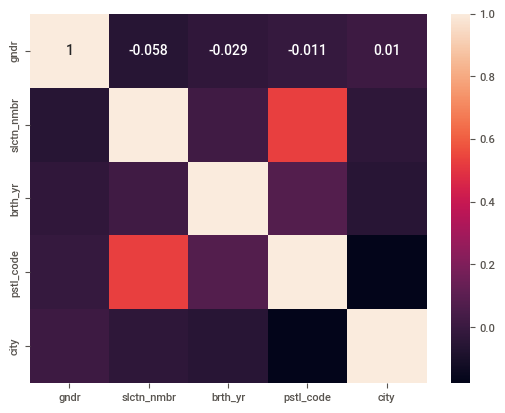

In [81]:
dataplot = sb.heatmap(
    npo_clnts_normed.drop(['clnt_id'], axis=1).corr(),
    annot=True
)


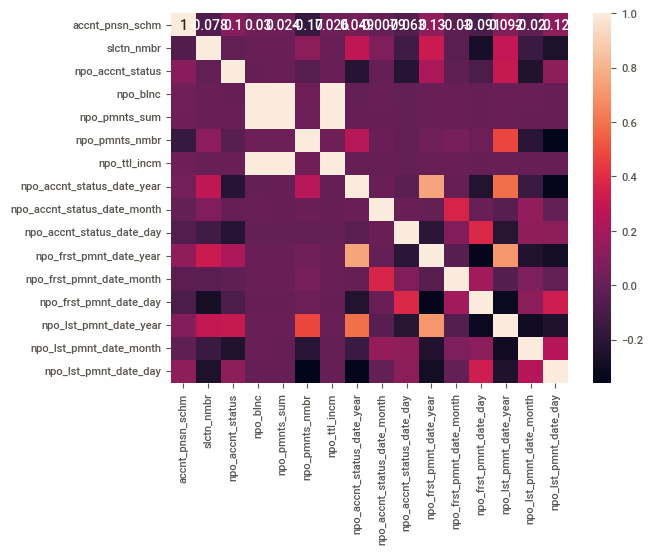

In [89]:
dataplot = sb.heatmap(
    npo_cntrbtrs_normed.drop(['npo_accnt_id', 'clnt_id'], axis=1).corr(),
    annot=True
)


# Remove_nan

Заполняем пустые ячейки

т.к. -1 не встречается не в одном датасете то используем его для абозначения nan

In [91]:
npo_trnsctns_fillna = npo_trnsctns_normed.fillna(-1)


In [92]:
npo_clnts_fillna = npo_clnts_normed.fillna(-1)


In [93]:
npo_cntrbtrs_fillna = npo_cntrbtrs_normed.fillna(-1)


# Save fillNa

Сохраняем датасеты с заполнеными пустыми значениями

озу, к сожалению, не всеобъемлющее

In [95]:
npo_trnsctns_fillna.to_csv('DATA/FilledNa/npo_trnsctns_fillna.csv')
npo_clnts_fillna.to_csv('DATA/FilledNa/npo_clnts_fillna.csv')
npo_cntrbtrs_fillna.to_csv('DATA/FilledNa/npo_cntrbtrs_fillna.csv')


# Join tabels by id acc

соединим таблицы по ключам ```npo_accnt_id``` и ```clnt_id``` и получаем таблицу all_in_one

соединим таблицы по ключам ```npo_accnt_id``` и ```clnt_id```

In [105]:
all_in_one = pd.merge(npo_trnsctns_fillna, npo_cntrbtrs_fillna, on='npo_accnt_id')


In [125]:
npo_clnts_fillna['clnt_id'] = npo_clnts_fillna['clnt_id']

# all_in_one = pd.merge(all_in_one, npo_clnts_fillna, on='npo_accnt_id')


In [124]:
npo_clnts_fillna = npo_clnts_fillna.drop('npo_accnt_id', axis=1)


In [127]:
all_in_one = pd.merge(all_in_one, npo_clnts_fillna, on='clnt_id')


# Save all in one

In [128]:
all_in_one.to_csv('DATA/all_in_one.csv')


# Remove not important col

удалим сильно-коррелирующие параметры и параметры коие не несут семантической целостности

In [136]:
not_important_cols = ['slctn_nmbr', 'slctn_nmbr_x', 'slctn_nmbr_y', 'client_id']


In [137]:
all_in_one_clear = all_in_one


In [138]:
for i in not_important_cols:
    if i in all_in_one_clear.columns:
        all_in_one_clear = all_in_one_clear.drop(i, axis=1)


# All in one clear save

In [378]:
all_in_one_clear.to_csv('DATA/all_in_one.csv', index=False)


# All in one graphs

In [2]:
all_in_one_clear = pd.read_csv('DATA/all_in_one.csv')


In [4]:
all_in_one_clear.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12328790 entries, 0 to 12328789
Data columns (total 27 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Unnamed: 0                   int64  
 1   npo_accnt_id                 object 
 2   npo_sum                      float64
 3   npo_operation_group          int64  
 4   npo_operation_date_year      int64  
 5   npo_operation_date_month     int64  
 6   npo_operation_date_day       int64  
 7   clnt_id                      object 
 8   accnt_pnsn_schm              float64
 9   npo_accnt_status             int64  
 10  npo_blnc                     float64
 11  npo_pmnts_sum                float64
 12  npo_pmnts_nmbr               float64
 13  npo_ttl_incm                 float64
 14  npo_accnt_status_date_year   int64  
 15  npo_accnt_status_date_month  int64  
 16  npo_accnt_status_date_day    int64  
 17  npo_frst_pmnt_date_year      float64
 18  npo_frst_pmnt_date_month     float64
 19

In [43]:
ids = ['clnt_id', 'npo_accnt_id']


## corr

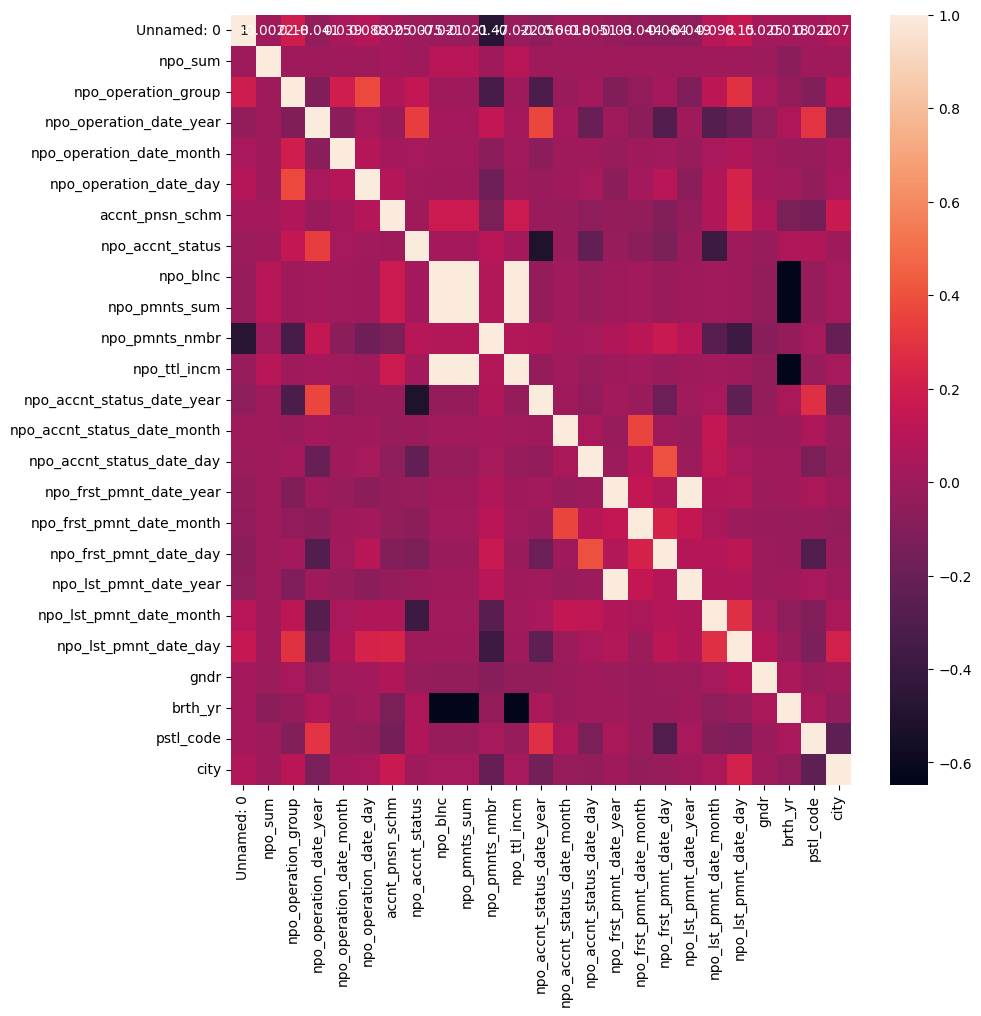

In [6]:
fig, ax = plt.subplots(
    figsize=(10, 10)
)
dataplot = sb.heatmap(
    all_in_one_clear.drop(ids, axis=1).corr(),
    annot=True,
    ax=ax
)


# Split on users

In [24]:
all_in_one_clear = pd.read_csv('DATA/all_in_one.csv')


In [25]:
all_in_one_clear = all_in_one_clear.drop('Unnamed: 0', axis=1)


In [26]:
clients = all_in_one_clear['clnt_id'].unique()


число юзеров

In [11]:
clients.shape


(224123,)

In [12]:
clients_series_example = all_in_one_clear.loc[all_in_one_clear['clnt_id']==clients[0]]


In [47]:
clients_series_example2 = all_in_one_clear.loc[all_in_one_clear['clnt_id'] == clients[1]]
clients_series_example3 = all_in_one_clear.loc[all_in_one_clear['clnt_id'] == clients[2]]
clients_series_example4 = all_in_one_clear.loc[all_in_one_clear['clnt_id'] == clients[3]]


In [ ]:
clients_sums = dict()
for i in clients[0:1000]:
    clients_sums[i] = all_in_one_clear.loc[all_in_one_clear['clnt_id'] == i]


In [15]:
import pickle
with open('Data/clients_sums.pkl', 'wb') as fp:
    pickle.dump(clients_sums, fp)


In [33]:
big_boys = list(filter(lambda a: a.shape[0] > 300, clients_sums.values()))
len(big_boys)


4

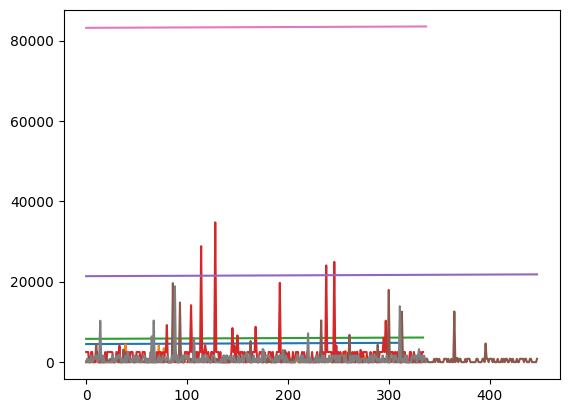

In [35]:
for i in big_boys:
    plt.plot(i['npo_sum'].reset_index())
# plt.xscale('log')
plt.show()


In [38]:
small_boys = list(filter(lambda a: a.shape[0] < 8, clients_sums.values()))
len(small_boys)


7

In [39]:
np.median([i.shape[0] for i in clients_sums.values()])


93.0

In [40]:
np.mean([i.shape[0] for i in clients_sums.values()])


104.319

In [41]:
np.std([i.shape[0] for i in clients_sums.values()])


64.96449213993749

In [13]:
clients_series_example


npo_accnt_id  npo_sum  npo_operation_group  \
0    0x05C7DF8BA2611640BE946E29CF20C6D2  1626.01                    0   
1    0x05C7DF8BA2611640BE946E29CF20C6D2  8394.05                    1   
2    0x05C7DF8BA2611640BE946E29CF20C6D2  1626.01                    0   
3    0x05C7DF8BA2611640BE946E29CF20C6D2  3124.91                    1   
4    0x05C7DF8BA2611640BE946E29CF20C6D2  1626.01                    0   
..                                  ...      ...                  ...   
155  0x05C7DF8BA2611640BE946E29CF20C6D2  1626.01                    0   
156  0x05C7DF8BA2611640BE946E29CF20C6D2  1626.01                    0   
157  0x05C7DF8BA2611640BE946E29CF20C6D2  1626.01                    0   
158  0x05C7DF8BA2611640BE946E29CF20C6D2  1626.01                    0   
159  0x05C7DF8BA2611640BE946E29CF20C6D2  1626.01                    0   

     npo_operation_date_year  npo_operation_date_month  \
0                       2011                        11   
1                       2010                         8   
2                       2007                         3   
3                       2016                         8   
4                       2016                        11   
..                       ...                       ...   
155                     2013                         4   
156                     2006                         4   
157                     2009                         8   
158                     2012                         9   
159                     2015                         5   

     npo_operation_date_day                             clnt_id  \
0                        11  0xE1494CDD114361469D1979AB0311F504   
1                        30  0xE1494CDD114361469D1979AB0311F504   
2                        12  0xE1494CDD114361469D1979AB0311F504   
3                        31  0xE1494CDD114361469D1979AB0311F504   
4                         5  0xE1494CDD114361469D1979AB0311F504   
..                      ...                                 ...   
155                       5  0xE1494CDD114361469D1979AB0311F504   
156                      13  0xE1494CDD114361469D1979AB0311F504   
157                       8  0xE1494CDD114361469D1979AB0311F504   
158                      14  0xE1494CDD114361469D1979AB0311F504   
159                       9  0xE1494CDD114361469D1979AB0311F504   

     accnt_pnsn_schm  npo_accnt_status  npo_blnc  ...  \
0               51.0                 0      -1.0  ...   
1               51.0                 0      -1.0  ...   
2               51.0                 0      -1.0  ...   
3               51.0                 0      -1.0  ...   
4               51.0                 0      -1.0  ...   
..               ...               ...       ...  ...   
155             51.0                 0      -1.0  ...   
156             51.0                 0      -1.0  ...   
157             51.0                 0      -1.0  ...   
158             51.0                 0      -1.0  ...   
159             51.0                 0      -1.0  ...   

     npo_frst_pmnt_date_year  npo_frst_pmnt_date_month  \
0                     2005.0                       8.0   
1                     2005.0                       8.0   
2                     2005.0                       8.0   
3                     2005.0                       8.0   
4                     2005.0                       8.0   
..                       ...                       ...   
155                   2005.0                       8.0   
156                   2005.0                       8.0   
157                   2005.0                       8.0   
158                   2005.0                       8.0   
159                   2005.0                       8.0   

     npo_frst_pmnt_date_day  npo_lst_pmnt_date_year  npo_lst_pmnt_date_month  \
0                      31.0                  2017.0                      2.0   
1                      31.0                  2017.0                      2.0   
2                      31.

In [45]:
clients_series_example.describe()


npo_sum  npo_operation_group  npo_operation_date_year  \
count    160.000000           160.000000               160.000000   
mean    2423.262687             0.131250              2010.962500   
std     5052.880263             0.338734                 3.371892   
min      145.300000             0.000000              2005.000000   
25%     1626.010000             0.000000              2008.000000   
50%     1626.010000             0.000000              2011.000000   
75%     1626.010000             0.000000              2014.000000   
max    61137.390000             1.000000              2017.000000   

       npo_operation_date_month  npo_operation_date_day  accnt_pnsn_schm  \
count                160.000000              160.000000            160.0   
mean                   6.743750               12.175000             51.0   
std                    3.329394                7.649187              0.0   
min                    1.000000                1.000000             51.0   
25%                    4.000000                7.000000             51.0   
50%                    7.500000               11.000000             51.0   
75%                    9.000000               14.000000             51.0   
max                   12.000000               31.000000             51.0   

       npo_accnt_status  npo_blnc  npo_pmnts_sum  npo_pmnts_nmbr  ...  \
count             160.0     160.0   1.600000e+02           160.0  ...   
mean                0.0      -1.0   2.827634e+05           139.0  ...   
std                 0.0       0.0   5.839042e-11             0.0  ...   
min                 0.0      -1.0   2.827634e+05           139.0  ...   
25%                 0.0      -1.0   2.827634e+05           139.0  ...   
50%                 0.0      -1.0   2.827634e+05           139.0  ...   
75%                 0.0      -1.0   2.827634e+05           139.0  ...   
max                 0.0      -1.0   2.827634e+05           139.0  ...   

       npo_frst_pmnt_date_year  npo_frst_pmnt_date_month  \
count                    160.0                     160.0   
mean                    2005.0                       8.0   
std                        0.0                       0.0   
min                     2005.0                       8.0   
25%                     2005.0                       8.0   
50%                     2005.0                       8.0   
75%                     2005.0                       8.0   
max                     2005.0                       8.0   

       npo_frst_pmnt_date_day  npo_lst_pmnt_date_year  \
count                   160.0                   160.0   
mean                     31.0                  2017.0   
std                       0.0                     0.0   
min                      31.0                  2017.0   
25%                      31.0                  2017.0   
50%                      31.0                  2017.0   
75%                      31.0                  2017.0   
max                      31.0                  2017.0   

       npo_lst_pmnt_date_month  npo_lst_pmnt_date_day   gndr  brth_yr  \
count                    160.0                  160.0  160.0    160.0   
mean                       2.0                    5.0    0.0   1964.0   
std                        0.0                    0.0    0.0      0.0   
min                        2.0                    5.0    0.0   1964.0   
25%                        2.0                    5.0    0.0   1964.0   
50%                        2.0                    5.0    0.0   1964.0   
75%                        2.0                    5.0    0.0   1964.0   
max                        2.0                    5.0    0.0   1964.0   

       pstl_code   city  
count      160.0  160.0  
mean    162616.0    0.0  
std          0.0    0.0  
min     162616.0    0.0  
25%     162616.0    0.0  
50%     162616.0    0.0  
75%     162616.0    0.0  
max     162616.0    0.0  

[8 rows x 24 columns]

In [ ]:
fig, ax = plt.subplots(
    figsize=(10, 10)
)
dataplot = sb.heatmap(
    clients_series_example.drop(ids, axis=1).corr(),
    annot=True,
    ax=ax
)


c:\Users\Mike\Desktop\Hackaton2023\HT\lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


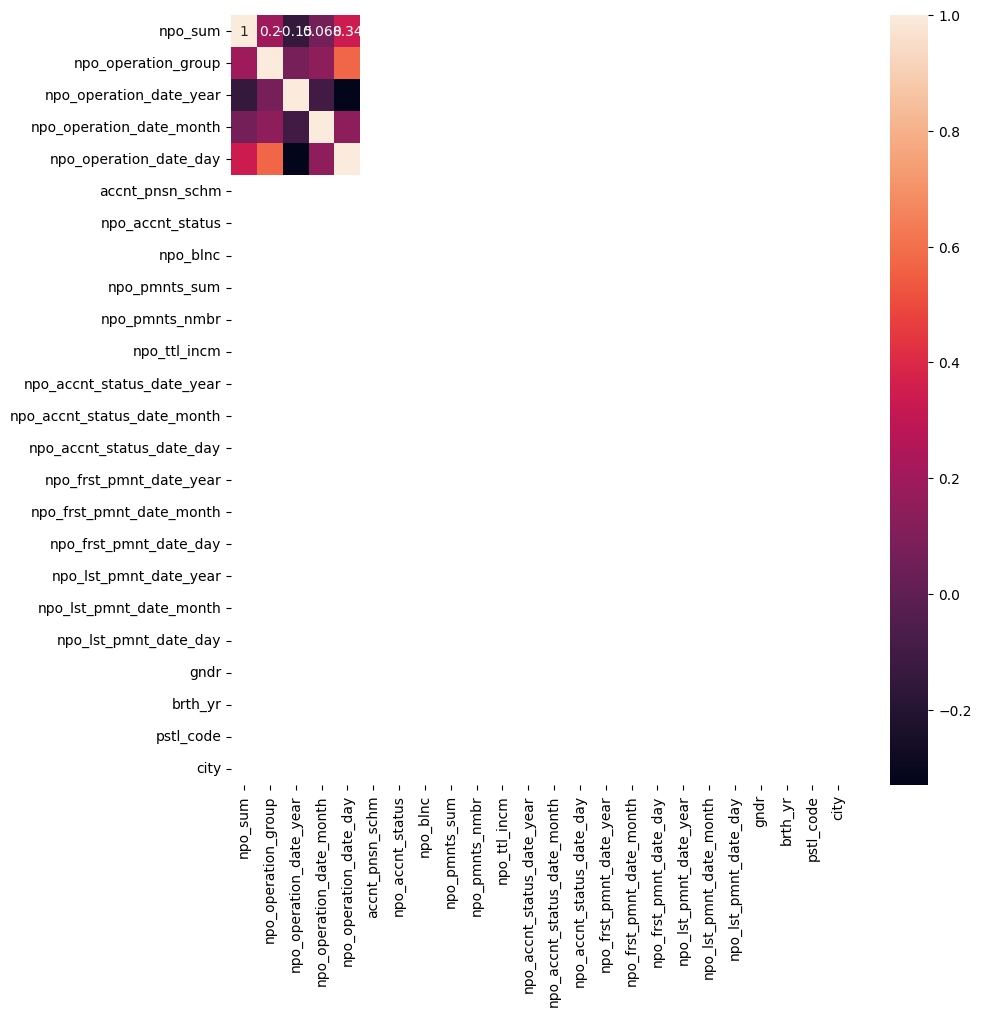

In [44]:
fig, ax = plt.subplots(
    figsize=(10, 10)
)
dataplot = sb.heatmap(
    clients_series_example.drop(ids, axis=1).corr(),
    annot=True,
    ax=ax
)


c:\Users\Mike\Desktop\Hackaton2023\HT\lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


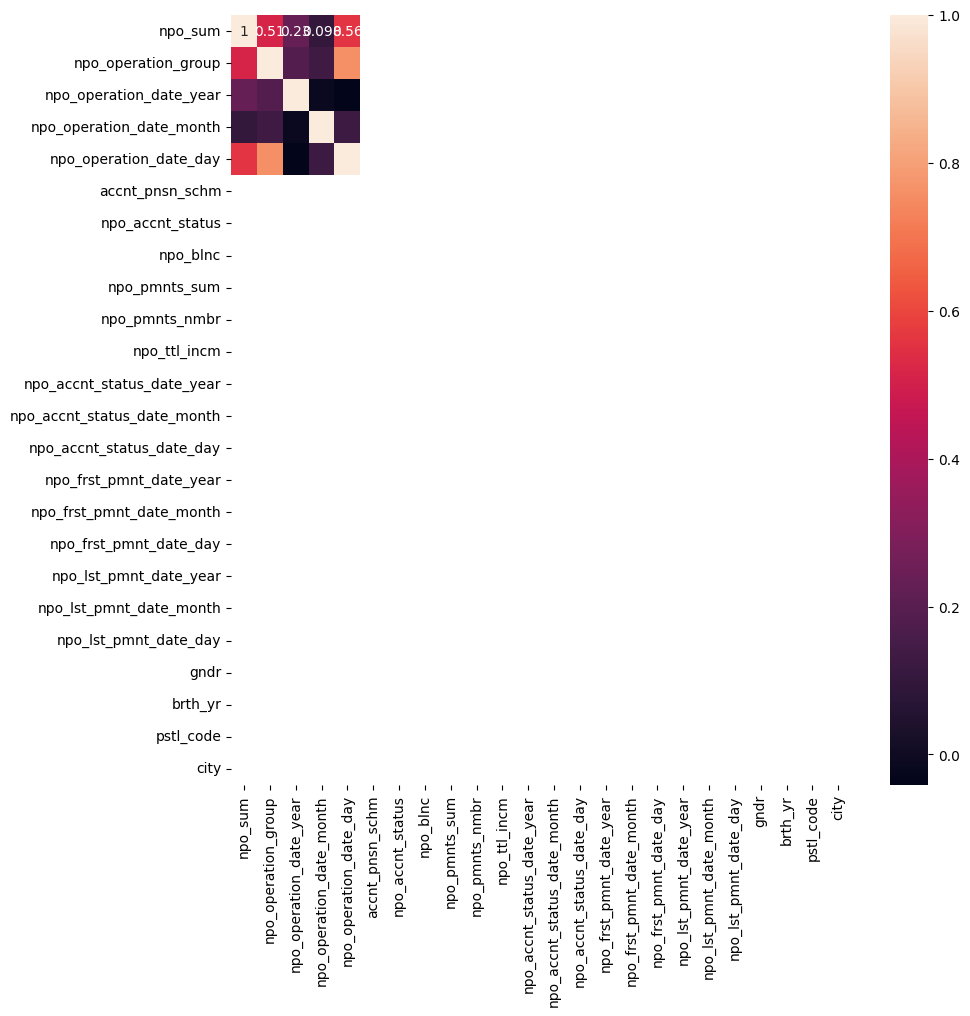

In [48]:
fig, ax = plt.subplots(
    figsize=(10, 10)
)
dataplot = sb.heatmap(
    clients_series_example2.drop(ids, axis=1).corr(),
    annot=True,
    ax=ax
)


c:\Users\Mike\Desktop\Hackaton2023\HT\lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


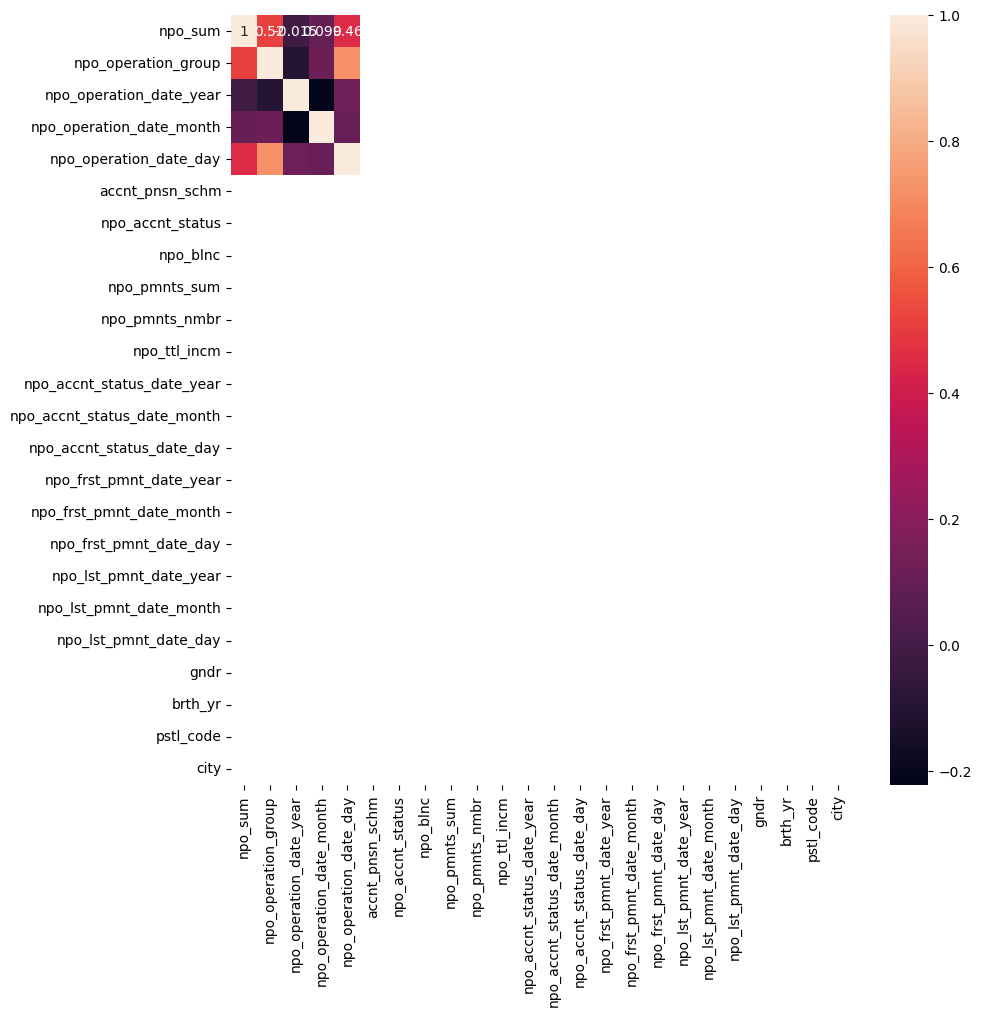

In [49]:
fig, ax = plt.subplots(
    figsize=(10, 10)
)
dataplot = sb.heatmap(
    clients_series_example3.drop(ids, axis=1).corr(),
    annot=True,
    ax=ax
)


# Try to create 1d array user

```create_vector_user``` - ф-ция для представления (преобразования) истории пользователя в вектор.

In [11]:
def create_vector_user(user_table):
  important_series_columns_for_vector = [
      'npo_sum',
      'npo_operation_group',
      'npo_operation_date_year',
      'npo_operation_date_month',
      'npo_operation_date_day'
  ]
  important_constant_columns_for_voctor = ['accnt_pnsn_schm',
                                           'npo_accnt_status', 'npo_blnc', 'npo_pmnts_sum', 'npo_pmnts_nmbr',
                                           'npo_ttl_incm', 'npo_accnt_status_date_year',
                                           'npo_accnt_status_date_month', 'npo_accnt_status_date_day',
                                           'npo_frst_pmnt_date_year', 'npo_frst_pmnt_date_month',
                                           'npo_frst_pmnt_date_day', 'npo_lst_pmnt_date_year',
                                           'npo_lst_pmnt_date_month', 'npo_lst_pmnt_date_day', 'gndr', 'brth_yr',
                                           'pstl_code', 'city'
                                           ]
  constant_vector_params = user_table.loc[:, important_constant_columns_for_voctor].describe().loc['mean'].to_numpy()
  series_vector_describe = user_table.loc[:, important_series_columns_for_vector].describe().T
  series_vector_params = series_vector_describe.loc[:, ['mean', 'std', 'min', 'max']].to_numpy().reshape(20, )
  # print(series_vector_params)
  # np.append(series_vector_params, constant_vector_params)
  return np.insert(np.append(series_vector_params, constant_vector_params), 0, np.mean(series_vector_describe['count']))


In [87]:
create_vector_user(clients_series_example3)


array([ 7.20000000e+01,  1.59361111e+02,  1.71970521e+02,  2.70200000e+01,
        1.15026000e+03,  6.94444444e-02,  2.55992346e-01,  0.00000000e+00,
        1.00000000e+00,  2.00581944e+03,  1.67270035e+00,  2.00300000e+03,
        2.00900000e+03,  6.73611111e+00,  3.46407338e+00,  1.00000000e+00,
        1.20000000e+01,  1.12638889e+01,  5.25140640e+00,  1.00000000e+00,
        3.10000000e+01,  1.30000000e+01,  0.00000000e+00, -1.00000000e+00,
        9.06504000e+03,  6.70000000e+01,  2.40906000e+03,  2.00900000e+03,
        2.00000000e+00,  1.90000000e+01,  2.00300000e+03,  9.00000000e+00,
        1.00000000e+00,  2.00900000e+03,  2.00000000e+00,  8.00000000e+00,
        1.00000000e+00,  1.96000000e+03,  3.94071000e+05,  0.00000000e+00])

In [9]:
with open('Data/clients_sums.pkl', 'rb') as fp:
    clients_sums = pickle.load(fp)


In [ ]:
list(clients_sums.values())['']


In [15]:
users_multiple = np.array(list(map(create_vector_user, list(clients_sums.values()))))


In [16]:
with open('DATA/users_multiple.pkl', 'wb') as fp:
    pickle.dump(users_multiple, fp)


# Clusterisation

In [38]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA


In [91]:
data_users_vectors = pd.DataFrame(users_multiple, columns=['freq', 'npo_sum_mean', 'npo_sum_std', 'npo_sum_min', 'npo_sum_max', 
                                      'npo_operation_group_mean', 'npo_operation_group_std', 'npo_operation_group_min', 'npo_operation_group_max', 
                                      'npo_operation_date_year_mean', 'npo_operation_date_year_std', 'npo_operation_date_year_min', 
                                      'npo_operation_date_year_max', 
                                      'npo_operation_date_month_mean', 'npo_operation_date_month_std', 'npo_operation_date_month_min', 'npo_operation_date_month_max',
                                      'npo_operation_date_day_mean', 'npo_operation_date_day_std', 'npo_operation_date_day_min', 'npo_operation_date_day_max',
                                      'accnt_pnsn_schm',
                                      'npo_accnt_status', 'npo_blnc', 'npo_pmnts_sum', 'npo_pmnts_nmbr',
                                      'npo_ttl_incm', 'npo_accnt_status_date_year',
                                      'npo_accnt_status_date_month', 'npo_accnt_status_date_day',
                                      'npo_frst_pmnt_date_year', 'npo_frst_pmnt_date_month',
                                      'npo_frst_pmnt_date_day', 'npo_lst_pmnt_date_year',
                                      'npo_lst_pmnt_date_month', 'npo_lst_pmnt_date_day', 'gndr', 'brth_yr',
                                      'pstl_code', 'city'
                                      ])


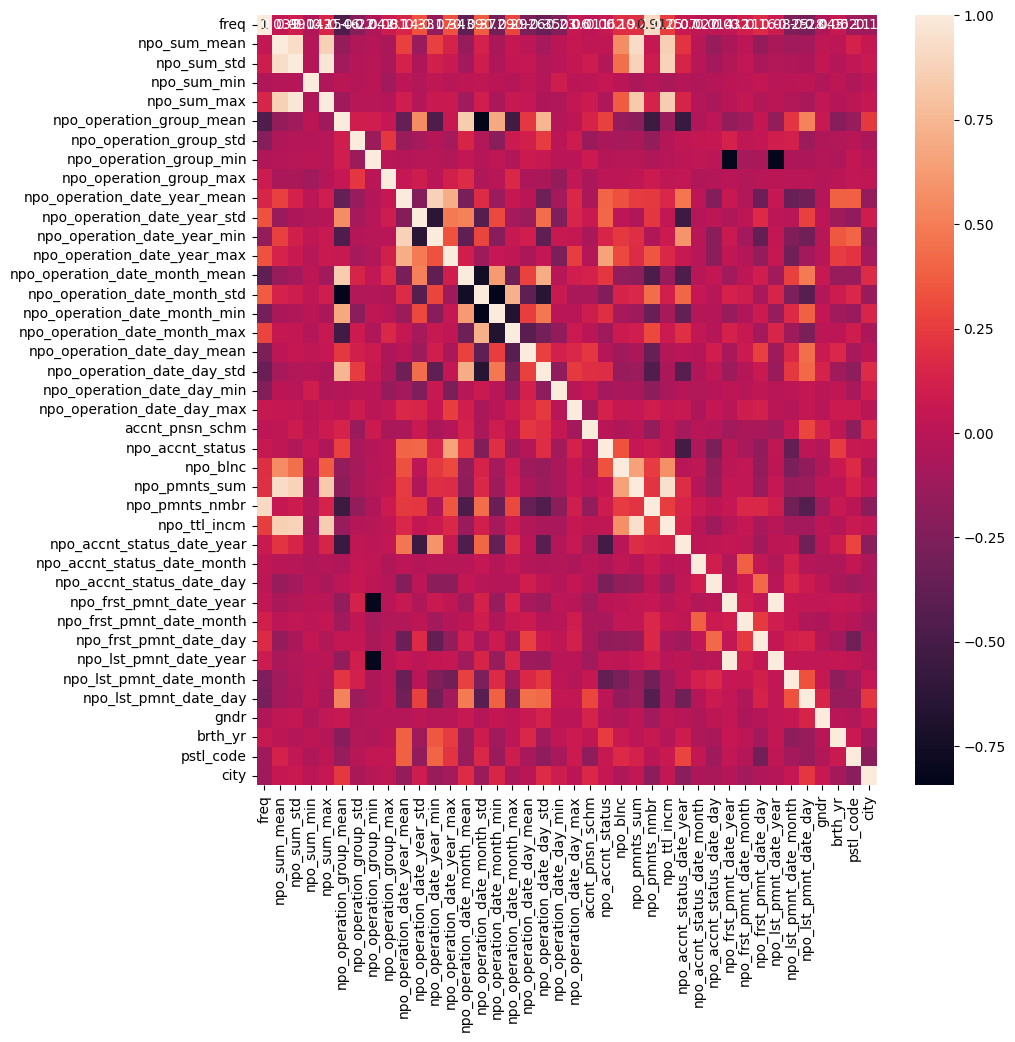

In [93]:
fig, ax = plt.subplots(
    figsize=(10, 10)
)
dataplot = sb.heatmap(
    data_users_vectors.corr(),
    annot=True,
    ax=ax
)


([<matplotlib.axis.XTick at 0x263ffb5d9d0>,
 [Text(0, 0, '2'),
  Text(1, 0, '3'),
  Text(2, 0, '4'),
  Text(3, 0, '5'),
  Text(4, 0, '6'),
  Text(5, 0, '7'),
  Text(6, 0, '8'),
  Text(7, 0, '9'),
  Text(8, 0, '10')])

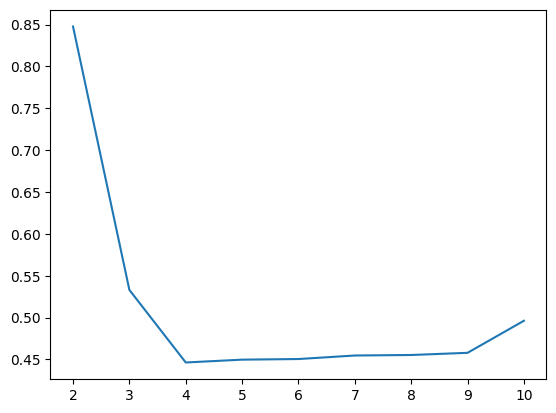

In [95]:
ss = []
for i in range(2, 11):
    ss.append(silhouette_score(users_multiple, AgglomerativeClustering(i).fit_predict(users_multiple)))
plt.plot(ss)
plt.xticks(range(0, 9), range(2, 11))


c:\Users\Mike\Desktop\Hackaton2023\HT\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Mike\Desktop\Hackaton2023\HT\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Mike\Desktop\Hackaton2023\HT\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Mike\Desktop\Hackaton2023\HT\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` wi

([<matplotlib.axis.XTick at 0x2636ab4e730>,
 [Text(0, 0, '2'),
  Text(1, 0, '3'),
  Text(2, 0, '4'),
  Text(3, 0, '5'),
  Text(4, 0, '6'),
  Text(5, 0, '7'),
  Text(6, 0, '8'),
  Text(7, 0, '9'),
  Text(8, 0, '10')])

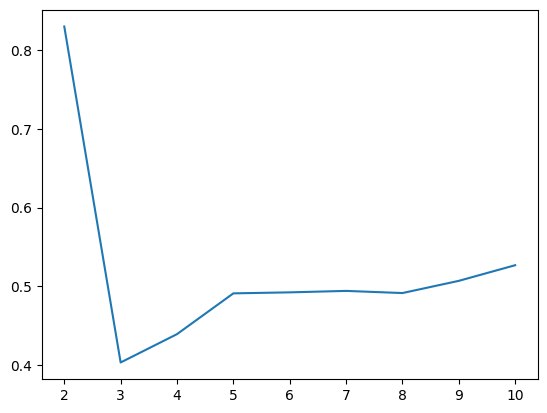

In [89]:
ss = []
for i in range(2, 11):
    ss.append(silhouette_score(users_multiple, KMeans(i).fit_predict(users_multiple)))
plt.plot(ss)
plt.xticks(range(0, 9), range(2, 11))


# Get users wo pensia

Выделим только взносы, исключая выплаты

In [14]:
all_in_one_clear = pd.read_csv('DATA/all_in_one.csv')
try:
    all_in_one_clear = all_in_one_clear.drop('Unnamed: 0', axis=1)
except:
    print('all')
clients = all_in_one_clear['clnt_id'].unique()



all


clients_sums_wo_pensia - описания клиентов с удалёнными выплатами им

In [ ]:
clients_sums_wo_pensia = dict()
for i in clients[0:3000]:
    d = all_in_one_clear.loc[(all_in_one_clear['clnt_id'] == i) & (all_in_one_clear['npo_sum'] > 0)]
    if d.shape[0] > 3:
        clients_sums_wo_pensia[i] = d


In [ ]:
with open('DATA/clients_sums_wo_pensia_pay_back.pkl', 'wb') as fp:
    pickle.dump(clients_sums_wo_pensia, fp)


clients_sums_wo_pensia_2 - описания клиентов не получающих выплаты

In [35]:
clients_sums_wo_pensia_2 = dict()
for i in clients[0:3000]:
    d = all_in_one_clear.loc[(all_in_one_clear['clnt_id'] == i)]
    if d.shape[0] > 3 and d['npo_sum'].min() > 0:
        clients_sums_wo_pensia[i] = d


# Clusterization wo pensia

In [40]:
users_multiple_wo_pensia = np.array(list(map(create_vector_user, list(clients_sums_wo_pensia.values()))))


c:\Users\Mike\Desktop\Hackaton2023\HT\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Mike\Desktop\Hackaton2023\HT\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Mike\Desktop\Hackaton2023\HT\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Mike\Desktop\Hackaton2023\HT\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` wi

([<matplotlib.axis.XTick at 0x246f478d730>,
 [Text(0, 0, '2'),
  Text(1, 0, '3'),
  Text(2, 0, '4'),
  Text(3, 0, '5'),
  Text(4, 0, '6'),
  Text(5, 0, '7'),
  Text(6, 0, '8'),
  Text(7, 0, '9'),
  Text(8, 0, '10')])

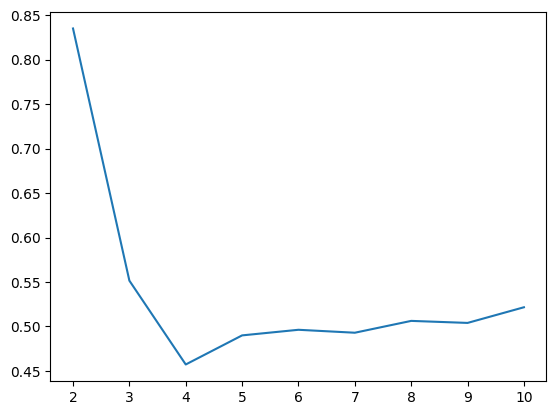

In [60]:
ss = []
for i in range(2, 11):
    ss.append(silhouette_score(users_multiple_wo_pensia, KMeans(i).fit_predict(users_multiple_wo_pensia)))
plt.plot(ss)
plt.xticks(range(0, 9), range(2, 11))


([<matplotlib.axis.XTick at 0x246ec49e550>,
 [Text(0, 0, '2'),
  Text(1, 0, '3'),
  Text(2, 0, '4'),
  Text(3, 0, '5'),
  Text(4, 0, '6'),
  Text(5, 0, '7'),
  Text(6, 0, '8'),
  Text(7, 0, '9'),
  Text(8, 0, '10')])

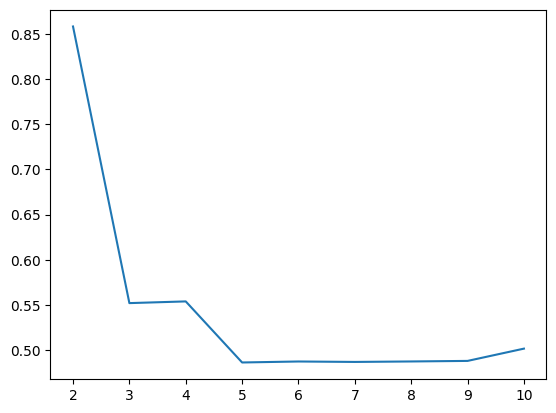

In [61]:
ss = []
for i in range(2, 11):
    ss.append(silhouette_score(users_multiple_wo_pensia, AgglomerativeClustering(
        i).fit_predict(users_multiple_wo_pensia)))
plt.plot(ss)
plt.xticks(range(0, 9), range(2, 11))


# Projection wo pensia

In [62]:
kmean = KMeans(n_clusters=4)
clusters_kmean = kmean.fit_predict(users_multiple_wo_pensia)
ac = AgglomerativeClustering(n_clusters=4)
clusters_ac = ac.fit_predict(users_multiple_wo_pensia)


c:\Users\Mike\Desktop\Hackaton2023\HT\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [63]:
d2_kmean = PCA(n_components=2).fit_transform(users_multiple_wo_pensia, clusters_kmean)
d3_kmean = PCA(n_components=3).fit_transform(users_multiple_wo_pensia, clusters_kmean)
d2_ac = PCA(n_components=2).fit_transform(users_multiple_wo_pensia, clusters_ac)
d3_ac = PCA(n_components=3).fit_transform(users_multiple_wo_pensia, clusters_ac)


Text(0.5, 1.0, 'ac')

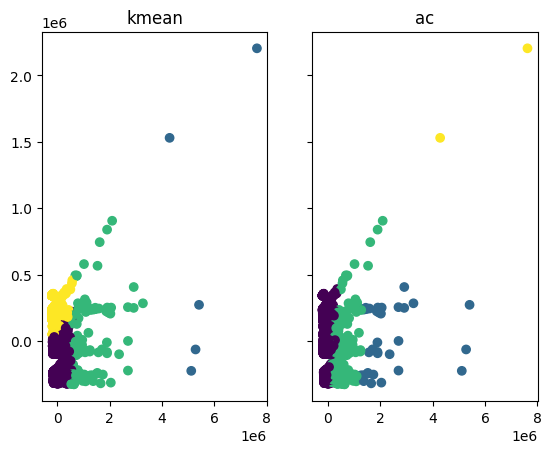

In [64]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.scatter(d2_kmean[:, 0], d2_kmean[:, 1], c=clusters_kmean)
ax1.set_title('kmean')
ax2.scatter(d2_ac[:, 0], d2_ac[:, 1], c=clusters_ac)
ax2.set_title('ac')


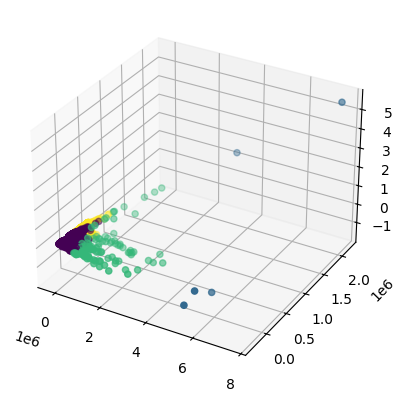

In [65]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(d3_kmean[:,0], d3_kmean[:,1], d3_kmean[:,2], c=clusters_kmean)

# Projection

In [96]:
kmean = KMeans(n_clusters=4)
clusters_kmean = kmean.fit_predict(users_multiple)
ac = AgglomerativeClustering(n_clusters=4)
clusters_ac = ac.fit_predict(users_multiple)


c:\Users\Mike\Desktop\Hackaton2023\HT\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [100]:
d2_kmean = PCA(n_components=2).fit_transform(users_multiple, clusters_kmean)
d3_kmean = PCA(n_components=3).fit_transform(users_multiple, clusters_kmean)
d2_ac = PCA(n_components=2).fit_transform(users_multiple, clusters_ac)
d3_ac = PCA(n_components=3).fit_transform(users_multiple, clusters_ac)


Text(0.5, 1.0, 'ac')

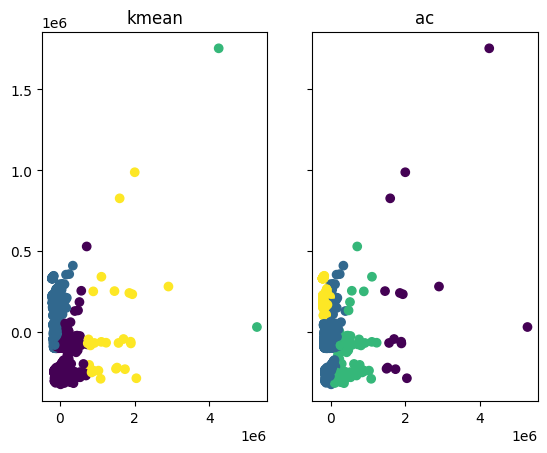

In [105]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.scatter(d2_kmean[:, 0], d2_kmean[:, 1], c=clusters_kmean)
ax1.set_title('kmean')
ax2.scatter(d2_ac[:, 0], d2_ac[:, 1], c=clusters_ac)
ax2.set_title('ac')


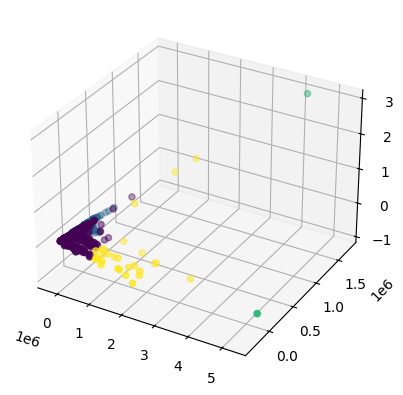

In [106]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(d3_kmean[:,0], d3_kmean[:,1], d3_kmean[:,2], c=clusters_kmean)

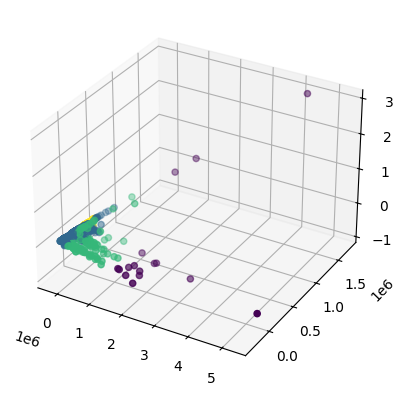

In [107]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(d3_ac[:,0], d3_ac[:,1], d3_ac[:,2], c=clusters_ac)

# Classification wo pensia

In [101]:
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE


In [85]:
cw = class_weight.compute_class_weight(class_weight='balanced',
                                       classes=pd.unique(clusters_kmean),
                                       y=clusters_kmean)
cw.shape


(4,)

In [104]:
u, c = SMOTE(k_neighbors=4).fit_resample(users_multiple_wo_pensia, clusters_kmean)


In [106]:
X_train, X_test, y_train, y_test = train_test_split(u, c, shuffle=True, stratify=c, test_size=0.25)


In [107]:
knn = KNeighborsClassifier(n_neighbors=4).fit(X_train, y_train)
pred_res = knn.predict(X_test)


In [108]:
print(classification_report(pred_res, y_test))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       451
           1       1.00      1.00      1.00       454
           2       1.00      0.99      1.00       458
           3       1.00      1.00      1.00       454

    accuracy                           1.00      1817
   macro avg       1.00      1.00      1.00      1817
weighted avg       1.00      1.00      1.00      1817



# Classification

In [114]:
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report


In [110]:
cw = class_weight.compute_class_weight(class_weight='balanced',
                                       classes=pd.unique(clusters_ac),
                                       y=clusters_ac)
cw.shape


(4,)

In [126]:
X_train, X_test, y_train, y_test = train_test_split(users_multiple, clusters_ac, shuffle=True, stratify=clusters_ac, test_size=0.25)


In [127]:
knn = KNeighborsClassifier(n_neighbors=10).fit(X_train, y_train)
pred_res = knn.predict(X_test)


In [128]:
print(classification_report(pred_res, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.99      0.97      0.98       148
           2       0.82      1.00      0.90        23
           3       1.00      0.97      0.99        75

    accuracy                           0.97       250
   macro avg       0.95      0.98      0.97       250
weighted avg       0.98      0.97      0.97       250



# Classes users semantick description

In [131]:
classes_users_checkout = pd.DataFrame(X_test, columns=['freq', 'npo_sum_mean', 'npo_sum_std', 'npo_sum_min', 'npo_sum_max',
                                                           'npo_operation_group_mean', 'npo_operation_group_std', 'npo_operation_group_min', 'npo_operation_group_max',
                                                           'npo_operation_date_year_mean', 'npo_operation_date_year_std', 'npo_operation_date_year_min',
                                                           'npo_operation_date_year_max',
                                                           'npo_operation_date_month_mean', 'npo_operation_date_month_std', 'npo_operation_date_month_min', 'npo_operation_date_month_max',
                                                           'npo_operation_date_day_mean', 'npo_operation_date_day_std', 'npo_operation_date_day_min', 'npo_operation_date_day_max',
                                                           'accnt_pnsn_schm',
                                                           'npo_accnt_status', 'npo_blnc', 'npo_pmnts_sum', 'npo_pmnts_nmbr',
                                                           'npo_ttl_incm', 'npo_accnt_status_date_year',
                                                           'npo_accnt_status_date_month', 'npo_accnt_status_date_day',
                                                           'npo_frst_pmnt_date_year', 'npo_frst_pmnt_date_month',
                                                           'npo_frst_pmnt_date_day', 'npo_lst_pmnt_date_year',
                                                           'npo_lst_pmnt_date_month', 'npo_lst_pmnt_date_day', 'gndr', 'brth_yr',
                                                           'pstl_code', 'city'
                                                           ])
classes_users_checkout['class'] = y_test


In [159]:
class3 = classes_users_checkout.loc[classes_users_checkout['class'] == 3].describe(
).loc['mean']
class2 = classes_users_checkout.loc[classes_users_checkout['class'] == 2].describe(
).loc['mean']
class1 = classes_users_checkout.loc[classes_users_checkout['class'] == 1].describe(
).loc['mean']
class0 = classes_users_checkout.loc[classes_users_checkout['class'] == 0].describe().loc['mean']


In [160]:
classes_users_checkout.loc[classes_users_checkout['class'] == 0].describe()

freq  npo_sum_mean   npo_sum_std  npo_sum_min   npo_sum_max  \
count    4.000000      4.000000      4.000000        4.000       4.00000   
mean   121.500000  29083.550009  38529.861609     -196.885  225808.80000   
std     11.269428  20202.039122  31744.736194      393.770  196619.59951   
min    111.000000  11927.026216  12884.239687     -787.540   62098.81000   
25%    112.500000  12609.190957  14157.654631     -196.885   90779.61250   
50%    120.500000  25633.981985  30570.999082       -0.000  172498.00000   
75%    129.500000  42108.341037  54943.206059        0.000  307527.18750   
max    134.000000  53139.209851  80093.208584       -0.000  496140.39000   

       npo_operation_group_mean  npo_operation_group_std  \
count                  4.000000                 4.000000   
mean                   0.101147                 0.300214   
std                    0.027155                 0.036123   
min                    0.070796                 0.257627   
25%                    0.085267                 0.280114   
50%                    0.099733                 0.300472   
75%                    0.115613                 0.320573   
max                    0.134328                 0.342284   

       npo_operation_group_min  npo_operation_group_max  \
count                      4.0                      4.0   
mean                       0.0                      1.0   
std                        0.0                      0.0   
min                        0.0                      1.0   
25%                        0.0                      1.0   
50%                        0.0                      1.0   
75%                        0.0                      1.0   
max                        0.0                      1.0   

       npo_operation_date_year_mean  ...  npo_frst_pmnt_date_month  \
count                      4.000000  ...                  4.000000   
mean                    2016.128015  ...                  9.500000   
std                        1.760006  ...                  1.290994   
min                     2013.820896  ...                  8.000000   
25%                     2015.232568  ...                  8.750000   
50%                     2016.513725  ...                  9.500000   
75%                     2017.409172  ...                 10.250000   
max                     2017.663717  ...                 11.000000   

       npo_frst_pmnt_date_day  npo_lst_pmnt_date_year  \
count                4.000000                    4.00   
mean                10.500000                 2020.75   
std                  3.109126                    1.50   
min                  6.000000                 2019.00   
25%                  9.750000                 2019.75   
50%                 11.500000                 2021.00   
75%                 12.250000                 2022.00   
max                 13.000000                 2022.00   

       npo_lst_pmnt_date_month  npo_lst_pmnt_date_day  gndr      brth_yr  \
count                 4.000000               4.000000  4.00     4.000000   
mean                  2.500000               7.500000  0.75  1966.000000   
std                   1.914854               3.316625  0.50     8.406347   
min                   1.000000               3.000000  0.00  1957.000000   
25%                   1.000000               6.000000  0.75  1960.000000   
50%                   2.000000               8.500000  1.00  1966.000000   
75%                   3.500000              10.000000  1.00  1972.000000   
max                   5.000000              10.000000  1.00  1975.000000   

           pstl_code     city  class  
count       4.000000  4.00000    4.0  
mean   324988.750000  0.50000    0.0  
std    255686.159825  0.57735    0.0  
min    107241.000000  0.00000    0.0  
25%    114990.750000  0.00000    0.0  
50%    283826.000000  0.50000    0.0  
75%    493824.000000  1.00000    0.0  
max    625062.000000  1.00000    0.0  

[8 rows x 41 columns]

In [143]:
pd.DataFrame({'class_0': class0, 'class_1': class1, 'class_2': class2, 'class_3': class3,})

class_0        class_1        class_2  \
freq                           1.215000e+02      98.020690     153.785714   
npo_sum_mean                   2.908355e+04    1307.899812    3457.573103   
npo_sum_std                    3.852986e+04    1218.887530    3250.970722   
npo_sum_min                   -1.968850e+02      27.208966      25.930714   
npo_sum_max                    2.258088e+05    8435.688828   22905.808571   
npo_operation_group_mean       1.011475e-01       0.213906       0.098576   
npo_operation_group_std        3.002140e-01       0.310913       0.297155   
npo_operation_group_min        0.000000e+00       0.000000       0.000000   
npo_operation_group_max        1.000000e+00       1.000000       1.000000   
npo_operation_date_year_mean   2.016128e+03    2012.765691    2015.957035   
npo_operation_date_year_std    2.489834e+00       2.869685       3.168035   
npo_operation_date_year_min    2.011750e+03    2008.365517    2010.464286   
npo_operation_date_year_max    2.021000e+03    2018.420690    2021.785714   
npo_operation_date_month_mean  6.655122e+00       6.874435       6.611270   
npo_operation_date_month_std   3.357800e+00       3.179680       3.394903   
npo_operation_date_month_min   1.000000e+00       1.186207       1.000000   
npo_operation_date_month_max   1.200000e+01      11.910345      12.000000   
npo_operation_date_day_mean    1.159762e+01      13.751146      11.979440   
npo_operation_date_day_std     7.659796e+00       7.864264       6.685377   
npo_operation_date_day_min     1.000000e+00       1.344828       1.000000   
npo_operation_date_day_max     3.100000e+01      30.910345      31.000000   
accnt_pnsn_schm                1.200000e+01      10.068845       6.678571   
npo_accnt_status               5.000000e-01       0.391820       0.839388   
npo_blnc                       1.666539e+06   41577.089523  413500.014152   
npo_pmnts_sum                  2.823077e+06   98518.013588  357194.629368   
npo_pmnts_nmbr                 1.087500e+02      76.953706     129.970137   
npo_ttl_incm                   8.806966e+05   28576.769419  110187.389688   
npo_accnt_status_date_year     2.017000e+03    2013.682072    2012.379822   
npo_accnt_status_date_month    6.250000e+00       6.683405       7.234320   
npo_accnt_status_date_day      9.000000e+00      17.578637      11.187941   
npo_frst_pmnt_date_year        2.011750e+03    2007.502123    2009.977059   
npo_frst_pmnt_date_month       9.500000e+00       6.796744       7.425944   
npo_frst_pmnt_date_day         1.050000e+01      16.625469      12.327686   
npo_lst_pmnt_date_year         2.020750e+03    2015.155689    2020.917926   
npo_lst_pmnt_date_month        2.500000e+00       5.820114       2.480391   
npo_lst_pmnt_date_day          7.500000e+00      13.818404       8.800841   
gndr                           7.500000e-01       0.489655       0.428571   
brth_yr                        1.966000e+03    1966.048276    1968.714286   
pstl_code                      3.249888e+05  455875.344828  521388.464286   
city                           5.000000e-01       0.179310       0.214286   
class                          0.000000e+00       1.000000       2.000000   

                                     class_3  
freq                              101.369863  
npo_sum_mean                      640.221917  
npo_sum_std                       720.456614  
npo_sum_min                        23.539178  
npo_sum_max                      5352.967671  
npo_operation_group_mean            0.263195  
npo_operation_group_std             0.333055  
npo_operation_group_min             0.000000  
npo_operation_group_max             1.000000  
npo_operation_date_year_mean     2010.044133  
npo_operation_date_year_std         3.018379  
npo_operation_date_year_min      2005.493151  
npo_operation_date_year_max      2016.273973  
npo_operation_date_month_mean       6.963663  
npo_operation_date_month_std        3.039585  
npo_operation_date_month_min        1.397260  
np

In [129]:
with open('Models/classificator.pkl', 'wb') as fp:
    pickle.dump(knn, fp)


# Classes users semantick description wo pensia

Семантическое определение выделенных кластеров (какие это кролики)

In [117]:
classes_users_checkout = pd.DataFrame(X_test, columns=['freq', 'npo_sum_mean', 'npo_sum_std', 'npo_sum_min', 'npo_sum_max',
                                                       'npo_operation_group_mean', 'npo_operation_group_std', 'npo_operation_group_min', 'npo_operation_group_max',
                                                       'npo_operation_date_year_mean', 'npo_operation_date_year_std', 'npo_operation_date_year_min',
                                                       'npo_operation_date_year_max',
                                                       'npo_operation_date_month_mean', 'npo_operation_date_month_std', 'npo_operation_date_month_min', 'npo_operation_date_month_max',
                                                       'npo_operation_date_day_mean', 'npo_operation_date_day_std', 'npo_operation_date_day_min', 'npo_operation_date_day_max',
                                                       'accnt_pnsn_schm',
                                                       'npo_accnt_status', 'npo_blnc', 'npo_pmnts_sum', 'npo_pmnts_nmbr',
                                                       'npo_ttl_incm', 'npo_accnt_status_date_year',
                                                       'npo_accnt_status_date_month', 'npo_accnt_status_date_day',
                                                       'npo_frst_pmnt_date_year', 'npo_frst_pmnt_date_month',
                                                       'npo_frst_pmnt_date_day', 'npo_lst_pmnt_date_year',
                                                       'npo_lst_pmnt_date_month', 'npo_lst_pmnt_date_day', 'gndr', 'brth_yr',
                                                       'pstl_code', 'city'
                                                       ])
classes_users_checkout['class'] = y_test


In [118]:
class3 = classes_users_checkout.loc[classes_users_checkout['class'] == 3].describe(
).loc['mean']
class2 = classes_users_checkout.loc[classes_users_checkout['class'] == 2].describe(
).loc['mean']
class1 = classes_users_checkout.loc[classes_users_checkout['class'] == 1].describe(
).loc['mean']
class0 = classes_users_checkout.loc[classes_users_checkout['class'] == 0].describe(
).loc['mean']


In [119]:
classes_users_checkout.loc[classes_users_checkout['class'] == 0].describe()


freq  npo_sum_mean   npo_sum_std  npo_sum_min   npo_sum_max  \
count  455.000000    455.000000    455.000000   455.000000    455.000000   
mean    96.210989   1590.211115   1360.552867    73.721560   8822.941670   
std     59.381314   1687.120740   1807.770358   158.701959   9435.753513   
min      4.000000      2.880513      2.373652     0.010000     10.070000   
25%     49.000000    504.836783    406.999160     2.170000   2525.815000   
50%     82.000000   1043.346885    946.566245    14.640000   6203.080000   
75%    132.500000   2306.702931   1752.315685    55.365000  12223.980000   
max    228.000000  19836.302500  24835.551263  1396.400000  85685.180000   

       npo_operation_group_mean  npo_operation_group_std  \
count                455.000000               455.000000   
mean                   0.173094                 0.308461   
std                    0.212781                 0.069371   
min                    0.000000                 0.000000   
25%                    0.076750                 0.265255   
50%                    0.095238                 0.287664   
75%                    0.139620                 0.332489   
max                    0.952381                 0.510754   

       npo_operation_group_min  npo_operation_group_max  \
count                    455.0               455.000000   
mean                       0.0                 0.995604   
std                        0.0                 0.066226   
min                        0.0                 0.000000   
25%                        0.0                 1.000000   
50%                        0.0                 1.000000   
75%                        0.0                 1.000000   
max                        0.0                 1.000000   

       npo_operation_date_year_mean  ...  npo_frst_pmnt_date_month  \
count                    455.000000  ...                455.000000   
mean                    2013.116334  ...                  7.261645   
std                        4.125229  ...                  2.770470   
min                     1997.111111  ...                  1.000000   
25%                     2010.097239  ...                  6.000000   
50%                     2012.792952  ...                  8.000000   
75%                     2016.699785  ...                  9.000000   
max                     2021.400000  ...                 12.000000   

       npo_frst_pmnt_date_day  npo_lst_pmnt_date_year  \
count              455.000000              455.000000   
mean                15.549561             2014.363803   
std                  9.508242                8.100858   
min                  1.000000             1944.192308   
25%                  9.000000             2010.238806   
50%                 12.000000             2016.000000   
75%                 24.500000             2021.000000   
max                 31.000000             2022.000000   

       npo_lst_pmnt_date_month  npo_lst_pmnt_date_day        gndr  \
count               455.000000             455.000000  455.000000   
mean                  5.266864              11.621899    0.424176   
std                   3.933593               6.876281    0.494761   
min                   0.923077               0.975155    0.000000   
25%                   1.000000               8.000000    0.000000   
50%                   5.000000              10.000000    0.000000   
75%                   9.000000              13.000000    1.000000   
max                  12.000000              31.000000    1.000000   

           brth_yr      pstl_code        city  class  
count   455.000000     455.000000  455.000000  455.0  
mean   1966.595604  491544.514286    0.123077    0.0  
std      10.269452  109714.588480    0.328887    0.0  
min    1928.000000  344002.000000    0.000000    0.0  
25%    1959.000000  398044.500000    0.000000    0.0  
50%    1965.000000  446200.000000    0.000000    0.0  
75%    1973.000000  624999.500000    0.000000    0.0  
max    1996.000000  694494.000000    1.000000   

```Осторожный кролик``` - class_3, т.к. freq (частота вклада) - низкое, как и npo_sum_mean (среднее по взносам);

```Смелый кролик``` - class_1, даже по размеру взносам они максимальны, а по частоте они вторые;

```Предприимчивый кролик``` - class_2 т.к. взносов много, но они по размерам средние;

```Открытый кролик``` - class_0 т.к. свойства находятся между классами class_3 и class_2;

In [120]:
pd.DataFrame({'class_0': class0, 'class_1': class1, 'class_2': class2, 'class_3': class3,})

class_0       class_1        class_2  \
freq                               96.210989  1.109551e+02     144.273134   
npo_sum_mean                     1590.211115  8.996283e+04    9334.765372   
npo_sum_std                      1360.552867  1.198640e+05   10414.580696   
npo_sum_min                        73.721560  6.178851e+02     419.095896   
npo_sum_max                      8822.941670  6.777931e+05   68891.533345   
npo_operation_group_mean            0.173094  1.452116e-01       0.093690   
npo_operation_group_std             0.308461  3.369759e-01       0.289880   
npo_operation_group_min             0.000000  0.000000e+00       0.000000   
npo_operation_group_max             0.995604  1.000000e+00       1.000000   
npo_operation_date_year_mean     2013.116334  2.014823e+03    2015.651268   
npo_operation_date_year_std         2.711727  2.526614e+00       3.167959   
npo_operation_date_year_min      2008.846154  2.010451e+03    2010.214402   
npo_operation_date_year_max      2018.410989  2.019890e+03    2021.442469   
npo_operation_date_month_mean       6.793031  6.665912e+00       6.653740   
npo_operation_date_month_std        3.246137  3.280117e+00       3.366853   
npo_operation_date_month_min        1.118681  1.000000e+00       1.000000   
npo_operation_date_month_max       11.901099  1.200000e+01      12.000000   
npo_operation_date_day_mean        12.952729  1.150286e+01      12.564197   
npo_operation_date_day_std          7.528900  8.754372e+00       6.914481   
npo_operation_date_day_min          1.279121  1.000000e+00       1.000000   
npo_operation_date_day_max         30.830769  3.100000e+01      30.859478   
accnt_pnsn_schm                     8.682811  1.099907e+01      13.741453   
npo_accnt_status                    0.436857  3.943895e-01       0.837760   
npo_blnc                        78240.772317  2.574799e+06  912347.189093   
npo_pmnts_sum                  112828.464396  4.945470e+06  867815.177729   
npo_pmnts_nmbr                     81.972145  9.780634e+01     128.175984   
npo_ttl_incm                    29749.234442  1.384710e+06  282951.980806   
npo_accnt_status_date_year       2013.483600  2.016153e+03    2011.935844   
npo_accnt_status_date_month         6.944015  4.827133e+00       7.375194   
npo_accnt_status_date_day          17.181542  1.234194e+01      12.482557   
npo_frst_pmnt_date_year          2006.881168  2.010451e+03    2009.347339   
npo_frst_pmnt_date_month            7.261645  7.646020e+00       7.339648   
npo_frst_pmnt_date_day             15.549561  1.337457e+01      12.826911   
npo_lst_pmnt_date_year           2014.363803  2.018930e+03    2020.265901   
npo_lst_pmnt_date_month             5.266864  3.577815e+00       2.727040   
npo_lst_pmnt_date_day              11.621899  7.847362e+00       9.550157   
gndr                                0.424176  3.892495e-01       0.369307   
brth_yr                          1966.595604  1.963198e+03    1966.961204   
pstl_code                      491544.514286  3.895105e+05  429132.959171   
city                                0.123077  3.892495e-01       0.202678   
class                               0.000000  1.000000e+00       2.000000   

                                     class_3  
freq                               95.241061  
npo_sum_mean                      915.571442  
npo_sum_std                      1062.824453  
npo_sum_min                        77.014909  
npo_sum_max                      7843.761489  
npo_operation_group_mean            0.295852  
npo_operation_group_std             0.332253  
npo_operation_group_min             0.000000  
npo_operation_group_max             0.996332  
npo_operation_date_year_mean     2010.729580  
npo_operation_date_year_std         3.291529  
npo_operation_date_year_min      2005.674155  
npo_operation_date_year_max      2017.131351  
npo_operation_date_month_mean       7.006508  
npo_operation_date_month_std        2.983608  
npo_operation_date_month_min        1.576844  
npo

# Harder classification

In [67]:
from catboost import CatBoostClassifier


In [152]:
cbc = CatBoostClassifier(learning_rate=0.05,
                         task_type="GPU",
                         devices='0:4',
                         logging_level='Silent'
                         )


In [154]:
params = {'depth': np.arange(3, 10),
          'l2_leaf_reg': np.arange(1, 20),
          'bootstrap_type': ['Bayesian', 'Bernoulli', 'Poisson'],
          # 'leaf_estimation_method': [],
          'num_trees': np.arange(1, 20),
          #   'n_estimators': np.arange(3, 20),
          #   'num_boost_round': np.arange(1, 20),
          }
catboost_classifier_best_params = cbc.grid_search(
    params, X=X_train, y=y_train)

catboost_classifier_best_params['params']


0:	loss: 1.2634861	best: 1.2634861 (0)	total: 196ms	remaining: 24m 44s
1:	loss: 1.2636917	best: 1.2634861 (0)	total: 213ms	remaining: 13m 26s
2:	loss: 1.3512518	best: 1.2634861 (0)	total: 227ms	remaining: 9m 32s
3:	loss: 1.2668944	best: 1.2634861 (0)	total: 245ms	remaining: 7m 45s
4:	loss: 1.2670418	best: 1.2634861 (0)	total: 266ms	remaining: 6m 42s
5:	loss: 1.3514762	best: 1.2634861 (0)	total: 283ms	remaining: 5m 57s
6:	loss: 1.2699199	best: 1.2634861 (0)	total: 304ms	remaining: 5m 28s
7:	loss: 1.2700299	best: 1.2634861 (0)	total: 325ms	remaining: 5m 7s
8:	loss: 1.3516980	best: 1.2634861 (0)	total: 344ms	remaining: 4m 49s
9:	loss: 1.2726666	best: 1.2634861 (0)	total: 365ms	remaining: 4m 36s
10:	loss: 1.2727522	best: 1.2634861 (0)	total: 386ms	remaining: 4m 25s
11:	loss: 1.3519168	best: 1.2634861 (0)	total: 405ms	remaining: 4m 15s
12:	loss: 1.2751955	best: 1.2634861 (0)	total: 423ms	remaining: 4m 6s
13:	loss: 1.2752650	best: 1.2634861 (0)	total: 445ms	remaining: 4m
14:	loss: 1.3521330	

{'depth': 6, 'l2_leaf_reg': 1, 'iterations': 19, 'bootstrap_type': 'Bayesian'}

In [156]:
print(classification_report(cbc.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.99      0.99      0.99       145
           2       0.93      0.96      0.95        27
           3       1.00      0.99      0.99        74

    accuracy                           0.98       250
   macro avg       0.98      0.98      0.98       250
weighted avg       0.98      0.98      0.98       250



In [157]:
cbc.save_model('Models/classificator_catboost.pkl')


# Harder classification wo pensia

Catboost на дате без выплат пользователям

In [110]:
cbc_wo_pensia = CatBoostClassifier(learning_rate=0.05,
    task_type="GPU",
    devices='0:4',
    logging_level='Silent'
)


In [111]:
params = {'depth': np.arange(3, 10),
          'l2_leaf_reg': np.arange(1, 10),
          'bootstrap_type': ['Bayesian', 'Bernoulli', 'Poisson'],
          'num_trees': np.arange(1, 15),
          }
catboost_classifier_best_params = cbc_wo_pensia.grid_search(
    params, X=X_train, y=y_train)

catboost_classifier_best_params['params']


0:	loss: 1.2471954	best: 1.2471954 (0)	total: 41.5ms	remaining: 1m 49s
1:	loss: 1.2471965	best: 1.2471954 (0)	total: 62.9ms	remaining: 1m 23s
2:	loss: 1.3863010	best: 1.2471954 (0)	total: 80.7ms	remaining: 1m 11s
3:	loss: 1.2479219	best: 1.2471954 (0)	total: 102ms	remaining: 1m 7s
4:	loss: 1.2479219	best: 1.2471954 (0)	total: 122ms	remaining: 1m 4s
5:	loss: 1.3863010	best: 1.2471954 (0)	total: 141ms	remaining: 1m 2s
6:	loss: 1.2486379	best: 1.2471954 (0)	total: 161ms	remaining: 1m
7:	loss: 1.2486385	best: 1.2471954 (0)	total: 182ms	remaining: 60s
8:	loss: 1.3863010	best: 1.2471954 (0)	total: 200ms	remaining: 58.5s
9:	loss: 1.2493470	best: 1.2471954 (0)	total: 220ms	remaining: 58.1s
10:	loss: 1.2493470	best: 1.2471954 (0)	total: 241ms	remaining: 57.6s
11:	loss: 1.3863010	best: 1.2471954 (0)	total: 259ms	remaining: 56.8s
12:	loss: 1.2500442	best: 1.2471954 (0)	total: 280ms	remaining: 56.7s
13:	loss: 1.2500470	best: 1.2471954 (0)	total: 302ms	remaining: 56.7s
14:	loss: 1.3863010	best: 1.2

{'depth': 5, 'l2_leaf_reg': 1, 'iterations': 14, 'bootstrap_type': 'Bernoulli'}

In [115]:
print(classification_report(cbc_wo_pensia.predict(X_train), y_train))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1367
           1       1.00      1.00      1.00      1363
           2       0.99      1.00      0.99      1355
           3       1.00      1.00      1.00      1366

    accuracy                           1.00      5451
   macro avg       1.00      1.00      1.00      5451
weighted avg       1.00      1.00      1.00      5451



In [116]:
cbc_wo_pensia.save_model('Models/classificator_catboost_wo_pensia.pkl')


# Hard model

In [113]:
import tensorflow as tf

In [114]:
with open('DATA/users_multiple.pkl', 'rb') as fp:
    users_multiple = pickle.load(fp)


In [6]:
users_multiple[0]


array([ 1.60000000e+02,  2.42326269e+03,  5.05288026e+03,  1.45300000e+02,
        6.11373900e+04,  1.31250000e-01,  3.38733769e-01,  0.00000000e+00,
        1.00000000e+00,  2.01096250e+03,  3.37189177e+00,  2.00500000e+03,
        2.01700000e+03,  6.74375000e+00,  3.32939429e+00,  1.00000000e+00,
        1.20000000e+01,  1.21750000e+01,  7.64918707e+00,  1.00000000e+00,
        3.10000000e+01,  5.10000000e+01,  0.00000000e+00, -1.00000000e+00,
        2.82763410e+05,  1.39000000e+02,  1.04959560e+05,  2.01700000e+03,
        3.00000000e+00,  3.00000000e+01,  2.00500000e+03,  8.00000000e+00,
        3.10000000e+01,  2.01700000e+03,  2.00000000e+00,  5.00000000e+00,
        0.00000000e+00,  1.96400000e+03,  1.62616000e+05,  0.00000000e+00])

In [122]:
important_series_columns_for_vector = [
    'npo_sum',
    'npo_operation_group',
    'npo_operation_date_year',
    'npo_operation_date_month',
    'npo_operation_date_day'
]


In [123]:
people_w_more_than_10_paies = list(filter(lambda a: a.shape[0] > 10, list(clients_sums.values())))
people_w_more_than_5_paies = list(filter(lambda a: a.shape[0] > 5, list(clients_sums.values())))

In [133]:
year_stat = list(map(lambda a: [a['npo_operation_date_year'].min(), a['npo_operation_date_year'].max(), a['npo_frst_pmnt_date_year'].min(), a['npo_lst_pmnt_date_year'].min()], people_w_more_than_10_paies))

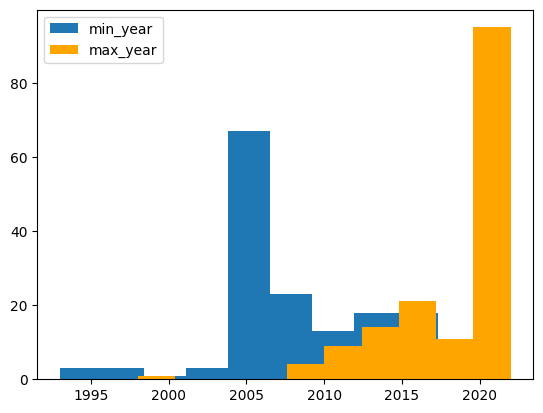

In [136]:
plt.hist(np.array(year_stat)[:, 0], label='min_year')
plt.hist(np.array(year_stat)[:, 1], color='orange', label='max_year')
plt.legend()


In [19]:
with open('Data/people_w_more_than_10_paies_list.pkl', 'wb') as fp:
    pickle.dump(people_w_more_than_10_paies, fp)


In [20]:
with open('Data/people_w_more_than_10_paies_list.pkl', 'rb') as fp:
    people_w_more_than_10_paies_list = pickle.load(fp)


In [21]:
len(people_w_more_than_10_paies), len(people_w_more_than_5_paies)


(987, 996)

# Hard model wo pensia

Обучение модели на дате без ваплат пользователям

In [37]:
import tensorflow as tf


In [150]:
important_series_columns = [
    'npo_sum',
    'npo_operation_group',
    'npo_operation_date_year',
    'npo_operation_date_month',
    'npo_operation_date_day'
]


In [17]:
with open('DATA/people_w_more_than_10_paies_list.pkl', 'rb') as fp:
    people_w_more_than_10_paies_list = pickle.load(fp)


In [140]:
people_w_more_than_10_paies = list(filter(lambda a: a.shape[0] > 10, list(clients_sums_wo_pensia.values())))
people_w_more_than_5_paies = list(filter(lambda a: a.shape[0] > 5, list(clients_sums_wo_pensia.values())))

In [141]:
year_stat = list(map(lambda a: [a['npo_operation_date_year'].min(), a['npo_operation_date_year'].max(), a['npo_frst_pmnt_date_year'].min(), a['npo_lst_pmnt_date_year'].min()], people_w_more_than_10_paies))


In [153]:
month_stat = list(map(lambda a: [a['npo_operation_date_month'].to_numpy(), a['npo_operation_date_day'].to_numpy()], people_w_more_than_10_paies))


87.0


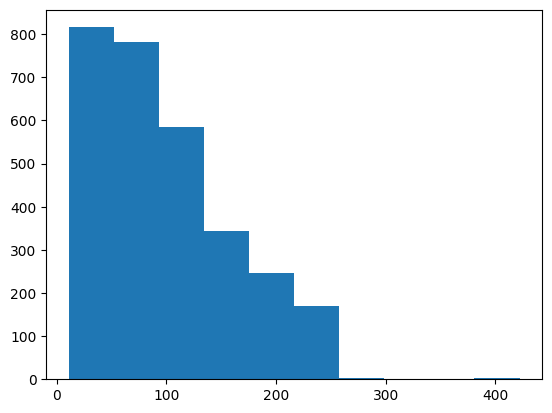

In [160]:
plt.hist(list(map(lambda a: a[0].shape[0], month_stat)))
print(np.median(list(map(lambda a: a[0].shape[0], month_stat))))


Text(0.5, 0, 'activity years')

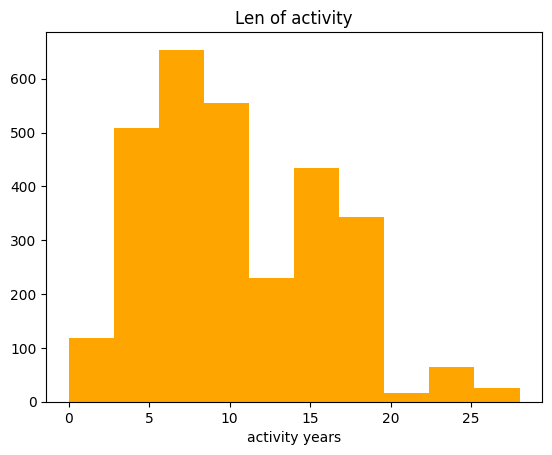

In [196]:
plt.hist(abs(np.array(year_stat)[:, 0] - np.array(year_stat)[:, 1]), color='orange')
plt.title('Len of activity')
plt.xlabel('activity years')


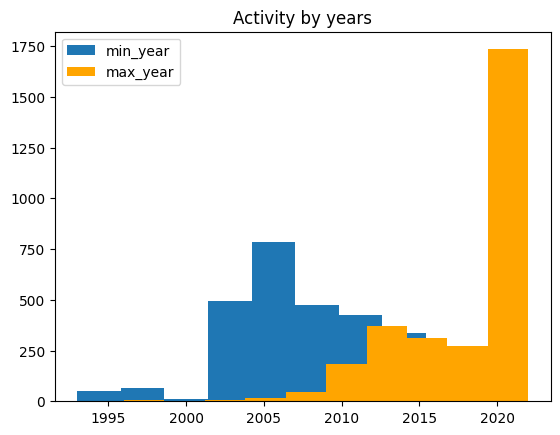

In [197]:
plt.hist(np.array(year_stat)[:, 0], label='min_year')
plt.hist(np.array(year_stat)[:, 1], color='orange', label='max_year')
plt.title('Activity by years')
plt.legend()


In [143]:
users_wo_pensia_data = list(map(create_vector_user, people_w_more_than_10_paies))

In [27]:
cbc_wo_pensia_load = CatBoostClassifier()
classes_wo_p = cbc_wo_pensia_load.load_model('Models/classificator_catboost_wo_pensia.pkl')#.predict(users_wo_pensia_data)


In [146]:
np.unique(classes_wo_p.T)


array([0, 1, 2, 3], dtype=int64)

In [165]:
people_w_more_than_10_paies[0].sort_values(by=['npo_operation_date_year', 'npo_operation_date_month', 'npo_operation_date_day'])


npo_accnt_id   npo_sum  npo_operation_group  \
100  0x05C7DF8BA2611640BE946E29CF20C6D2  61137.39                    0   
20   0x05C7DF8BA2611640BE946E29CF20C6D2   1626.01                    0   
80   0x05C7DF8BA2611640BE946E29CF20C6D2   1626.01                    0   
77   0x05C7DF8BA2611640BE946E29CF20C6D2   1626.01                    0   
96   0x05C7DF8BA2611640BE946E29CF20C6D2   1626.01                    0   
..                                  ...       ...                  ...   
4    0x05C7DF8BA2611640BE946E29CF20C6D2   1626.01                    0   
121  0x05C7DF8BA2611640BE946E29CF20C6D2   1626.01                    0   
32   0x05C7DF8BA2611640BE946E29CF20C6D2   1626.01                    0   
99   0x05C7DF8BA2611640BE946E29CF20C6D2   1626.01                    0   
63   0x05C7DF8BA2611640BE946E29CF20C6D2    145.30                    1   

     npo_operation_date_year  npo_operation_date_month  \
100                     2005                         8   
20                      2005                         9   
80                      2005                        10   
77                      2005                        11   
96                      2005                        12   
..                       ...                       ...   
4                       2016                        11   
121                     2016                        12   
32                      2017                         1   
99                      2017                         2   
63                      2017                         3   

     npo_operation_date_day                             clnt_id  \
100                      31  0xE1494CDD114361469D1979AB0311F504   
20                       15  0xE1494CDD114361469D1979AB0311F504   
80                       15  0xE1494CDD114361469D1979AB0311F504   
77                       13  0xE1494CDD114361469D1979AB0311F504   
96                       12  0xE1494CDD114361469D1979AB0311F504   
..                      ...                                 ...   
4                         5  0xE1494CDD114361469D1979AB0311F504   
121                       5  0xE1494CDD114361469D1979AB0311F504   
32                        5  0xE1494CDD114361469D1979AB0311F504   
99                        5  0xE1494CDD114361469D1979AB0311F504   
63                       23  0xE1494CDD114361469D1979AB0311F504   

     accnt_pnsn_schm  npo_accnt_status  npo_blnc  ...  \
100             51.0                 0      -1.0  ...   
20              51.0                 0      -1.0  ...   
80              51.0                 0      -1.0  ...   
77              51.0                 0      -1.0  ...   
96              51.0                 0      -1.0  ...   
..               ...               ...       ...  ...   
4               51.0                 0      -1.0  ...   
121             51.0                 0      -1.0  ...   
32              51.0                 0      -1.0  ...   
99              51.0                 0      -1.0  ...   
63              51.0                 0      -1.0  ...   

     npo_frst_pmnt_date_year  npo_frst_pmnt_date_month  \
100                   2005.0                       8.0   
20                    2005.0                       8.0   
80                    2005.0                       8.0   
77                    2005.0                       8.0   
96                    2005.0                       8.0   
..                       ...                       ...   
4                     2005.0                       8.0   
121                   2005.0                       8.0   
32                    2005.0                       8.0   
99                    2005.0                       8.0   
63                    2005.0                       8.0   

     npo_frst_pmnt_date_day  npo_lst_pmnt_date_year  npo_lst_pmnt_date_month  \
100                    31.0                  2017.0                      2.0   
20                     31.0                  2017.0                      2.0   
80            

In [ ]:
list_of_users_preprcessed = list(map(lambda a: a.loc[:, important_series_columns]))

In [192]:
gdp_list = pd.read_excel('DATA/GDP.xlsx')

In [183]:
gdp_list.columns


Index(['Дата ', 'в млрд. долл. США ', 'в млрд. рублей',
       'в процентах к ВВП**  '],
      dtype='object')

In [193]:
gdp_list['month'] = pd.to_datetime(gdp_list['Дата ']).dt.month
gdp_list['year'] = pd.to_datetime(gdp_list['Дата ']).dt.year
gdp_list['gdv'] = gdp_list['в млрд. рублей'].apply(lambda a: float(str(a).replace(' ', '').replace(',', '.').replace('\xa0', '')))
gdp_list_p = gdp_list.loc[:, ['month', 'year', 'gdv']]


In [377]:
gdp_list_p.to_csv('OuterFiles/gdp_processed.csv')


In [21]:
gdp_list_p = pd.read_csv('OuterFiles/gdp_processed.csv')


```mod_user``` - преобразует пользователя в вектор 201 (на данный момент, возможно повашение числа признаков), где 
- 1 параметр вектора - это класс юзера;
- 2-100 - npo_sum по времени уравновешанные фильтром;
- 101-201 - значения ВВП в данный период.

данная ф-ция применяется для создания тестовой и тренеровочной выборки.

Для работы с NN применяется ```mod_user_for_predict```

In [242]:
def mod_user(a, gdps, space):
    data = a.sort_values(by=['npo_operation_date_year', 'npo_operation_date_month', 'npo_operation_date_day'])
    u1d = create_vector_user(data)
    class_of_user = cbc_wo_pensia_load.predict(u1d.reshape(1, u1d.shape[0]))
    gdp = list()
    for i in data.loc[:, ['npo_operation_date_month', 'npo_operation_date_year']].to_numpy():
        res = gdps.loc[(gdps['month'] + space['month'] == i[0]) & (gdps['year'] + space['year'] == i[1])]
        if res.shape[0]:
            gdp.append(res['gdv'].median())
        else:
            gdp.append(-1)
    data_npo_sum = data['npo_sum'].to_numpy().reshape(1, data.shape[0])
    gdp = np.array(gdp).reshape(1, data.shape[0])
    c = np.append(data_npo_sum, gdp, axis=0)
    f = signal.resample(c.T, 100).T
    f = f.reshape(1, f.shape[0] * f.shape[1])
    f = np.insert(f, 0, class_of_user)
    return f


In [9]:
def mod_user_for_predict(a, gdps, space, classificator, create_vector_user, time_aproximator):
    data = a.sort_values(by=['npo_operation_date_year', 'npo_operation_date_month', 'npo_operation_date_day'])
    u1d = create_vector_user(data)
    class_of_user = classificator.predict(u1d.reshape(1, u1d.shape[0]))
    gdp = list()
    for i in data.loc[:, ['npo_operation_date_month', 'npo_operation_date_year']].to_numpy():
        res = gdps.loc[(gdps['month'] + space['month'] == i[0])
                       & (gdps['year'] + space['year'] == i[1])]
        if res.shape[0]:
            gdp.append(res['gdv'].median())
        else:
            gdp.append(-1)
    data_npo_sum = data['npo_sum'].to_numpy().reshape(1, data.shape[0])
    gdp = np.array(gdp).reshape(1, data.shape[0])
    c = np.append(data_npo_sum, gdp, axis=0)
    f = time_aproximator(c.T, 75).T
    f = f.reshape(1, f.shape[0] * f.shape[1])
    f = np.insert(f, 0, class_of_user)
    return f


In [339]:
mod_user(people_w_more_than_10_paies[0], gdp_list_p, space={'month': 4, 'year': 1}).shape


(201,)

In [28]:
mod_user_for_predict(
    people_w_more_than_10_paies_list[0],
    gdp_list_p,
    space={'month': 4, 'year': 1},
    classificator=cbc_wo_pensia_load,
    create_vector_user=create_vector_user,
    time_aproximator=signal.resample
).shape


(151,)

In [35]:
mod_user_for_predict(
    people_w_more_than_10_paies_list[0], 
    gdp_list_p, 
    space={'month': 4, 'year': 1}, 
    classificator=cbc_wo_pensia_load, 
    create_vector_user=create_vector_user, 
    time_aproximator=signal.resample
).shape


(151,)

In [36]:
list(map(lambda a: mod_user_for_predict(
    a, 
    gdp_list_p, 
    space={'month': 4, 'year': 1},
    classificator=cbc_wo_pensia_load,
    create_vector_user=create_vector_user,
    time_aproximator=signal.resample
    ), people_w_more_than_10_paies_list,))


[array([ 3.00000000e+00,  2.92326206e+04,  1.56281965e+03,  1.80843939e+03,
         1.31832619e+03,  2.13487166e+03,  5.65810967e+02,  5.15236377e+03,
         5.24139392e+03,  4.50754254e+02,  2.32428585e+03,  1.18511286e+03,
         1.61380109e+03,  1.71951564e+03,  3.57043871e+03,  7.50338573e+02,
         2.33529514e+03,  9.71187345e+02,  2.26896223e+03,  6.76670568e+02,
         4.39557876e+03,  1.61552625e+03,  1.94770664e+03,  1.17821198e+03,
         2.21072405e+03,  7.24735815e+02,  4.14695999e+03,  2.36289896e+03,
         1.36316686e+03,  1.39317582e+03,  2.01967676e+03,  6.56489074e+02,
         4.01735271e+03,  2.70692508e+03,  1.18917970e+03,  1.83077721e+03,
         1.54365288e+03,  1.61062870e+03,  1.78438208e+03,  5.00554965e+03,
         1.21288520e+03,  1.80262298e+03,  1.49800588e+03,  1.76551235e+03,
         1.37718485e+03,  2.57909592e+03,  7.43504272e+03,  8.92769443e+02,
         2.27488958e+03,  9.25452859e+02,  2.49442454e+03,  3.34208404e+02,
         4.4

In [ ]:
dataset_preprocessed_TS = list(map(lambda a: mod_user(a, gdp_list_p, space={'month': 4, 'year': 1}), people_w_more_than_10_paies,))

In [358]:
dataset_preprocessed_x, dataset_preprocessed_y = [], []
for i in dataset_preprocessed_TS:
    dataset_preprocessed_y.append(i[76:101])
    x = np.delete(i, np.arange(75, 100) + 1)
    x = np.delete(x, np.arange(75, 100) + 1 + 100 - 25)
    dataset_preprocessed_x.append(x)


In [360]:
dataset_preprocessed_x = np.array(dataset_preprocessed_x)
dataset_preprocessed_y = np.array(dataset_preprocessed_y)


In [361]:
dataset_preprocessed_x.shape, dataset_preprocessed_y.shape


((2949, 151), (2949, 25))

In [362]:
X_train_ts, X_test_ts, y_train_ts, y_test_ts = train_test_split(dataset_preprocessed_x, dataset_preprocessed_y, shuffle=True, test_size=0.1)


создадим модель на подобии VGG 16 т.к. кластеры у нас достаточно гладкие (плотные)

In [363]:
model_class = tf.keras.models.Sequential()
model_class.add(
    tf.keras.layers.Dense(
        X_train_ts.shape[1],
        activation='relu',
        input_shape=(X_train_ts.shape[1],),
        name='input',
        # kernel_regularizer=tf.keras.regularizers.L2(l2=1),
        #   kernel_constraint=tf.keras.constraints.max_norm(1000.),
        bias_initializer=tf.keras.initializers.HeNormal,
        use_bias=True
    )
)
model_class.add(
    tf.keras.layers.Dense(
        int(X_train_ts.shape[1]*0.8),
        activation='relu',
        name='hidden_layer_2',
        # kernel_regularizer=tf.keras.regularizers.L2(l2=1),
        #   kernel_constraint=tf.keras.constraints.max_norm(1000.),
        bias_initializer=tf.keras.initializers.HeNormal,
        use_bias=True
    )
)
model_class.add(
    tf.keras.layers.Dense(
        int(X_train_ts.shape[1] * 0.6),
        activation='relu',
        name='hidden_layer_3',
        # kernel_regularizer=tf.keras.regularizers.L2(l2=1),
        #   kernel_constraint=tf.keras.constraints.max_norm(1000.),
        bias_initializer=tf.keras.initializers.HeNormal,
        use_bias=True
    )
)
model_class.add(
    tf.keras.layers.Dense(
        int(X_train_ts.shape[1] * 0.4),
        activation='relu',
        name='hidden_layer_4',
        # kernel_regularizer=tf.keras.regularizers.L2(l2=1),
        #   kernel_constraint=tf.keras.constraints.max_norm(1000.),
        bias_initializer=tf.keras.initializers.HeNormal,
        use_bias=True
    )
)
model_class.add(
    tf.keras.layers.Dense(
        int(X_train_ts.shape[1] * 0.2),
        activation='relu',
        name='hidden_layer_5',
        # kernel_regularizer=tf.keras.regularizers.L2(l2=1),
        #   kernel_constraint=tf.keras.constraints.max_norm(1000.),
        bias_initializer=tf.keras.initializers.HeNormal,
        use_bias=True
    )
)
model_class.add(
    tf.keras.layers.Dense(
        y_train_ts.shape[1],
        name='output',
        activation='relu',
        # kernel_regularizer=tf.keras.regularizers.L2(l2=1),
        #   kernel_constraint=tf.keras.constraints.max_norm(1000.),
        bias_initializer=tf.keras.initializers.HeNormal,
        use_bias=True
    )
)
model_class.summary()
model_coder = model_class


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Dense)               (None, 151)               22952     
                                                                 
 hidden_layer_2 (Dense)      (None, 120)               18240     
                                                                 
 hidden_layer_3 (Dense)      (None, 90)                10890     
                                                                 
 hidden_layer_4 (Dense)      (None, 60)                5460      
                                                                 
 hidden_layer_5 (Dense)      (None, 30)                1830      
                                                                 
 output (Dense)              (None, 25)                775       
                                                                 
Total params: 60147 (234.95 KB)
Trainable params: 6014

In [364]:
model_coder.compile(
    optimizer='Adam',
    loss='mae',
    metrics=[tf.keras.metrics.mean_absolute_error]
)


In [365]:
model_coder.fit(
    X_train_ts,
    y_train_ts,
    validation_split=0.1,
    epochs=500,
    batch_size=1024, verbose=1
)


Epoch 1/500
3/3 [==============================] - 3s 228ms/step - loss: 2332.6917 - mean_absolute_error: 2332.6917 - val_loss: 2051.6472 - val_mean_absolute_error: 2051.6472
Epoch 2/500
3/3 [==============================] - 0s 56ms/step - loss: 2169.8962 - mean_absolute_error: 2169.8962 - val_loss: 1963.0583 - val_mean_absolute_error: 1963.0583
Epoch 3/500
3/3 [==============================] - 0s 58ms/step - loss: 2082.6382 - mean_absolute_error: 2082.6382 - val_loss: 1903.5802 - val_mean_absolute_error: 1903.5802
Epoch 4/500
3/3 [==============================] - 0s 58ms/step - loss: 2023.1759 - mean_absolute_error: 2023.1759 - val_loss: 1843.1437 - val_mean_absolute_error: 1843.1437
Epoch 5/500
3/3 [==============================] - 0s 54ms/step - loss: 1959.4631 - mean_absolute_error: 1959.4631 - val_loss: 1797.4240 - val_mean_absolute_error: 1797.4240
Epoch 6/500
3/3 [==============================] - 0s 68ms/step - loss: 1927.4611 - mean_absolute_error: 1927.4611 - val_loss: 17

Можно увидеть что ошибка примерно на 1000 юзеров = 380 $\Rightarrow$ качество хорошее

In [366]:
pred_exmpl = model_coder.predict(X_test_ts)


10/10 [==============================] - 0s 6ms/step


In [367]:
pred_exmpl.shape


(295, 25)

Вывидим предикт модели в среднем

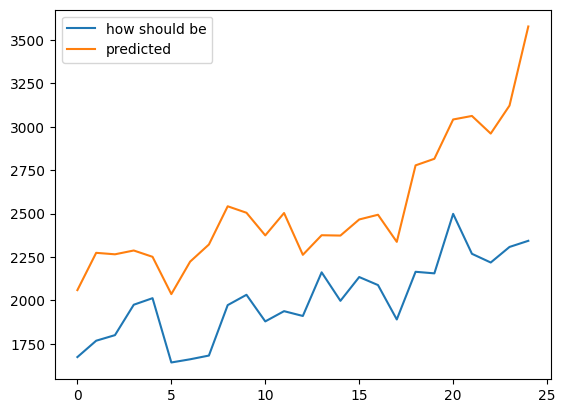

In [368]:
plt.plot(np.mean(pred_exmpl, axis=0), label='how should be')
plt.plot(np.mean(y_train_ts, axis=0), label='predicted')
plt.legend()


можно заметить что модель слегка завышает результаты поэтому увеличим выходной bias на -500

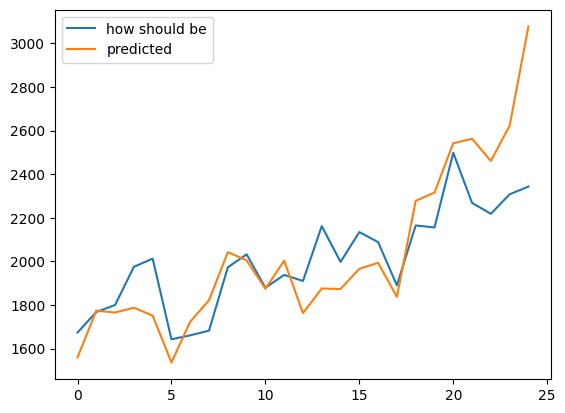

In [369]:
plt.plot(np.mean(pred_exmpl, axis=0), label='how should be')
plt.plot(np.mean(y_train_ts-500, axis=0), label='predicted')
plt.legend()


In [383]:
from sklearn.metrics import r2_score

In [385]:
r2_score(np.mean(y_train_ts-500, axis=0), np.mean(pred_exmpl, axis=0))


0.6615715142429435

In [370]:
model_coder.save('Models/time_series.h5')

c:\Users\Mike\Desktop\Hackaton2023\HT\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Save usefull fun's

In [29]:
with open('UsefullFuns/create_vector_user.pkl', 'wb') as fp:
    pickle.dump(create_vector_user, fp)


In [30]:
with open('UsefullFuns/mod_user_for_predict.pkl', 'wb') as fp:
    pickle.dump(mod_user_for_predict, fp)


# Addons

In [64]:
with open('DATA/clients_sums_small.pkl', 'rb') as fp:
    clients_sums_small = pickle.load(fp)


In [65]:
users_wo_pensia_data = list(map(create_vector_user, list(clients_sums_small.values())))


In [66]:
clusters = cbc_wo_pensia_load.predict(users_wo_pensia_data)


In [67]:
len(clusters.T.tolist()[0])


958

In [68]:
dict(x)


{3: 340, 0: 600, 2: 45, 1: 2}

([0, 1, 2, 3],
 [Text(0, 0, 'Осторожный кролик'),
  Text(1, 0, 'Открытый кролик'),
  Text(2, 0, 'Предприимчивый кролик'),
  Text(3, 0, 'Смелый кролик')])

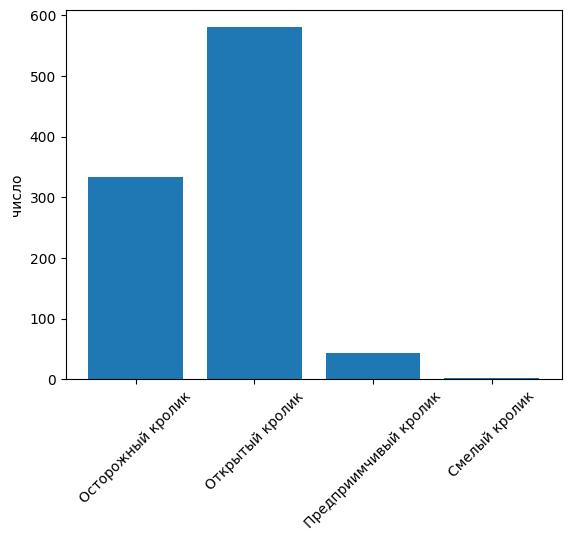

In [69]:
from collections import Counter
x = Counter(clusters.T.tolist()[0])
r = {"3": "Осторожный кролик", "1": "Смелый кролик",
     "2": "Предприимчивый кролик", "0": "Открытый кролик"}
plt.bar(list(map(lambda a: r[str(a)], list(dict(x).keys()))), dict(x).values())
plt.ylabel('число')
plt.xticks(rotation=45)

